In [1]:
# Import necessary librarie

import warnings

warnings.filterwarnings('ignore')

import datetime

import numpy as np
import pandas as pd
from pandas_datareader.data import DataReader
import matplotlib.pyplot as plt
import seaborn as sns
import functools

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.metrics import confusion_matrix

import pmdarima
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

from collections import deque
import random
import tensorflow.compat.v1 as tf
tf.compat.v1.disable_eager_execution()

## Data Wrangling

In [2]:
# Download the data for the stocks
data = pd.ExcelFile('stock_prices.xlsx')

In [3]:
# Get the sheet names to download the sotck prices in different data frames
data.sheet_names

['Russia - Sberbank Rossii PAO (S',
 'Turkey - Koc Holding AS (KCHOL)',
 'Egypt - Medinet Nasr Housing (M',
 'Brazil - Minerva SABrazil (BEEF',
 'Argentina - Pampa Energia SA (P',
 'Colombia - Cementos Argos SA (C',
 'South Africa - Impala Platinum ',
 'South Korea - Dongkuk Steel Mil']

In [4]:
# Define a function to read the stock information, get the price column and rename to the stock + Price name

def read_stock(n, col_name):
    df = pd.DataFrame(data.parse(data.sheet_names[n])[['Date','Price']]).rename(columns = {'Price': col_name})
    df = df.iloc[:-1, :]
    df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d', errors='ignore')
    df = df.set_index('Date')
    return df

In [5]:
# Use the function for the different stock prices

S_stock = read_stock(n = 0, col_name = 'S_Price')
KCHOL_stock = read_stock(n = 1, col_name = 'KCHOL_Price')
M_stock = read_stock(n = 2, col_name = 'M_Price')
BEEF_stock = read_stock(n = 3, col_name = 'BEEF_Price')
P_stock = read_stock(n = 4, col_name = 'P_Price')
C_stock = read_stock(n = 5, col_name = 'C_Price')
IP_stock = read_stock(n = 6, col_name = 'IP_Price')
DS_stock = read_stock(n = 7, col_name = 'DS_Price')

In [6]:
# Define a function to merge the different data frames

def merge_df(df1, df2, df3, df4, df5, df6, df7, df8):
    df = [df1, df2, df3, df4, df5, df6, df7, df8]
    return functools.reduce(lambda left, right : pd.merge(left, right, how = 'left', on = 'Date'), df)

In [7]:
# Merge he data frames

stock_prices = merge_df(df1 = S_stock, df2 = KCHOL_stock, df3 = M_stock, df4 = BEEF_stock, df5 = P_stock, 
                        df6 = C_stock, df7 = IP_stock, df8 = DS_stock)

In [8]:
# Sort the index to have the dates in ascending order

stock_prices = stock_prices.sort_index()

In [9]:
# Check out the NaN Values

for col in stock_prices:
    print(col)
    print(stock_prices[col].isna().sum())

S_Price
0
KCHOL_Price
9
M_Price
77
BEEF_Price
13
P_Price
22
C_Price
20
IP_Price
10
DS_Price
14


In [10]:
# Fill the NaN values with forward filling

stock_prices_daily = stock_prices.fillna(method = 'ffill')

stock_prices_daily['M_Price'] = stock_prices['M_Price'].fillna(method = 'bfill')

# Normalize the data to have prices between 0-1 (different currencies)

stock_prices_daily_normalized = stock_prices_daily.div(stock_prices_daily.max())

In [11]:
# Resample the data weekly and monthly and do the same for the normalized data

stock_prices_weekly = stock_prices_daily.resample('W').mean()
stock_prices_weekly_normalized = stock_prices_daily_normalized.resample('W').mean()

stock_prices_monthly = stock_prices_daily.resample('M').mean()
stock_prices_monthly_normalized = stock_prices_daily_normalized.resample('M').mean()

In [12]:
# Calculate the returns for daily, weekly and monthly 

stock_returns_daily = stock_prices_daily.pct_change().dropna()

stock_returns_weekly = stock_prices_weekly.pct_change().dropna()

stock_returns_monthly = stock_prices_monthly.pct_change().dropna()

In [13]:
# Multi Period Return

def multi_period_return(period_returns):
    return np.prod(period_returns + 1) - 1

stock_returns_daily_pr = stock_returns_daily.rolling('360D').apply(multi_period_return)

In [14]:
# See the first rows for stock returns daily

stock_returns_daily.head()

S_Price  KCHOL_Price   M_Price  BEEF_Price   P_Price   C_Price  \
Date                                                                          
2020-01-06 -0.004314    -0.010837  0.000000   -0.000775 -0.006148  0.000000   
2020-01-08  0.020677    -0.006972  0.030374    0.057409 -0.041237 -0.017143   
2020-01-09 -0.004476     0.024072  0.047619   -0.015407  0.036559 -0.010174   
2020-01-10  0.000775     0.005877  0.025974   -0.004471 -0.002075 -0.005874   
2020-01-13  0.016306     0.012658  0.000000    0.089820 -0.010395 -0.016248   

            IP_Price  DS_Price  
Date                            
2020-01-06 -0.015024 -0.028814  
2020-01-08  0.045828 -0.052356  
2020-01-09 -0.016939  0.011050  
2020-01-10 -0.007784  0.001821  
2020-01-13 -0.010862  0.003636

In [15]:
# See the first rows for stock returns weekly

stock_returns_weekly.head()

S_Price  KCHOL_Price   M_Price  BEEF_Price   P_Price   C_Price  \
Date                                                                          
2020-01-12  0.009049    -0.002709  0.054322    0.032946 -0.019980 -0.019286   
2020-01-19  0.008731     0.030575  0.064598    0.099437 -0.016414 -0.035397   
2020-01-26  0.024912     0.015146 -0.028310   -0.023754  0.002976  0.000604   
2020-02-02 -0.035809    -0.054958  0.000857   -0.168508 -0.035184 -0.016601   
2020-02-09 -0.008944    -0.005995  0.006421    0.001009  0.032293 -0.010129   

            IP_Price  DS_Price  
Date                            
2020-01-12  0.008135 -0.061441  
2020-01-19 -0.007922 -0.003521  
2020-01-26 -0.024533 -0.009786  
2020-02-02 -0.046765 -0.071925  
2020-02-09  0.064895  0.004536

In [16]:
# See the first rows for stock returns monthly

stock_returns_monthly.head()

S_Price  KCHOL_Price   M_Price  BEEF_Price   P_Price   C_Price  \
Date                                                                          
2020-02-29 -0.035158    -0.052227 -0.018411   -0.115723 -0.065941 -0.093874   
2020-03-31 -0.208611    -0.233035 -0.288244   -0.272670 -0.125974 -0.364742   
2020-04-30 -0.029628    -0.017621 -0.087966    0.116947  0.102754  0.001470   
2020-05-31  0.002142     0.036267 -0.113204    0.373662  0.225149 -0.074671   
2020-06-30  0.087484     0.143947  0.019610   -0.020883 -0.053766  0.007810   

            IP_Price  DS_Price  
Date                            
2020-02-29  0.051736 -0.052666  
2020-03-31 -0.395876 -0.262213  
2020-04-30  0.105588  0.040225  
2020-05-31  0.098673  0.034586  
2020-06-30  0.076068  0.473359

## Data Visualization

In [17]:
# Plot how the prices have been moving during time

def plot_prices(df):
    df.plot()
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend(loc = (1.02,0))
    return plt.show()

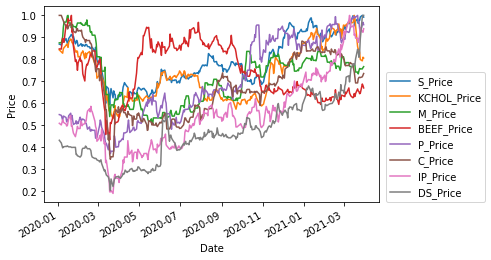

In [18]:
# Plot daily prices

plot_prices(df = stock_prices_daily_normalized)

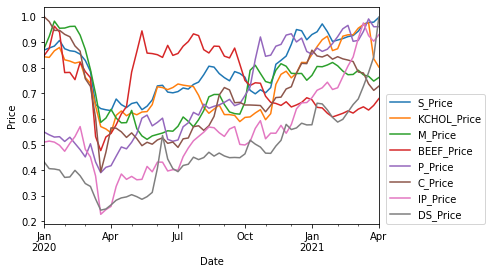

In [19]:
# Plot weekly prices

plot_prices(df = stock_prices_weekly_normalized)

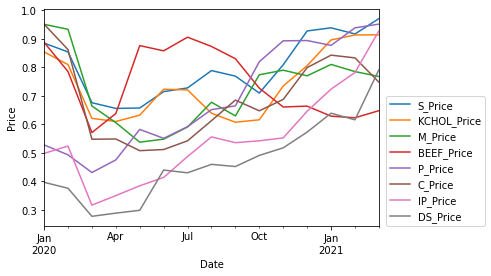

In [20]:
# Plot monthly prices

plot_prices(df = stock_prices_monthly_normalized)

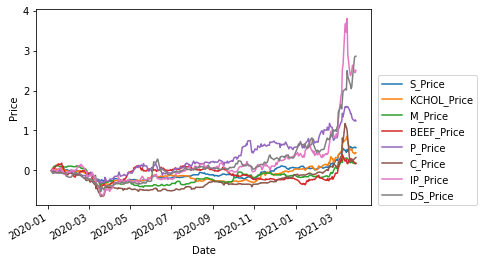

In [21]:
# Plot multiperiod return

plot_prices(df = stock_returns_daily_pr)


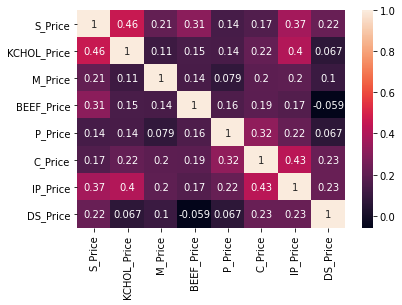

In [22]:
# Plot a correlation heatmap among all the stocks

corr_matrix = stock_returns_daily.corr()

# Plot the heatmap

sns.heatmap(corr_matrix, annot = True)
plt.show()

## Feature Engineering

In [23]:
# Define a function to use MaxMin Scaler for the modeling part

def scaler(train_array, test_array):
    scaler = MinMaxScaler(feature_range = (0,1))
    a = train_array.reshape(-1,1)
    b = test_array.reshape(-1,1)
    scaler = scaler.fit(a)
    X = scaler.transform(a)
    y = scaler.transform(b)
    return X, y

In [24]:
# Define a function to calculate the real price of the stock based on the MinMax Scaler

def scaler_inverse(train_array, predictions):
    scaler = MinMaxScaler(feature_range = (0,1))
    c = train_array.reshape(-1,1)
    scaler.fit(c)
    y_inverse = scaler.inverse_transform(predictions)
    return y_inverse

In [25]:
# Define a function to have the previous 5 days as independant features to predict the stock price

def preprocessing(dataset, time_steps = 1):
    X, y = [], []
    for i in range(len(dataset) - time_steps - 1):
        x = dataset[i:(i + time_steps), 0]
        X.append(x)
        y.append(dataset[i + time_steps, 0])
    return X, y

In [26]:
# Divide the train and test data

train = stock_prices_daily['2020']
test = stock_prices_daily['2021']

In [27]:
# Define an empty array to change the shape of the X variable (train and test)
# The new shape with treat the stock prices as each of the subarrays
# Eight stocks mean an array with shape (8, n_days)

n_days = len(stock_prices_daily)

# Define number of stocks

n_stocks = len(stock_prices_daily.columns)

# Save the number of days that are going to be used as train and test

n_days_train = len(train)
n_days_test = len(test)

# Empty array for the train and test data

train_scale = np.zeros(shape = (n_stocks, n_days_train))

test_scale = np.zeros(shape = (n_stocks, n_days_test))

# Use the for loop to iterate over the train and test to have the array shape changed

for i in range(0, n_stocks):
    train_scale[i] = train.iloc[:,i]
    
for i in range(0, n_stocks):
    test_scale[i] = test.iloc[:,i]


### Apply the Scaler function to the stocks

In [28]:
# Empty arrays for the train and test data (n_stocks, ndays, 1) to make it usable after using the MinMax Scaler

Xtrain = np.empty(shape = (n_stocks, n_days_train, 1))

Xtest = np.empty(shape = (n_stocks, n_days_test, 1))

# For loop to create the Xtrain and Xtest and scale the data (by just fitting the train data). 
# The idea is to avoid the data leakage by scaling the complete data set

for i in range(n_stocks):
    Xtrain[i], Xtest[i] = scaler(train_array = train_scale[i], test_array = test_scale[i])
    

In [29]:
# Get together the Xtrain and Xtest to apply some feature engineering (Make previous 5 days as independent variables)
# and the day ahead the dependant variable

# Define the empty array to iterate over an array (more time efficient)

Values = np.empty(shape = (n_stocks, n_days, 1))

#Iterate by concatenating the Xtrain and Xtest

for i in range(n_stocks):
    Values[i] = np.concatenate((Xtrain[i], Xtest[i]))

In [30]:
# Use the function to use the previous 5 days as independent features for train data

time_steps = 5

# Make two empty list to store the data

X = []
y = []

for i in range(0, n_stocks):
    # Use the preprocessing function 
    a,b = preprocessing(dataset = Values[i], time_steps = time_steps)
    # Apend the values
    X.append(a)
    y.append(b)

# Make sure to have them as arrays

X = np.array(X)
y = np.array(y)

In [31]:
# X_train array will have new shape

# Define the new days for each subarray

n_days_train_resample = n_days_train - time_steps - 1

# Make empty arrays with the reshape of the data after taking the 5 days as independant variables

X_train = np.empty(shape = (n_stocks, n_days_train_resample, 5))

y_train = np.empty(shape = (n_stocks, n_days_train_resample))

X_test = np.empty(shape = (n_stocks, n_days_test, 5))

y_test = np.empty(shape = (n_stocks, n_days_test))

In [32]:
# Start for the X_train, y_train, X_test, y_test

for i in range(n_stocks):
    X_train[i], y_train[i] = X[i][:n_days_train_resample], y[i][:n_days_train_resample]
    X_test[i], y_test[i] = X[i][n_days_train_resample:], y[i][n_days_train_resample:]

In [33]:
# Reshape input to be [samples, time steps, features] which is required for LSTM

X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , X_test.shape[2], 1)

In [34]:
print('Shape of the train data to use at the model', X_train.shape, y_train.shape)
print('Shape of the test data to use', X_test.shape, y_test.shape)

Shape of the train data to use at the model (8, 244, 5, 1) (8, 244)
Shape of the test data to use (8, 61, 5, 1) (8, 61)


## Modeling

### LSTM

In [35]:
# Define a model to build the neural network

def neural_network():
    # Begin with Sequential
    regressor = Sequential()
    # The first layer would the be LSTM
    regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (5,1)))
    regressor.add(Dropout(0.2))
    regressor.add(LSTM(units = 50, return_sequences = True))
    regressor.add(Dropout(0.2))
    regressor.add(LSTM(units = 50))
    regressor.add(Dropout(0.2))
    regressor.add(Dense(units = 1))
    regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
    return regressor

In [36]:
# Define a variable to reshape the train and test data into shape (, , 1) to make it processable on the neural network

def variables_model(n):
    x_train, Y_train = X_train[n], y_train[n]
    x_test, Y_test = X_test[n], y_test[n]
    
    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
    x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)
    
    return (x_train, x_test, Y_train, Y_test)
    

In [37]:
# Fit the model and get the predictions

def model_fit(Xtr, ytr, Xte):
    model.fit(Xtr, ytr, epochs = 100, batch_size = 32)
    pred = model.predict(Xte)
    return pred

In [38]:
# For future use in plotting, create one data frame to have the train values plus the test values
# and another pandas series to have the train data plus the predicted values

def df_merger(train_data, test_data, pred_values):
    actual_data = train_data.append(test_data)
    predicted_data = train_data.append(pred_values)
    return actual_data, predicted_data

In [39]:
# Compare actual values with predicted values with a plot

def plot_comparison(actual, predicted, string):
    #Visualizing the prediction
    plt.figure(figsize=(10,6))
    plt.plot(actual[:'2020-12-30'], color = 'blue')
    plt.plot(actual['2020-12-30':], color = 'orange', label = 'Actual Values')
    plt.plot(predicted['2020-12-30':], color = 'green', label = 'Predicted Values')
    plt.title(string)
    plt.xlabel('Trading Day')
    plt.ylabel('Price')
    plt.legend()
    return plt.show()
    

In [40]:
# Save a data frame to concat all the predictions

# Start with an empty data frame
predictions_df = pd.DataFrame()

# Start with the same date than the test for the comparisons.
predictions_df['Date'] = test.index

#Set the date as the index
predictions_df.set_index('Date', inplace = True)

In [41]:
# Define the model

model = neural_network()

In [42]:
# Check the summary

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 50)             10400     
_________________________________________________________________
dropout (Dropout)            (None, 5, 50)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 5, 50)             20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 50)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 5

#### S_Stock

In [43]:
# Get the data for this stock

S_Xtrain, S_Xtest, S_ytrain, S_ytest = variables_model(n = 0)

In [44]:
# Fit the data for the stock

S_pred = model_fit(Xtr = S_Xtrain, ytr = S_ytrain, Xte = S_Xtest)


Train on 244 samples
Epoch 1/100
244/244 [==============================] - 0s 291us/sample - loss: 0.2017
Epoch 2/100
244/244 [==============================] - 0s 278us/sample - loss: 0.0640
Epoch 3/100
244/244 [==============================] - 0s 338us/sample - loss: 0.0422
Epoch 4/100
244/244 [==============================] - 0s 246us/sample - loss: 0.0235
Epoch 5/100
244/244 [==============================] - 0s 316us/sample - loss: 0.0239
Epoch 6/100
244/244 [==============================] - 0s 245us/sample - loss: 0.0163
Epoch 7/100
244/244 [==============================] - 0s 319us/sample - loss: 0.0146
Epoch 8/100
244/244 [==============================] - 0s 295us/sample - loss: 0.0119
Epoch 9/100
244/244 [==============================] - 0s 311us/sample - loss: 0.0102
Epoch 10/100
244/244 [==============================] - 0s 318us/sample - loss: 0.0101
Epoch 11/100
244/244 [==============================] - 0s 284us/sample - loss: 0.0107
Epoch 12/100
244/244 [=========

244/244 [==============================] - 0s 362us/sample - loss: 0.0067
Epoch 96/100
244/244 [==============================] - 0s 365us/sample - loss: 0.0074
Epoch 97/100
244/244 [==============================] - 0s 334us/sample - loss: 0.0064
Epoch 98/100
244/244 [==============================] - 0s 338us/sample - loss: 0.0062
Epoch 99/100
244/244 [==============================] - 0s 323us/sample - loss: 0.0064
Epoch 100/100
244/244 [==============================] - 0s 333us/sample - loss: 0.0066
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


In [45]:
# Use the inverse transform function

S_pred_prices = scaler_inverse(train_array = train['S_Price'].values, predictions = S_pred)


In [46]:
# Add the first column to the data frame that will store the predictions

predictions_df['S_Price'] = S_pred_prices


In [47]:
# Get the actual and predicted data as data frames for both

S_actual, S_predicted = df_merger(train_data = train['S_Price'], test_data = test['S_Price'], 
                                  pred_values = predictions_df['S_Price'])


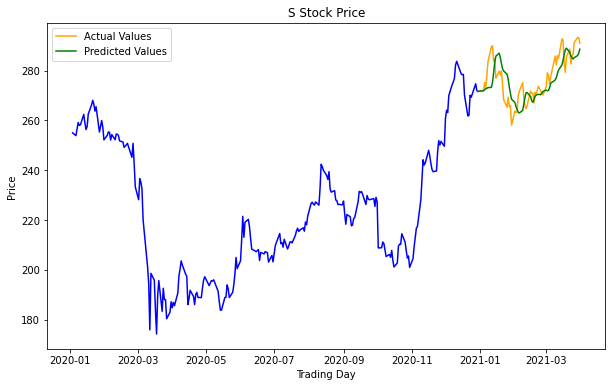

In [48]:
# Plot the S Stock Price comparison

plot_comparison(actual = S_actual, predicted = S_predicted, string = 'S Stock Price')

#### KCHOL Stock

In [49]:
# Get the data for this stock

KCHOL_Xtrain, KCHOL_Xtest, KCHOL_ytrain, KCHOL_ytest = variables_model(n = 1)

In [50]:
# Fit the model

KCHOL_pred = model_fit(Xtr = KCHOL_Xtrain, ytr = KCHOL_ytrain, Xte = KCHOL_Xtest)

Train on 244 samples
Epoch 1/100
244/244 [==============================] - 0s 227us/sample - loss: 0.0077
Epoch 2/100
244/244 [==============================] - 0s 231us/sample - loss: 0.0073
Epoch 3/100
244/244 [==============================] - 0s 228us/sample - loss: 0.0078
Epoch 4/100
244/244 [==============================] - 0s 333us/sample - loss: 0.0082
Epoch 5/100
244/244 [==============================] - 0s 258us/sample - loss: 0.0076
Epoch 6/100
244/244 [==============================] - 0s 240us/sample - loss: 0.0071
Epoch 7/100
244/244 [==============================] - 0s 316us/sample - loss: 0.0069
Epoch 8/100
244/244 [==============================] - 0s 249us/sample - loss: 0.0069
Epoch 9/100
244/244 [==============================] - 0s 298us/sample - loss: 0.0078
Epoch 10/100
244/244 [==============================] - 0s 304us/sample - loss: 0.0063
Epoch 11/100
244/244 [==============================] - 0s 330us/sample - loss: 0.0073
Epoch 12/100
244/244 [=========

244/244 [==============================] - 0s 311us/sample - loss: 0.0044
Epoch 96/100
244/244 [==============================] - 0s 360us/sample - loss: 0.0049
Epoch 97/100
244/244 [==============================] - 0s 322us/sample - loss: 0.0045
Epoch 98/100
244/244 [==============================] - 0s 341us/sample - loss: 0.0044
Epoch 99/100
244/244 [==============================] - 0s 331us/sample - loss: 0.0044
Epoch 100/100
244/244 [==============================] - 0s 301us/sample - loss: 0.0048


In [51]:
# Save the actual and predicted values in different data frames to plot

KCHOL_pred_prices = scaler_inverse(train_array = train['KCHOL_Price'].values, predictions = KCHOL_pred)

In [52]:
# Add the first column to the data frame that will store the predictions

predictions_df['KCHOL_Price'] = KCHOL_pred_prices

In [53]:
# Get the actual and predicted data as data frames for both

KCHOL_actual, KCHOL_predicted = df_merger(train_data = train['KCHOL_Price'], test_data = test['KCHOL_Price'], 
                                  pred_values = predictions_df['KCHOL_Price'])

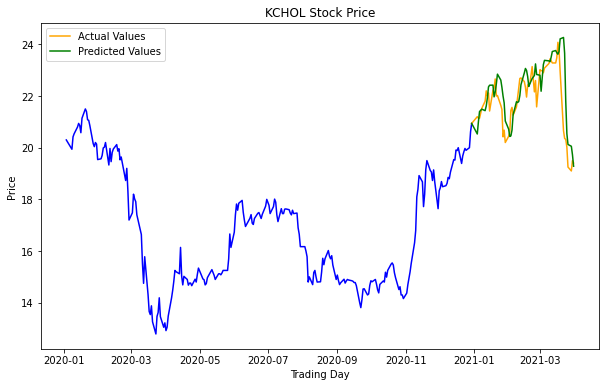

In [54]:
# Plot the Stock Price comparison

plot_comparison(actual = KCHOL_actual, predicted = KCHOL_predicted, string = 'KCHOL Stock Price')

#### M Stock

In [55]:
# Get the data for this stock

M_Xtrain, M_Xtest, M_ytrain, M_ytest = variables_model(n = 2)

In [56]:
# Fit the model

M_pred = model_fit(Xtr = M_Xtrain, ytr = M_ytrain, Xte = M_Xtest)

Train on 244 samples
Epoch 1/100
244/244 [==============================] - 0s 283us/sample - loss: 0.0027
Epoch 2/100
244/244 [==============================] - 0s 272us/sample - loss: 0.0033
Epoch 3/100
244/244 [==============================] - 0s 279us/sample - loss: 0.0032
Epoch 4/100
244/244 [==============================] - 0s 255us/sample - loss: 0.0029
Epoch 5/100
244/244 [==============================] - 0s 358us/sample - loss: 0.0032
Epoch 6/100
244/244 [==============================] - 0s 248us/sample - loss: 0.0031
Epoch 7/100
244/244 [==============================] - 0s 321us/sample - loss: 0.0024
Epoch 8/100
244/244 [==============================] - 0s 299us/sample - loss: 0.0029
Epoch 9/100
244/244 [==============================] - 0s 255us/sample - loss: 0.0027
Epoch 10/100
244/244 [==============================] - 0s 316us/sample - loss: 0.0029
Epoch 11/100
244/244 [==============================] - 0s 245us/sample - loss: 0.0028
Epoch 12/100
244/244 [=========

244/244 [==============================] - 0s 267us/sample - loss: 0.0025
Epoch 96/100
244/244 [==============================] - 0s 267us/sample - loss: 0.0031
Epoch 97/100
244/244 [==============================] - 0s 310us/sample - loss: 0.0023
Epoch 98/100
244/244 [==============================] - 0s 276us/sample - loss: 0.0023
Epoch 99/100
244/244 [==============================] - 0s 324us/sample - loss: 0.0026
Epoch 100/100
244/244 [==============================] - 0s 279us/sample - loss: 0.0025


In [57]:
# Save the actual and predicted values in different data frames to plot

M_pred_prices = scaler_inverse(train_array = train['M_Price'].values, predictions = M_pred)

In [58]:
# Add the first column to the data frame that will store the predictions

predictions_df['M_Price'] = M_pred_prices

In [59]:
# Get the actual and predicted data as data frames for both

M_actual, M_predicted = df_merger(train_data = train['M_Price'], test_data = test['M_Price'], 
                                  pred_values = predictions_df['M_Price'])

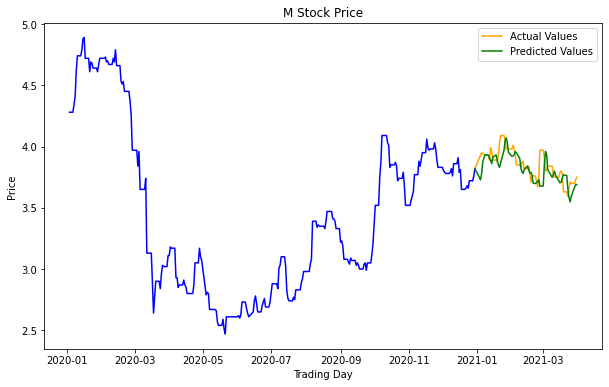

In [60]:
# Plot the Stock Price comparison

plot_comparison(actual = M_actual, predicted = M_predicted, string = 'M Stock Price')

#### BEEF Stock

In [61]:
# Get the data for this stock

BEEF_Xtrain, BEEF_Xtest, BEEF_ytrain, BEEF_ytest = variables_model(n = 3)

In [62]:
# Fit the model

BEEF_pred = model_fit(Xtr = BEEF_Xtrain, ytr = BEEF_ytrain, Xte = BEEF_Xtest)

Train on 244 samples
Epoch 1/100
244/244 [==============================] - 0s 241us/sample - loss: 0.0039
Epoch 2/100
244/244 [==============================] - 0s 240us/sample - loss: 0.0043
Epoch 3/100
244/244 [==============================] - 0s 307us/sample - loss: 0.0045
Epoch 4/100
244/244 [==============================] - 0s 227us/sample - loss: 0.0045
Epoch 5/100
244/244 [==============================] - 0s 231us/sample - loss: 0.0043
Epoch 6/100
244/244 [==============================] - 0s 226us/sample - loss: 0.0043
Epoch 7/100
244/244 [==============================] - 0s 229us/sample - loss: 0.0038
Epoch 8/100
244/244 [==============================] - 0s 293us/sample - loss: 0.0041
Epoch 9/100
244/244 [==============================] - 0s 344us/sample - loss: 0.0036
Epoch 10/100
244/244 [==============================] - 0s 305us/sample - loss: 0.0034
Epoch 11/100
244/244 [==============================] - 0s 286us/sample - loss: 0.0046
Epoch 12/100
244/244 [=========

244/244 [==============================] - 0s 312us/sample - loss: 0.0031
Epoch 96/100
244/244 [==============================] - 0s 344us/sample - loss: 0.0041
Epoch 97/100
244/244 [==============================] - 0s 322us/sample - loss: 0.0033
Epoch 98/100
244/244 [==============================] - 0s 376us/sample - loss: 0.0037
Epoch 99/100
244/244 [==============================] - 0s 298us/sample - loss: 0.0031
Epoch 100/100
244/244 [==============================] - 0s 309us/sample - loss: 0.0037


In [63]:
# Save the actual and predicted values in different data frames to plot

BEEF_pred_prices = scaler_inverse(train_array = train['BEEF_Price'].values, predictions = BEEF_pred)

In [64]:
# Add the first column to the data frame that will store the predictions

predictions_df['BEEF_Price'] = BEEF_pred_prices

In [65]:
# Get the actual and predicted data as data frames for both

BEEF_actual, BEEF_predicted = df_merger(train_data = train['BEEF_Price'], test_data = test['BEEF_Price'], 
                                  pred_values = predictions_df['BEEF_Price'])

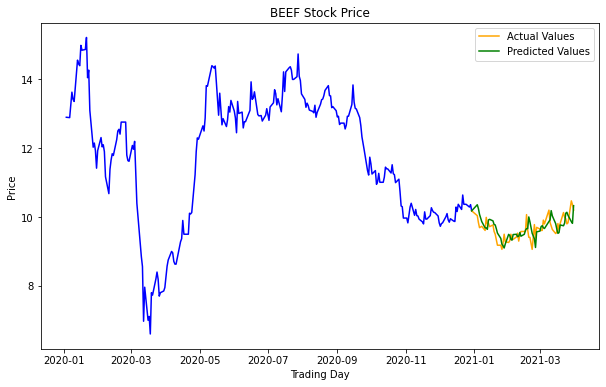

In [66]:
# Plot the Stock Price comparison

plot_comparison(actual = BEEF_actual, predicted = BEEF_predicted, string = 'BEEF Stock Price')

#### P Stock

In [67]:
# Get the data for this stock

P_Xtrain, P_Xtest, P_ytrain, P_ytest = variables_model(n = 4)

In [68]:
# Fit the model

P_pred = model_fit(Xtr = P_Xtrain, ytr = P_ytrain, Xte = P_Xtest)

Train on 244 samples
Epoch 1/100
244/244 [==============================] - 0s 257us/sample - loss: 0.0024
Epoch 2/100
244/244 [==============================] - 0s 334us/sample - loss: 0.0029
Epoch 3/100
244/244 [==============================] - 0s 327us/sample - loss: 0.0030
Epoch 4/100
244/244 [==============================] - 0s 386us/sample - loss: 0.0027
Epoch 5/100
244/244 [==============================] - 0s 470us/sample - loss: 0.0026
Epoch 6/100
244/244 [==============================] - 0s 347us/sample - loss: 0.0029s - loss: 0.002
Epoch 7/100
244/244 [==============================] - 0s 311us/sample - loss: 0.0025
Epoch 8/100
244/244 [==============================] - 0s 350us/sample - loss: 0.0030
Epoch 9/100
244/244 [==============================] - 0s 308us/sample - loss: 0.0030
Epoch 10/100
244/244 [==============================] - 0s 299us/sample - loss: 0.0022
Epoch 11/100
244/244 [==============================] - 0s 313us/sample - loss: 0.0025
Epoch 12/100
244

244/244 [==============================] - 0s 288us/sample - loss: 0.0030
Epoch 95/100
244/244 [==============================] - 0s 283us/sample - loss: 0.0031
Epoch 96/100
244/244 [==============================] - 0s 279us/sample - loss: 0.0025
Epoch 97/100
244/244 [==============================] - 0s 299us/sample - loss: 0.0029
Epoch 98/100
244/244 [==============================] - 0s 285us/sample - loss: 0.0023
Epoch 99/100
244/244 [==============================] - 0s 268us/sample - loss: 0.0021
Epoch 100/100
244/244 [==============================] - 0s 316us/sample - loss: 0.0023


In [69]:
# Save the actual and predicted values in different data frames to plot

P_pred_prices = scaler_inverse(train_array = train['P_Price'].values, predictions = P_pred)

In [70]:
# Add the first column to the data frame that will store the predictions

predictions_df['P_Price'] = P_pred_prices

In [71]:
# Get the actual and predicted data as data frames for both

P_actual, P_predicted = df_merger(train_data = train['P_Price'], test_data = test['P_Price'], 
                                  pred_values = predictions_df['P_Price'])

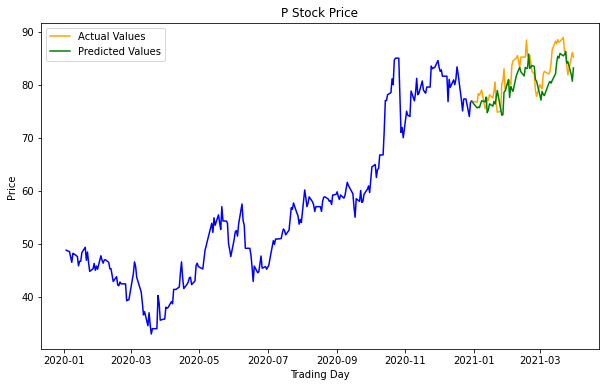

In [72]:
# Plot the Stock Price comparison

plot_comparison(actual = P_actual, predicted = P_predicted, string = 'P Stock Price')

#### C Stock

In [73]:
# Get the data for this stock

C_Xtrain, C_Xtest, C_ytrain, C_ytest = variables_model(n = 5)

In [74]:
# Fit the model

C_pred = model_fit(Xtr = C_Xtrain, ytr = C_ytrain, Xte = C_Xtest)

Train on 244 samples
Epoch 1/100
244/244 [==============================] - 0s 267us/sample - loss: 0.0018
Epoch 2/100
244/244 [==============================] - 0s 236us/sample - loss: 0.0021
Epoch 3/100
244/244 [==============================] - 0s 309us/sample - loss: 0.0023
Epoch 4/100
244/244 [==============================] - 0s 249us/sample - loss: 0.0017
Epoch 5/100
244/244 [==============================] - 0s 297us/sample - loss: 0.0017
Epoch 6/100
244/244 [==============================] - 0s 261us/sample - loss: 0.0017
Epoch 7/100
244/244 [==============================] - 0s 307us/sample - loss: 0.0020
Epoch 8/100
244/244 [==============================] - 0s 276us/sample - loss: 0.0017
Epoch 9/100
244/244 [==============================] - 0s 241us/sample - loss: 0.0019
Epoch 10/100
244/244 [==============================] - 0s 329us/sample - loss: 0.0017
Epoch 11/100
244/244 [==============================] - 0s 244us/sample - loss: 0.0021
Epoch 12/100
244/244 [=========

244/244 [==============================] - 0s 307us/sample - loss: 0.0016
Epoch 96/100
244/244 [==============================] - 0s 303us/sample - loss: 0.0017
Epoch 97/100
244/244 [==============================] - 0s 315us/sample - loss: 0.0017
Epoch 98/100
244/244 [==============================] - 0s 267us/sample - loss: 0.0014
Epoch 99/100
244/244 [==============================] - 0s 273us/sample - loss: 0.0013
Epoch 100/100
244/244 [==============================] - 0s 305us/sample - loss: 0.0015


In [75]:
# Save the actual and predicted values in different data frames to plot

C_pred_prices = scaler_inverse(train_array = train['C_Price'].values, predictions = C_pred)

In [76]:
# Add the first column to the data frame that will store the predictions

predictions_df['C_Price'] = C_pred_prices

In [77]:
# Get the actual and predicted data as data frames for both

C_actual, C_predicted = df_merger(train_data = train['C_Price'], test_data = test['C_Price'], 
                                  pred_values = predictions_df['C_Price'])

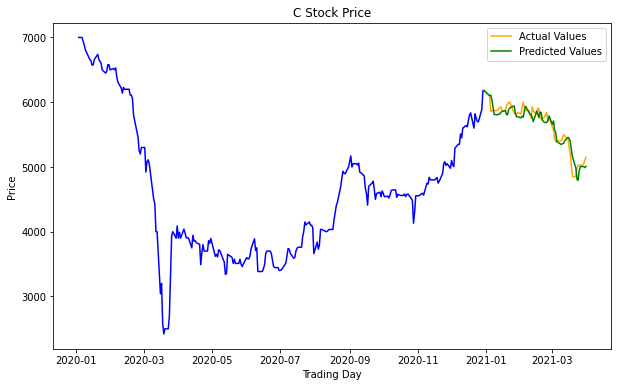

In [78]:
# Plot the Stock Price comparison

plot_comparison(actual = C_actual, predicted = C_predicted, string = 'C Stock Price')

#### IP Stock

In [79]:
# Get the data for this stock

IP_Xtrain, IP_Xtest, IP_ytrain, IP_ytest = variables_model(n = 6)

In [80]:
# Fit the model

IP_pred = model_fit(Xtr = IP_Xtrain, ytr = IP_ytrain, Xte = IP_Xtest)

Train on 244 samples
Epoch 1/100
244/244 [==============================] - 0s 246us/sample - loss: 0.0027
Epoch 2/100
244/244 [==============================] - 0s 258us/sample - loss: 0.0029
Epoch 3/100
244/244 [==============================] - 0s 312us/sample - loss: 0.0031
Epoch 4/100
244/244 [==============================] - 0s 252us/sample - loss: 0.0027
Epoch 5/100
244/244 [==============================] - 0s 309us/sample - loss: 0.0025
Epoch 6/100
244/244 [==============================] - 0s 245us/sample - loss: 0.0028
Epoch 7/100
244/244 [==============================] - 0s 328us/sample - loss: 0.0028
Epoch 8/100
244/244 [==============================] - 0s 239us/sample - loss: 0.0031
Epoch 9/100
244/244 [==============================] - 0s 265us/sample - loss: 0.0024
Epoch 10/100
244/244 [==============================] - 0s 260us/sample - loss: 0.0029
Epoch 11/100
244/244 [==============================] - 0s 326us/sample - loss: 0.0029
Epoch 12/100
244/244 [=========

244/244 [==============================] - 0s 276us/sample - loss: 0.0027
Epoch 96/100
244/244 [==============================] - 0s 258us/sample - loss: 0.0025
Epoch 97/100
244/244 [==============================] - 0s 324us/sample - loss: 0.0023
Epoch 98/100
244/244 [==============================] - 0s 310us/sample - loss: 0.0025
Epoch 99/100
244/244 [==============================] - 0s 320us/sample - loss: 0.0025
Epoch 100/100
244/244 [==============================] - 0s 283us/sample - loss: 0.0024


In [81]:
# Save the actual and predicted values in different data frames to plot

IP_pred_prices = scaler_inverse(train_array = train['IP_Price'].values, predictions = IP_pred)

In [82]:
# Add the first column to the data frame that will store the predictions

predictions_df['IP_Price'] = IP_pred_prices

In [83]:
# Get the actual and predicted data as data frames for both

IP_actual, IP_predicted = df_merger(train_data = train['IP_Price'], test_data = test['IP_Price'], 
                                  pred_values = predictions_df['IP_Price'])

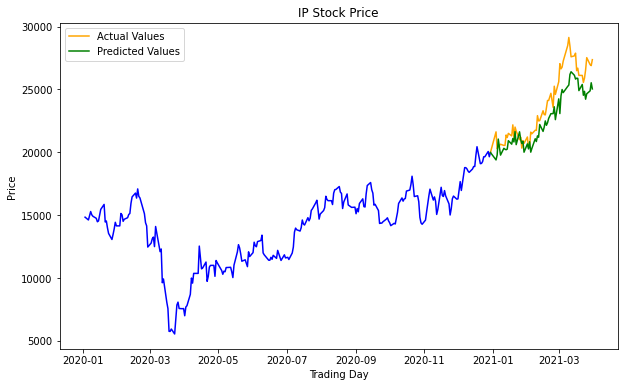

In [84]:
# Plot the Stock Price comparison

plot_comparison(actual = IP_actual, predicted = IP_predicted, string = 'IP Stock Price')

#### DS Stock

In [85]:
# Get the data for this stock

DS_Xtrain, DS_Xtest, DS_ytrain, DS_ytest = variables_model(n = 7)

In [86]:
# Fit the model

DS_pred = model_fit(Xtr = DS_Xtrain, ytr = DS_ytrain, Xte = DS_Xtest)

Train on 244 samples
Epoch 1/100
244/244 [==============================] - 0s 236us/sample - loss: 0.0026
Epoch 2/100
244/244 [==============================] - 0s 294us/sample - loss: 0.0027
Epoch 3/100
244/244 [==============================] - 0s 282us/sample - loss: 0.0029
Epoch 4/100
244/244 [==============================] - 0s 240us/sample - loss: 0.0023
Epoch 5/100
244/244 [==============================] - 0s 268us/sample - loss: 0.0025
Epoch 6/100
244/244 [==============================] - 0s 309us/sample - loss: 0.0023
Epoch 7/100
244/244 [==============================] - 0s 310us/sample - loss: 0.0025
Epoch 8/100
244/244 [==============================] - 0s 241us/sample - loss: 0.0025
Epoch 9/100
244/244 [==============================] - 0s 316us/sample - loss: 0.0026
Epoch 10/100
244/244 [==============================] - 0s 251us/sample - loss: 0.0022
Epoch 11/100
244/244 [==============================] - 0s 320us/sample - loss: 0.0024
Epoch 12/100
244/244 [=========

244/244 [==============================] - 0s 304us/sample - loss: 0.0027
Epoch 96/100
244/244 [==============================] - 0s 307us/sample - loss: 0.0028
Epoch 97/100
244/244 [==============================] - 0s 291us/sample - loss: 0.0029
Epoch 98/100
244/244 [==============================] - 0s 315us/sample - loss: 0.0028
Epoch 99/100
244/244 [==============================] - 0s 312us/sample - loss: 0.0025
Epoch 100/100
244/244 [==============================] - 0s 307us/sample - loss: 0.0026


In [87]:
# Save the actual and predicted values in different data frames to plot

DS_pred_prices = scaler_inverse(train_array = train['DS_Price'].values, predictions = DS_pred)

In [88]:
# Add the first column to the data frame that will store the predictions

predictions_df['DS_Price'] = DS_pred_prices

In [89]:
# Get the actual and predicted data as data frames for both

DS_actual, DS_predicted = df_merger(train_data = train['DS_Price'], test_data = test['DS_Price'], 
                                  pred_values = predictions_df['DS_Price'])

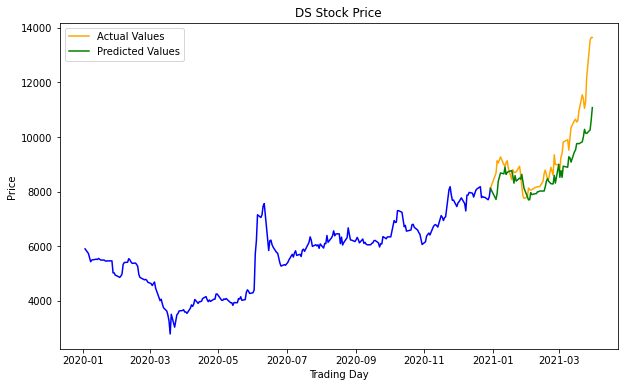

In [90]:
# Plot the Stock Price comparison

plot_comparison(actual = DS_actual, predicted = DS_predicted, string = 'DS Stock Price')

### SARIMAX

In [91]:
def arima_selection(values):
    model_autoARIMA = auto_arima(y = values, x = None, start_p = 1, d = None, start_q = 1, max_p = 11, max_d = 11,
                                max_q = 11, start_P = 1, D = None, start_Q = 1, max_P = 11, max_D = 11, max_Q = 11,
                                max_order = None, m = 5, alpha = 0.05, n_jobs = -1)
    return model_autoARIMA, model_autoARIMA.summary()


In [92]:
def model_fit_arima(df, col, order):
    
    warnings.filterwarnings('ignore')

    train_values = df['2020'][col].values

    test_values = df['2021'][col].values
    
    predictions = np.empty(shape = len(test_values))
    
    for i in range(len(test_values)):
        model = ARIMA(endog = train_values, order = order)
        model = model.fit()
        output = model.forecast()
        p = output[0]
        predictions[i] = p
        obs = test_values[i]
        train_values = np.append(train_values, obs)
        
    return predictions
        

In [93]:
pred_arima = pd.DataFrame()

pred_arima['Date'] = test.index

pred_arima.set_index('Date', inplace = True)

#### S Stock

In [94]:
# Get the best order to train the ARIMA model

arima_selection(values = train['S_Price'])

(ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(0, 0, 0, 5),
       suppress_warnings=True, with_intercept=False),
 <class 'statsmodels.iolib.summary.Summary'>
 """
                                SARIMAX Results                                
 Dep. Variable:                      y   No. Observations:                  250
 Model:               SARIMAX(0, 1, 0)   Log Likelihood                -747.842
 Date:                Mon, 14 Jun 2021   AIC                           1497.685
 Time:                        19:51:07   BIC                           1501.202
 Sample:                             0   HQIC                          1499.101
                                 - 250                                         
 Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
 ------------------------------------------------------------------------------
 sigma2        23.7810    

In [95]:
stock_prices.isna().sum()

S_Price         0
KCHOL_Price     9
M_Price        77
BEEF_Price     13
P_Price        22
C_Price        20
IP_Price       10
DS_Price       14
dtype: int64

In [96]:
# Use the function to predict the outcomes

S_pred_arima = model_fit_arima(df = stock_prices_daily, col = 'S_Price', order = (0,1,0))

In [97]:
# Save the predicted prices in a new column

pred_arima['S_Price'] = S_pred_arima

In [98]:
# Get the actual and predicted data as data frames for both

S_actual_arima, S_predicted_arima = df_merger(train_data = train['S_Price'], 
                                                      test_data = test['S_Price'], 
                                                      pred_values = pred_arima['S_Price'])

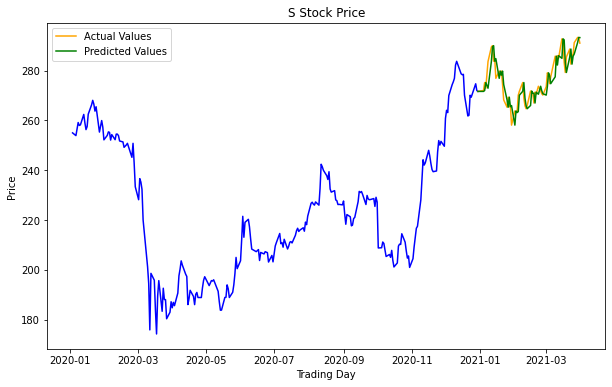

In [99]:
# Plot the Stock Price comparison

plot_comparison(actual = S_actual_arima, predicted = S_predicted_arima, string = 'S Stock Price')

#### KCHOL Stock

In [100]:
# Get the best order to train the ARIMA model

arima_selection(values = train['KCHOL_Price'])

(ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(0, 0, 0, 5),
       suppress_warnings=True, with_intercept=False),
 <class 'statsmodels.iolib.summary.Summary'>
 """
                                SARIMAX Results                                
 Dep. Variable:                      y   No. Observations:                  250
 Model:               SARIMAX(0, 1, 0)   Log Likelihood                -126.205
 Date:                Mon, 14 Jun 2021   AIC                            254.410
 Time:                        19:51:11   BIC                            257.927
 Sample:                             0   HQIC                           255.826
                                 - 250                                         
 Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
 ------------------------------------------------------------------------------
 sigma2         0.1613    

In [101]:
# Use the function to predict the outcomes

KCHOL_pred_arima = model_fit_arima(stock_prices_daily, col = 'KCHOL_Price', order = (0,1,0))

In [102]:
# Save the predicted prices in a new column

pred_arima['KCHOL_Price'] = KCHOL_pred_arima

In [103]:
# Get the actual and predicted data as data frames for both

KCHOL_actual_arima, KCHOL_predicted_arima = df_merger(train_data = train['KCHOL_Price'], 
                                                      test_data = test['KCHOL_Price'], 
                                                      pred_values = pred_arima['KCHOL_Price'])

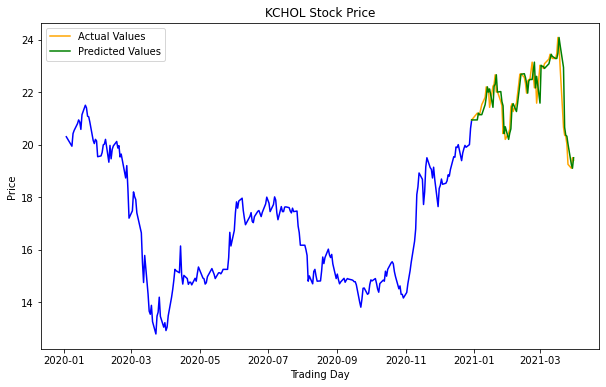

In [104]:
# Plot the Stock Price comparison

plot_comparison(actual = KCHOL_actual_arima, predicted = KCHOL_predicted_arima, string = 'KCHOL Stock Price')

#### M Stock

In [105]:
# Get the best order to train the ARIMA model

arima_selection(values = train['M_Price'])

(ARIMA(order=(0, 1, 4), scoring_args={}, seasonal_order=(0, 0, 0, 5),
       suppress_warnings=True, with_intercept=False),
 <class 'statsmodels.iolib.summary.Summary'>
 """
                                SARIMAX Results                                
 Dep. Variable:                      y   No. Observations:                  250
 Model:               SARIMAX(0, 1, 4)   Log Likelihood                 252.477
 Date:                Mon, 14 Jun 2021   AIC                           -494.954
 Time:                        19:51:24   BIC                           -477.366
 Sample:                             0   HQIC                          -487.875
                                 - 250                                         
 Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
 ------------------------------------------------------------------------------
 ma.L1          0.0498    

In [106]:
# Use the function to predict the outcomes

M_pred_arima = model_fit_arima(stock_prices_daily, col = 'M_Price', order = (0,1,4))

In [107]:
pred_arima['M_Price'] = M_pred_arima

In [108]:
# Get the actual and predicted data as data frames for both

M_actual_arima, M_predicted_arima = df_merger(train_data = train['M_Price'], test_data = test['M_Price'], 
                                  pred_values = pred_arima['M_Price'])

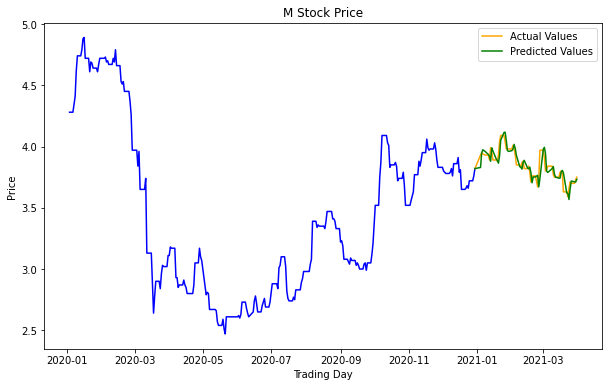

In [109]:
# Plot the Stock Price comparison

plot_comparison(actual = M_actual_arima, predicted = M_predicted_arima, string = 'M Stock Price')

#### BEEF Stock

In [110]:
# Get the best order to train the ARIMA model

arima_selection(values = train['BEEF_Price'])

(ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(0, 0, 0, 5),
       suppress_warnings=True, with_intercept=False),
 <class 'statsmodels.iolib.summary.Summary'>
 """
                                SARIMAX Results                                
 Dep. Variable:                      y   No. Observations:                  250
 Model:               SARIMAX(0, 1, 0)   Log Likelihood                -127.797
 Date:                Mon, 14 Jun 2021   AIC                            257.595
 Time:                        19:51:43   BIC                            261.112
 Sample:                             0   HQIC                           259.011
                                 - 250                                         
 Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
 ------------------------------------------------------------------------------
 sigma2         0.1634    

In [111]:
# Use the function to predict the outcomes

BEEF_pred_arima = model_fit_arima(stock_prices_daily, col = 'BEEF_Price', order = (0,1,0))

In [112]:
# Save prices in a column of the data frame

pred_arima['BEEF_Price'] = BEEF_pred_arima

In [113]:
# Get the actual and predicted data as data frames for both

BEEF_actual_arima, BEEF_predicted_arima = df_merger(train_data = train['BEEF_Price'], test_data = test['BEEF_Price'], 
                                  pred_values = pred_arima['BEEF_Price'])

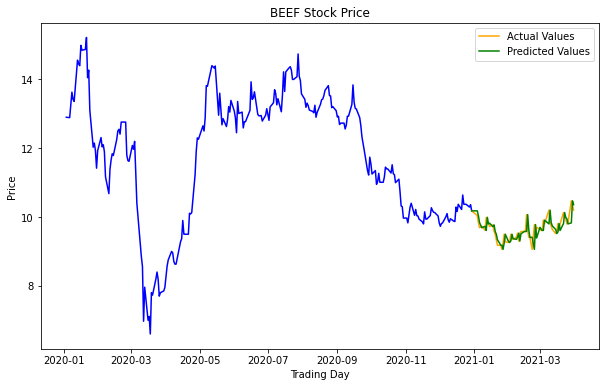

In [114]:
# Plot the Stock Price comparison

plot_comparison(actual = BEEF_actual_arima, predicted = BEEF_predicted_arima, string = 'BEEF Stock Price')

#### P Stock

In [115]:
# Get the best order to train the ARIMA model

arima_selection(values = train['P_Price'])

(ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(0, 0, 0, 5),
       suppress_warnings=True, with_intercept=False),
 <class 'statsmodels.iolib.summary.Summary'>
 """
                                SARIMAX Results                                
 Dep. Variable:                      y   No. Observations:                  250
 Model:               SARIMAX(0, 1, 0)   Log Likelihood                -522.848
 Date:                Mon, 14 Jun 2021   AIC                           1047.695
 Time:                        19:51:47   BIC                           1051.213
 Sample:                             0   HQIC                          1049.111
                                 - 250                                         
 Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
 ------------------------------------------------------------------------------
 sigma2         3.9028    

In [116]:
# Use the function to predict the outcomes

P_pred_arima = model_fit_arima(stock_prices_daily, col = 'P_Price', order = (0,1,0))

In [117]:
pred_arima['P_Price'] = P_pred_arima

In [118]:
# Get the actual and predicted data as data frames for both

P_actual_arima, P_predicted_arima = df_merger(train_data = train['P_Price'], test_data = test['P_Price'], 
                                  pred_values = pred_arima['P_Price'])

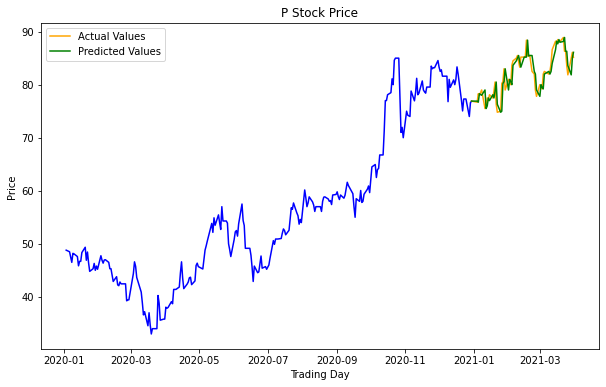

In [119]:
# Plot the Stock Price comparison

plot_comparison(actual = P_actual_arima, predicted = P_predicted_arima, string = 'P Stock Price')

#### C Stock

In [120]:
# Get the best order to train the ARIMA model

arima_selection(values = train['C_Price'])

(ARIMA(order=(2, 2, 1), scoring_args={}, seasonal_order=(0, 0, 0, 5),
       suppress_warnings=True, with_intercept=False),
 <class 'statsmodels.iolib.summary.Summary'>
 """
                                SARIMAX Results                                
 Dep. Variable:                      y   No. Observations:                  250
 Model:               SARIMAX(2, 2, 1)   Log Likelihood               -1593.351
 Date:                Mon, 14 Jun 2021   AIC                           3194.701
 Time:                        19:52:03   BIC                           3208.755
 Sample:                             0   HQIC                          3200.359
                                 - 250                                         
 Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
 ------------------------------------------------------------------------------
 ar.L1          0.0525    

In [121]:
# Use the function to predict the outcomes

C_pred_arima = model_fit_arima(stock_prices_daily, col = 'C_Price', order = (2,2,1))


In [122]:
# Save results in the predicted data frame

pred_arima['C_Price'] = C_pred_arima

In [123]:
# Get the actual and predicted data as data frames for both

C_actual_arima, C_predicted_arima = df_merger(train_data = train['C_Price'], test_data = test['C_Price'], 
                                  pred_values = pred_arima['C_Price'])

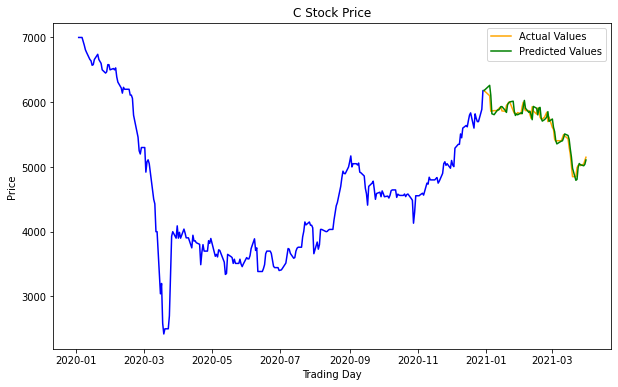

In [124]:
# Plot the Stock Price comparison

plot_comparison(actual = C_actual_arima, predicted = C_predicted_arima, string = 'C Stock Price')

#### IP Stock

In [125]:
# Get the best order to train the ARIMA model

arima_selection(values = train['IP_Price'])

(ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(0, 0, 1, 5),
       suppress_warnings=True, with_intercept=False),
 <class 'statsmodels.iolib.summary.Summary'>
 """
                                       SARIMAX Results                                      
 Dep. Variable:                                   y   No. Observations:                  250
 Model:             SARIMAX(0, 1, 0)x(0, 0, [1], 5)   Log Likelihood               -1964.063
 Date:                             Mon, 14 Jun 2021   AIC                           3932.126
 Time:                                     19:52:23   BIC                           3939.161
 Sample:                                          0   HQIC                          3934.957
                                              - 250                                         
 Covariance Type:                               opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
 -

In [126]:
# Use the function to predict the outcomes

IP_pred_arima = model_fit_arima(stock_prices_daily, col = 'IP_Price', order = (0,1,0))


In [127]:
pred_arima['IP_Price'] = IP_pred_arima

In [128]:
# Get the actual and predicted data as data frames for both

IP_actual_arima, IP_predicted_arima = df_merger(train_data = train['IP_Price'], test_data = test['IP_Price'], 
                                  pred_values = pred_arima['IP_Price'])

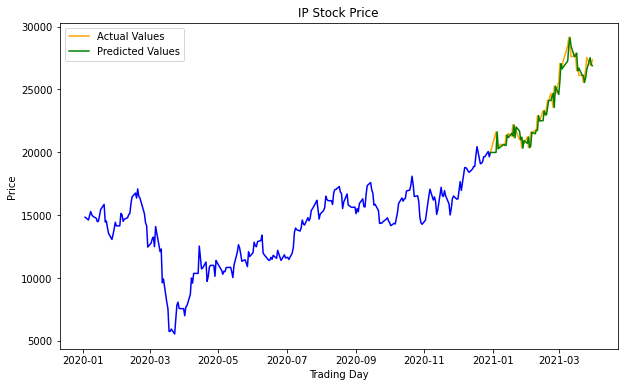

In [129]:
# Plot the Stock Price comparison

plot_comparison(actual = IP_actual_arima, predicted = IP_predicted_arima, string = 'IP Stock Price')

#### DS Stock

In [130]:
# Get the best order to train the ARIMA model

arima_selection(values = train['DS_Price'])

(ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(0, 0, 0, 5),
       suppress_warnings=True, with_intercept=False),
 <class 'statsmodels.iolib.summary.Summary'>
 """
                                SARIMAX Results                                
 Dep. Variable:                      y   No. Observations:                  250
 Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1711.671
 Date:                Mon, 14 Jun 2021   AIC                           3425.341
 Time:                        19:52:26   BIC                           3428.859
 Sample:                             0   HQIC                          3426.757
                                 - 250                                         
 Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
 ------------------------------------------------------------------------------
 sigma2      5.475e+04   1

In [131]:
# Use the function to predict the outcomes

DS_pred_arima = model_fit_arima(stock_prices_daily, col = 'DS_Price', order = (0,1,0))


In [132]:
pred_arima['DS_Price'] = DS_pred_arima

In [133]:
# Get the actual and predicted data as data frames for both

DS_actual_arima, DS_predicted_arima = df_merger(train_data = train['DS_Price'], test_data = test['DS_Price'], 
                                  pred_values = pred_arima['DS_Price'])

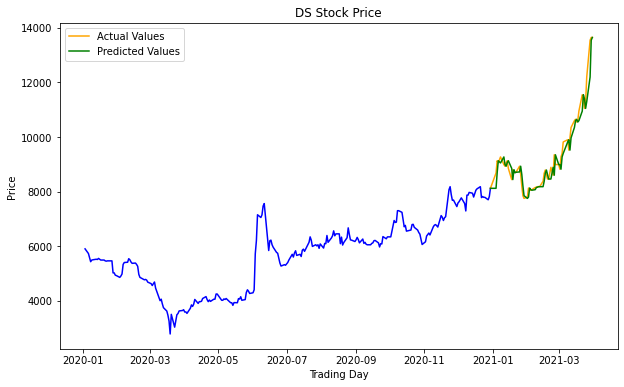

In [134]:
# Plot the Stock Price comparison

plot_comparison(actual = DS_actual_arima, predicted = DS_predicted_arima, string = 'DS Stock Price')

## Model Evaluation

In [135]:
def capital_gain_predicted_prices(df1, df2):
    # Define the total capital gain as the final value minus the initial value divided by the initial value
    actual_returns = (df1[-1] - df1[0])/df1[0]
    # Predicted returns 
    predicted_returns = (df2[-1] - df2[0])/df2[0]
    # Show the value as percentage
    actual_returns = round(actual_returns*100,2)
    predicted_returns = round(predicted_returns*100, 2)
    print('The actual returns had a value of {}% and the predicted returns had a value {}%'.format(actual_returns, 
                                                                                                predicted_returns))

In [136]:
# Define a function for the Bollinger brands

def bollinger_bands(df, col, p, std):
    # Create a new data frame just to use in the function to plot the upper, and lower bound with the moving average
    # and the closing price
    bollinger_df = pd.DataFrame()
    #Establish the serie to use the rolling function
    bollinger_df[col] = df[col].astype(int)
    # Define number of periods
    period = p
    # Apply the rolling function for the moving average
    bollinger_df['SMA'] = bollinger_df.rolling(window = period).mean()
    # Calculate the Standard Deviation
    bollinger_df['std'] = bollinger_df[col].rolling(window = period).std()
    # Establish the upper border
    bollinger_df['upper'] = bollinger_df['SMA'] + (bollinger_df['std'] * std)
    # Establish the lower border
    bollinger_df['lower'] = bollinger_df['SMA'] - (bollinger_df['std'] * std)
    
    # Define the conditions to make the buy/sell recommendations
    buy_signal = []
    sell_signal = []
    
    # Start a for loop
    for i in range(len(bollinger_df[col])):
        if bollinger_df[col][i] > bollinger_df['upper'][i]: # This is the condition for sell recommendation 
            buy_signal.append(np.nan)
            sell_signal.append(bollinger_df[col][i])
        elif bollinger_df[col][i] < bollinger_df['lower'][i]: # This is the condition for buy recommendation
            buy_signal.append(bollinger_df[col][i])
            sell_signal.append(np.nan)
        else: # If none of the conditions are met, then no recommendation is given
            buy_signal.append(np.nan)
            sell_signal.append(np.nan)
    # Add the recommendations as a columns in the data frame
    bollinger_df['buy'] = buy_signal
    bollinger_df['sell'] = sell_signal
    
    # Plot the bollinger bands in order to make the sell and buy recommendations
    fig = plt.figure(figsize = (20,12))
    # Add subplot
    ax = fig.add_subplot(1,1,1)
    # Get the index
    x_axis = bollinger_df.index
    # Plot the shade area between the upper and the lower bound
    ax.fill_between(x_axis, bollinger_df['upper'], bollinger_df['lower'], color = 'grey')
    # Plot the closing price, moving average and buy and sell recommendations
    ax.plot(x_axis, bollinger_df[col], color = 'gold', lw = 3, label = 'Price')
    ax.plot(x_axis, bollinger_df['SMA'], color = 'blue', lw = 3, label = 'Moving Averag')
    ax.scatter(x_axis, bollinger_df['buy'], color = 'green', lw = 3, marker = '^', label = 'Buy', s = 100)
    ax.scatter(x_axis, bollinger_df['sell'], color = 'red', lw = 3, marker = 'v', label = 'Sell', s = 100)
    # Set the axis
    ax.set_title('Bollinger bands for {}'.format(col))
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    plt.xticks(rotation = 45)
    ax.legend(loc = (1.02, 0.6))
    return plt.show()


In [137]:
# Get a data frame that stores the train and predicted data frame for the bollinger bands

predicted_df = merge_df(df1 = S_predicted, df2 = KCHOL_predicted, df3 = M_predicted, df4 = BEEF_predicted, 
                        df5 = P_predicted, df6 = C_predicted, df7 = IP_predicted, df8 = DS_predicted)

### LSTM

#### S_Stock

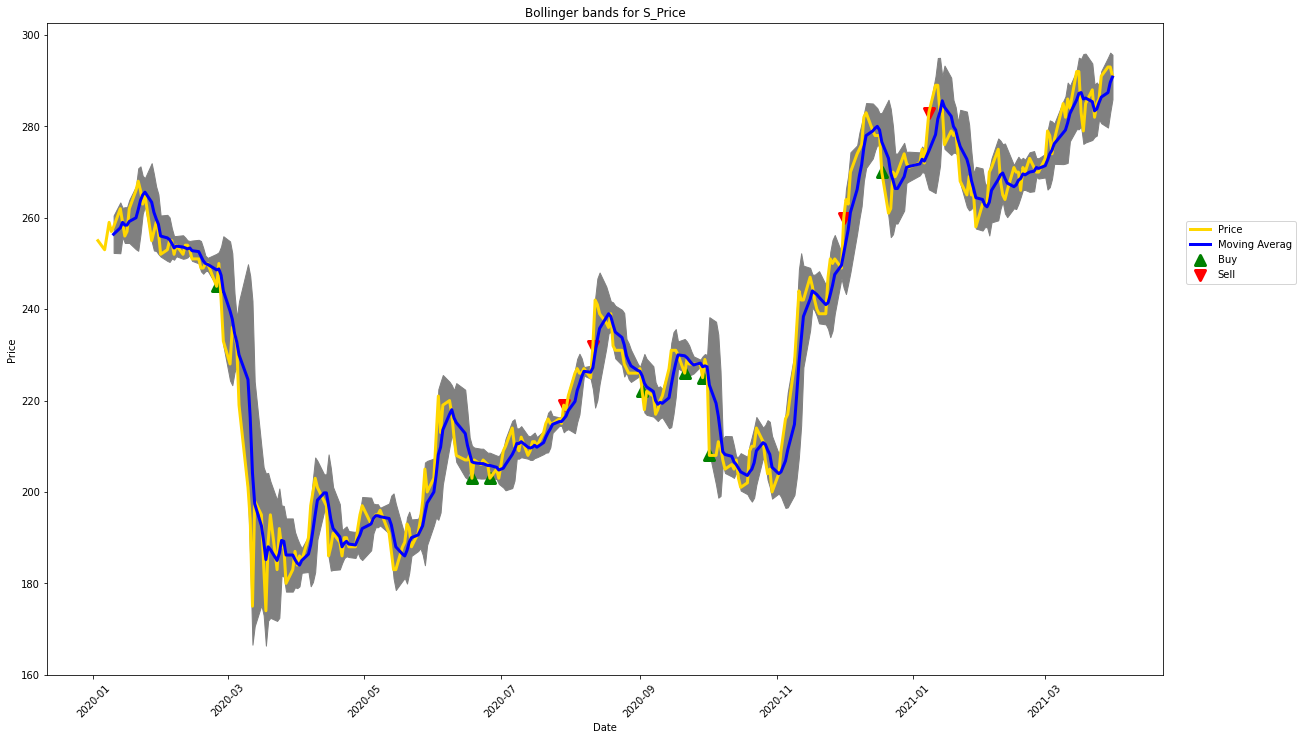

In [138]:
# Bollinger bands for the actual data daily

bollinger_bands(df = stock_prices_daily, col = 'S_Price', p = 5, std = 1.7)

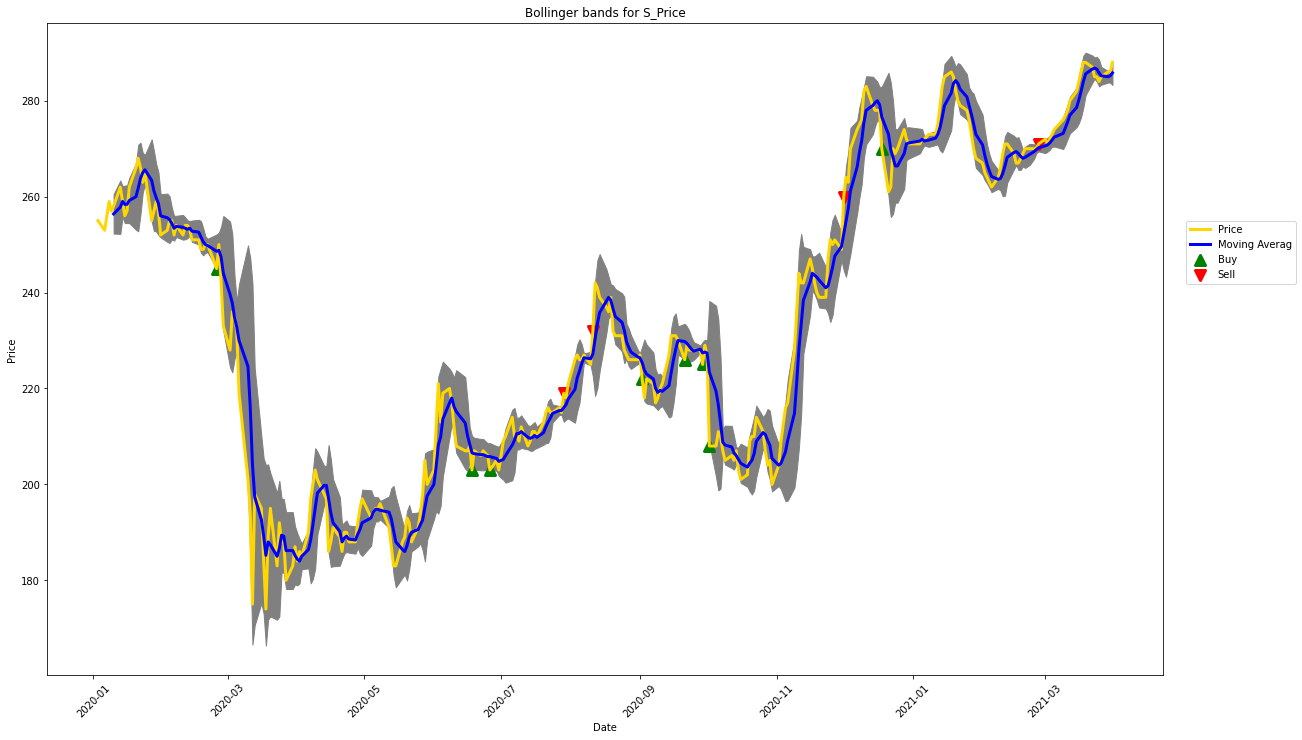

In [139]:
# Bollinger bands for the actual data daily

bollinger_bands(df = predicted_df, col = 'S_Price', p = 5, std = 1.7)

In [140]:
# Check the actual vs the predicted returns

capital_gain_predicted_prices(df1 = test['S_Price'], df2 = predictions_df['S_Price'])

The actual returns had a value of 6.99% and the predicted returns had a value 6.15%


#### KCHOL Stock

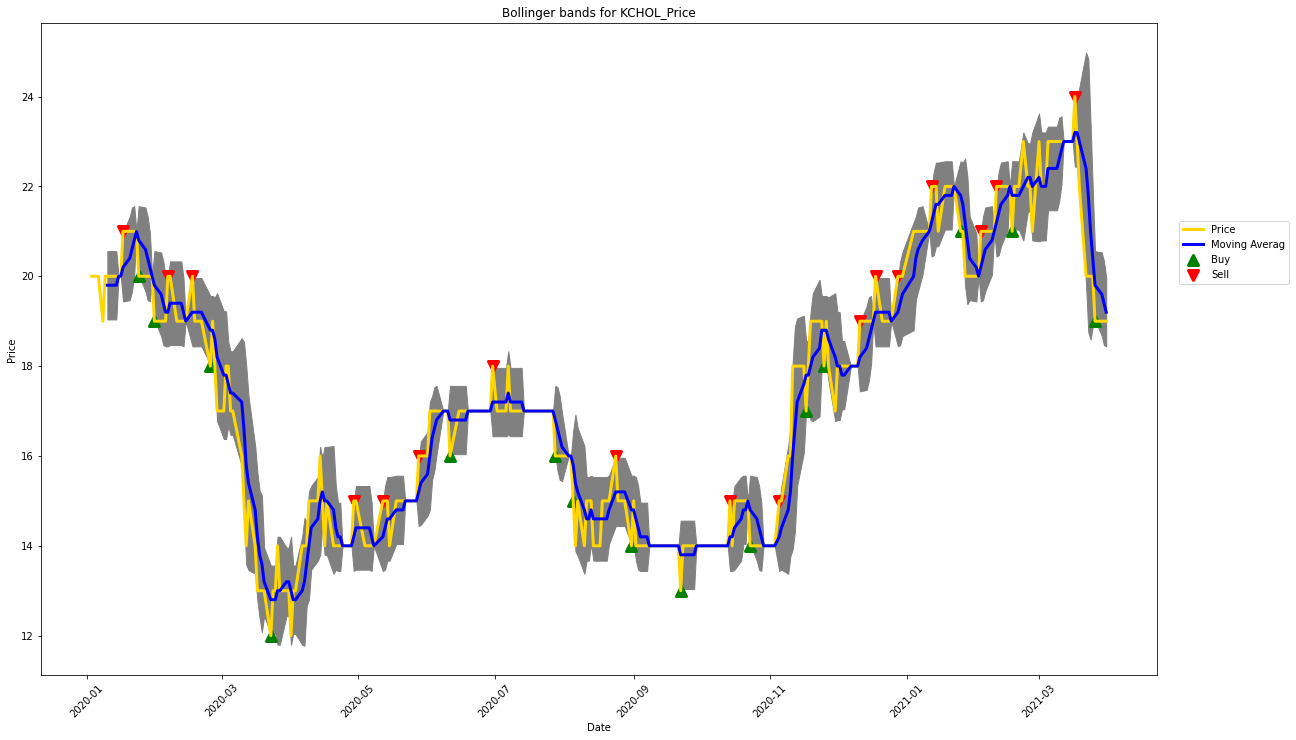

In [141]:
# Bollinger bands for the actual data daily

bollinger_bands(df = stock_prices_daily, col = 'KCHOL_Price', p = 5, std = 1.7)

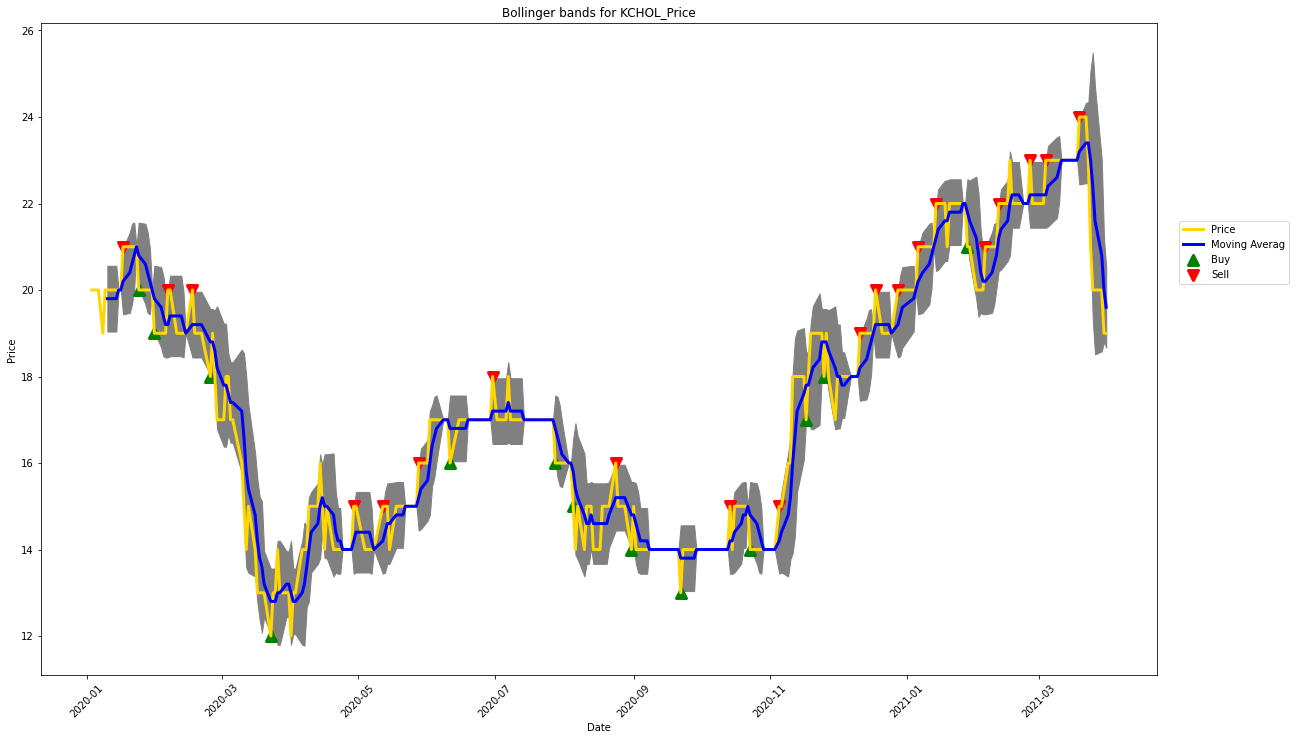

In [142]:
# Bollinger bands for the actual data daily

bollinger_bands(df = predicted_df, col = 'KCHOL_Price', p = 5, std = 1.7)

In [143]:
# Check the actual vs the predicted returns

capital_gain_predicted_prices(df1 = test['KCHOL_Price'], df2 = predictions_df['KCHOL_Price'])

The actual returns had a value of -8.44% and the predicted returns had a value -6.08%


#### M Stock

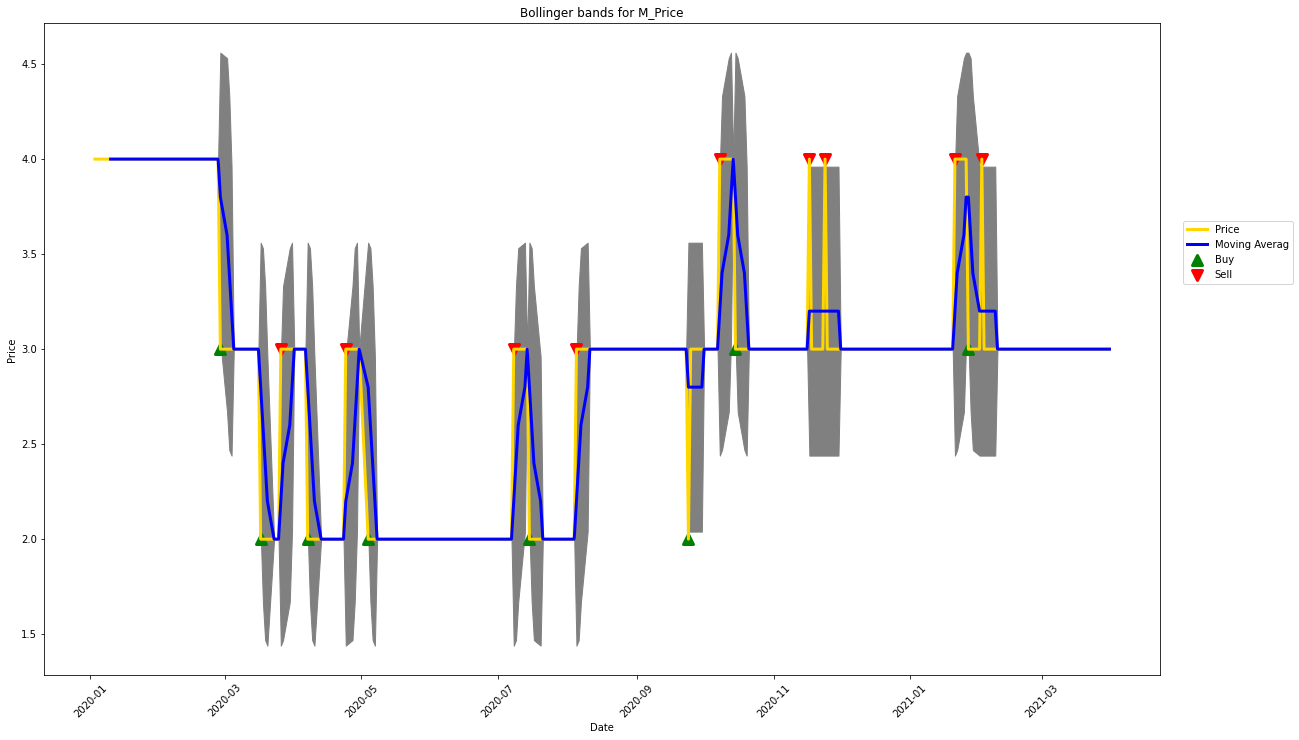

In [144]:
# Bollinger bands for the actual data daily

bollinger_bands(df = stock_prices_daily, col = 'M_Price', p = 5, std = 1.7)

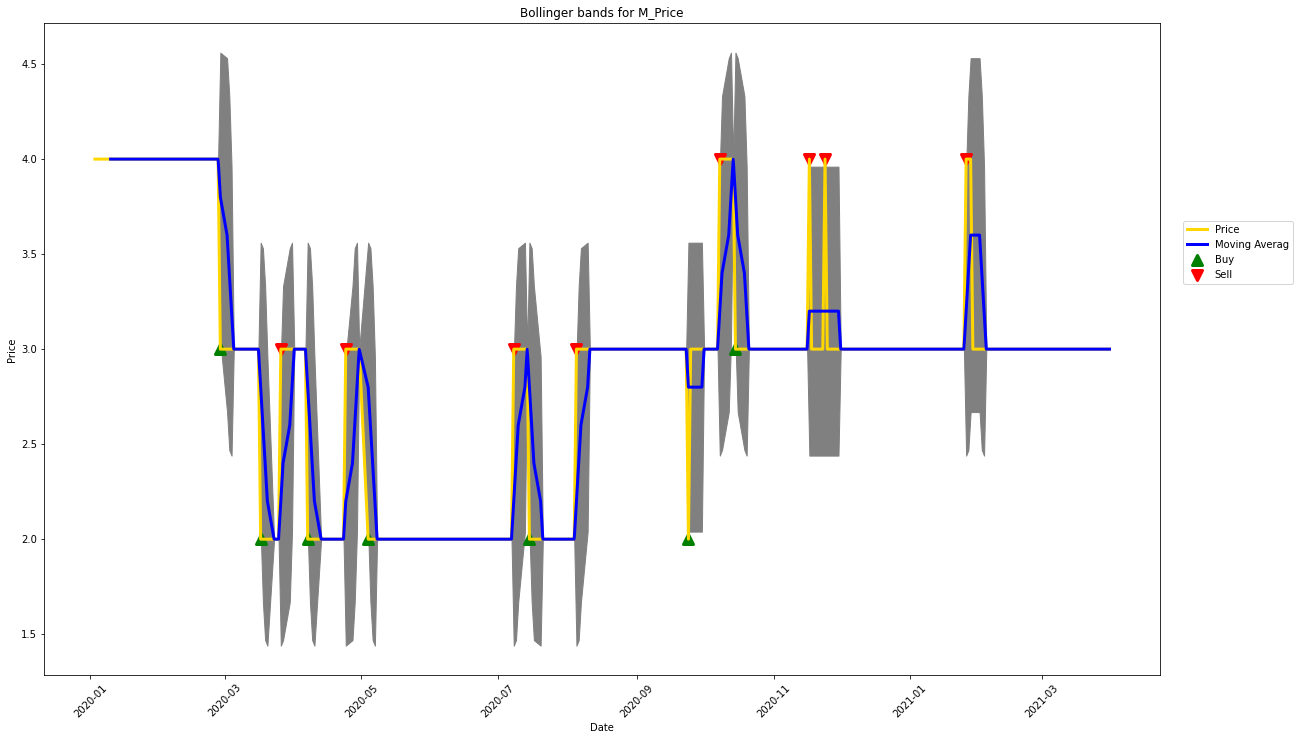

In [145]:
# Bollinger bands for the actual data daily

bollinger_bands(df = predicted_df, col = 'M_Price', p = 5, std = 1.7)

In [146]:
# Check the actual vs the predicted returns

capital_gain_predicted_prices(df1 = test['M_Price'], df2 = predictions_df['M_Price'])

The actual returns had a value of -4.58% and the predicted returns had a value -1.05%


#### BEEF Stock

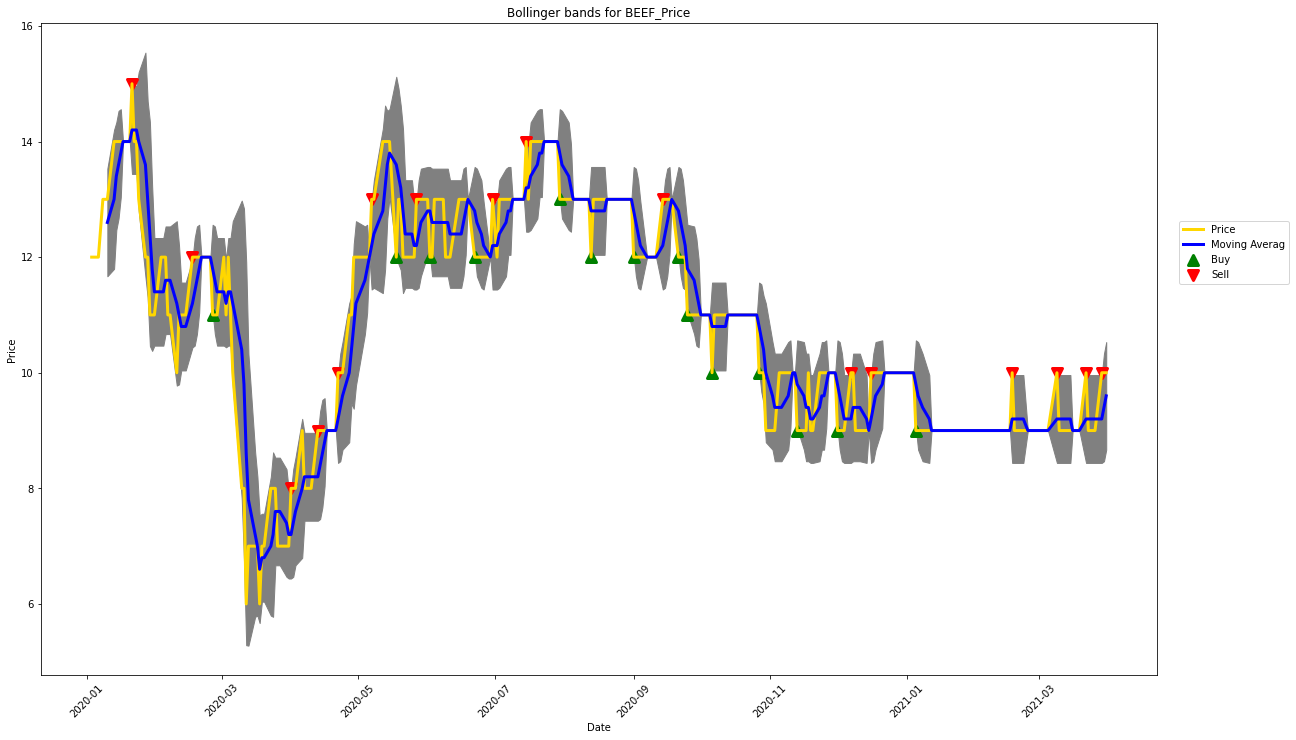

In [147]:
# Bollinger bands for the actual data daily

bollinger_bands(df = stock_prices_daily, col = 'BEEF_Price', p = 5, std = 1.7)

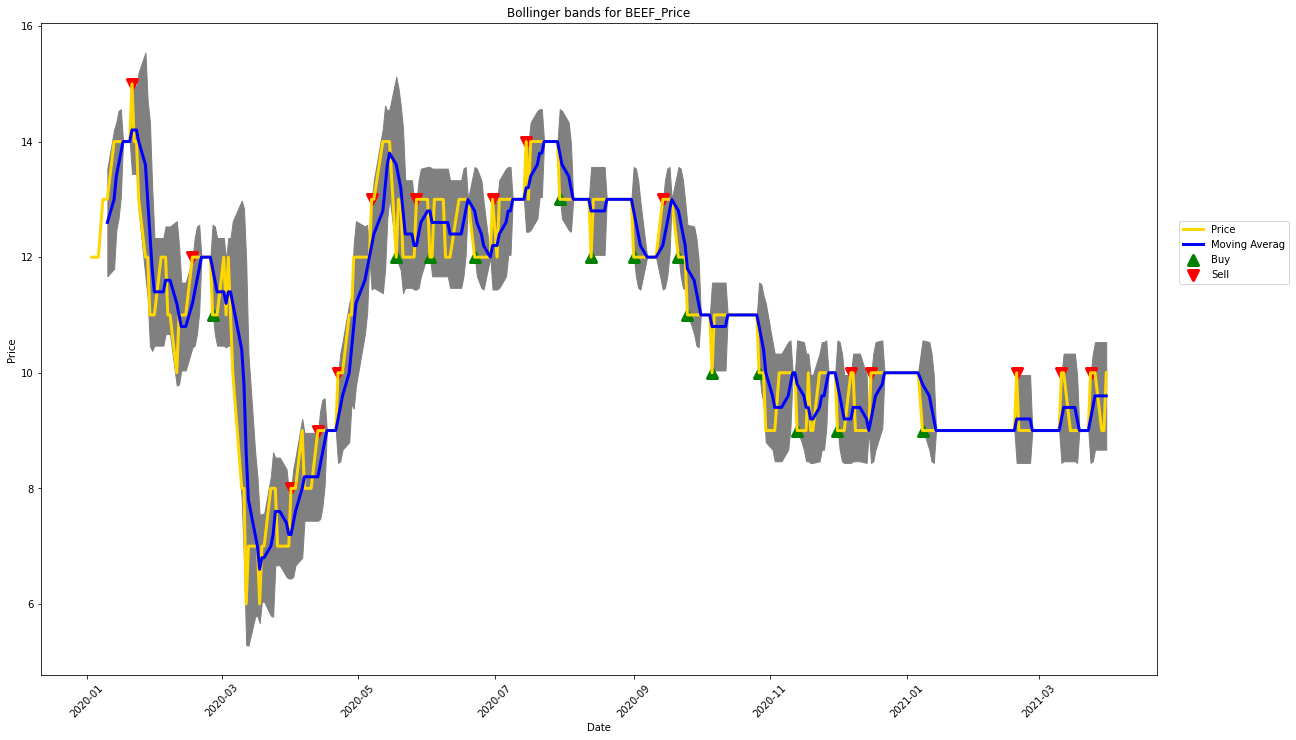

In [148]:
# Bollinger bands for the actual data daily

bollinger_bands(df = predicted_df, col = 'BEEF_Price', p = 5, std = 1.7)

In [149]:
# Check the actual vs the predicted returns

capital_gain_predicted_prices(df1 = test['BEEF_Price'], df2 = predictions_df['BEEF_Price'])

The actual returns had a value of 1.59% and the predicted returns had a value -0.27%


#### P Stock

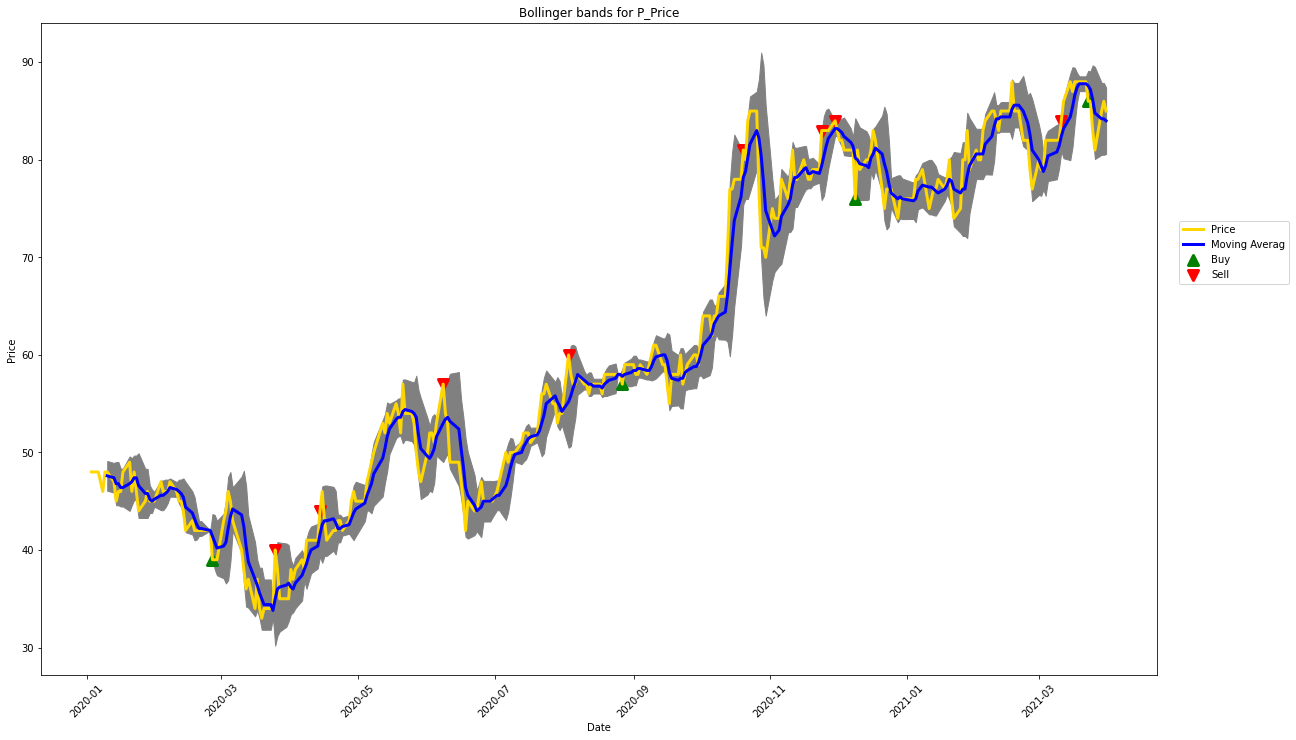

In [150]:
# Bollinger bands for the actual data daily

bollinger_bands(df = stock_prices_daily, col = 'P_Price', p = 5, std = 1.7)

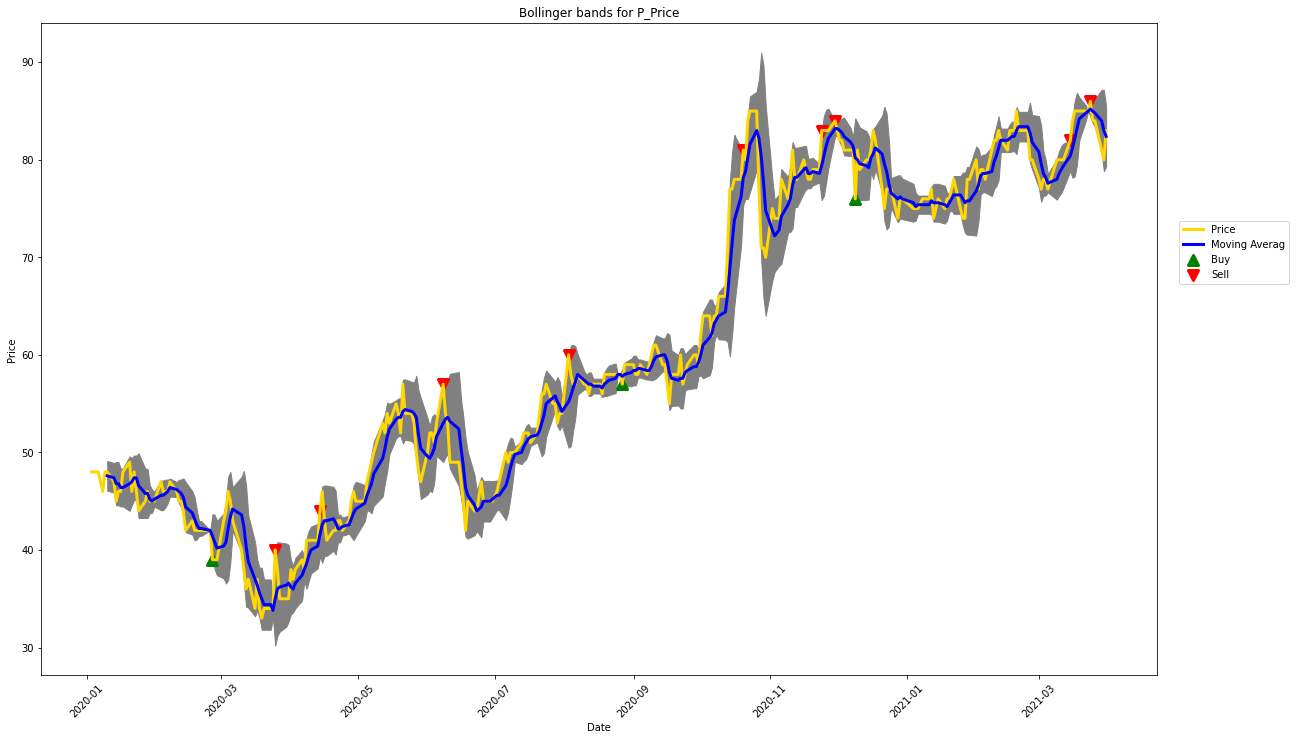

In [151]:
# Bollinger bands for the actual data daily

bollinger_bands(df = predicted_df, col = 'P_Price', p = 5, std = 1.7)

In [152]:
# Check the actual vs the predicted returns

capital_gain_predicted_prices(df1 = test['P_Price'], df2 = predictions_df['P_Price'])

The actual returns had a value of 11.02% and the predicted returns had a value 9.98%


#### C Stock

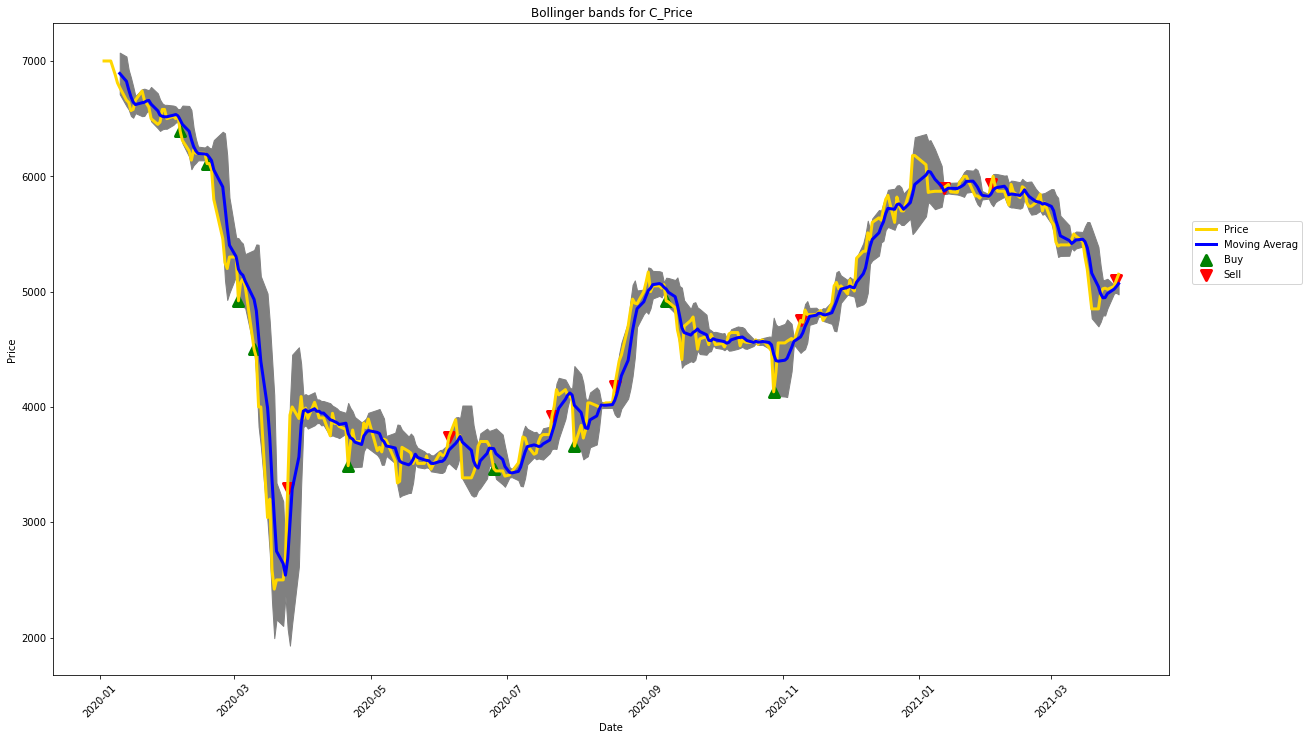

In [153]:
# Bollinger bands for the actual data daily

bollinger_bands(df = stock_prices_daily, col = 'C_Price', p = 5, std = 1.7)

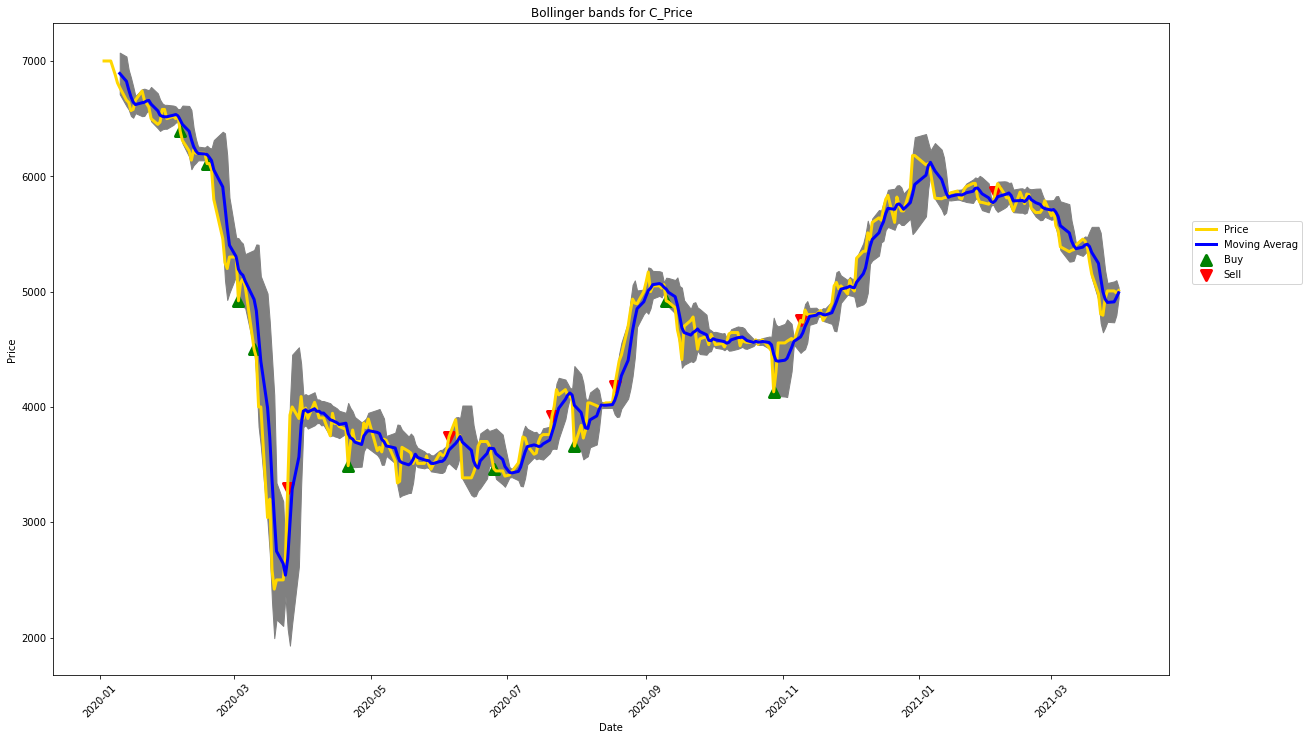

In [154]:
# Bollinger bands for the actual data daily

bollinger_bands(df = predicted_df, col = 'C_Price', p = 5, std = 1.7)

In [155]:
# Check the actual vs the predicted returns

capital_gain_predicted_prices(df1 = test['C_Price'], df2 = predictions_df['C_Price'])

The actual returns had a value of -15.57% and the predicted returns had a value -17.87%


#### IP Stock

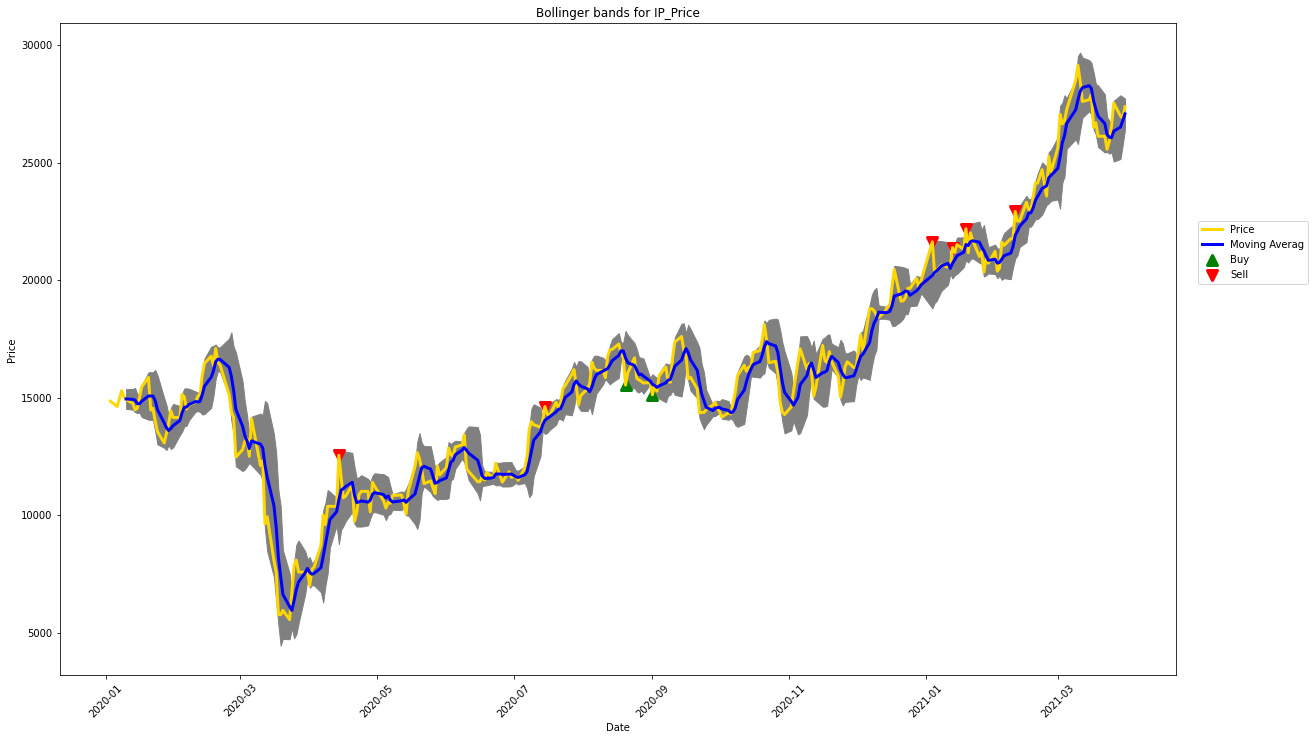

In [156]:
# Bollinger bands for the actual data daily

bollinger_bands(df = stock_prices_daily, col = 'IP_Price', p = 5, std = 1.7)

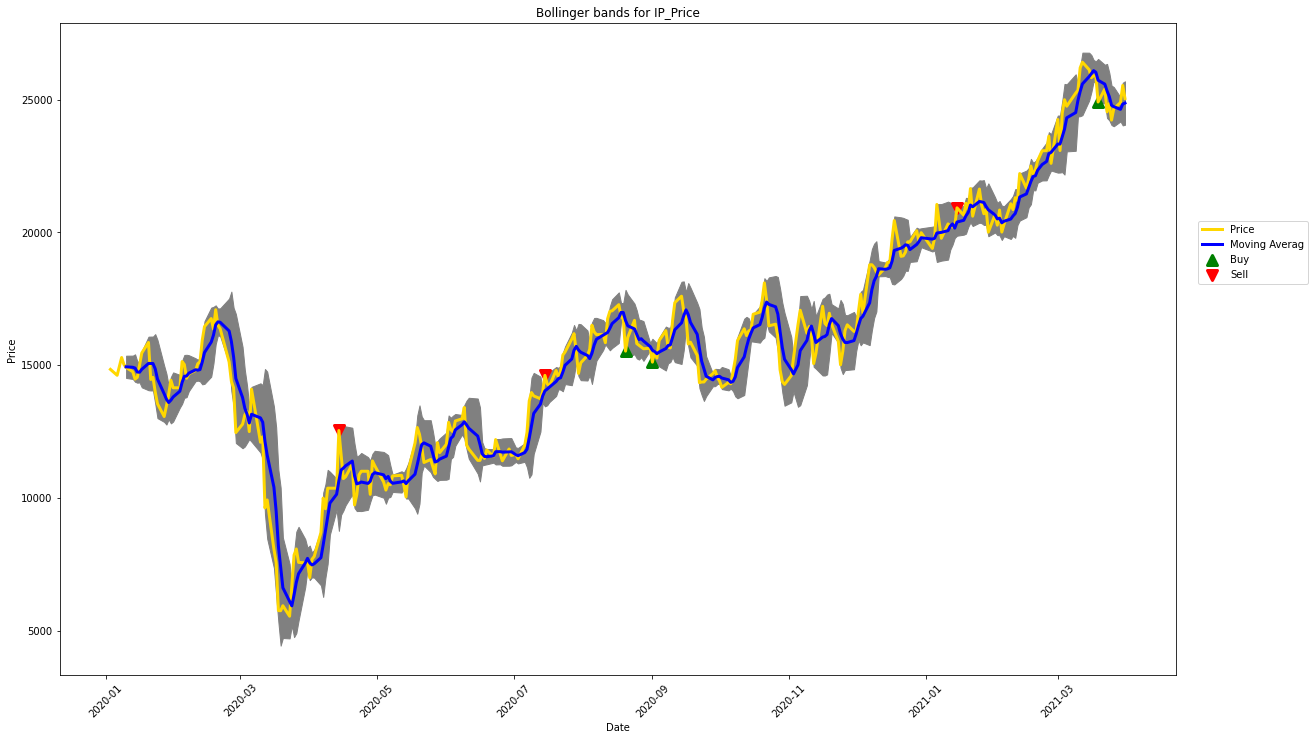

In [157]:
# Bollinger bands for the actual data daily

bollinger_bands(df = predicted_df, col = 'IP_Price', p = 5, std = 1.7)

In [158]:
# Check the actual vs the predicted returns

capital_gain_predicted_prices(df1 = test['IP_Price'], df2 = predictions_df['IP_Price'])

The actual returns had a value of 26.56% and the predicted returns had a value 29.12%


#### DS Stock

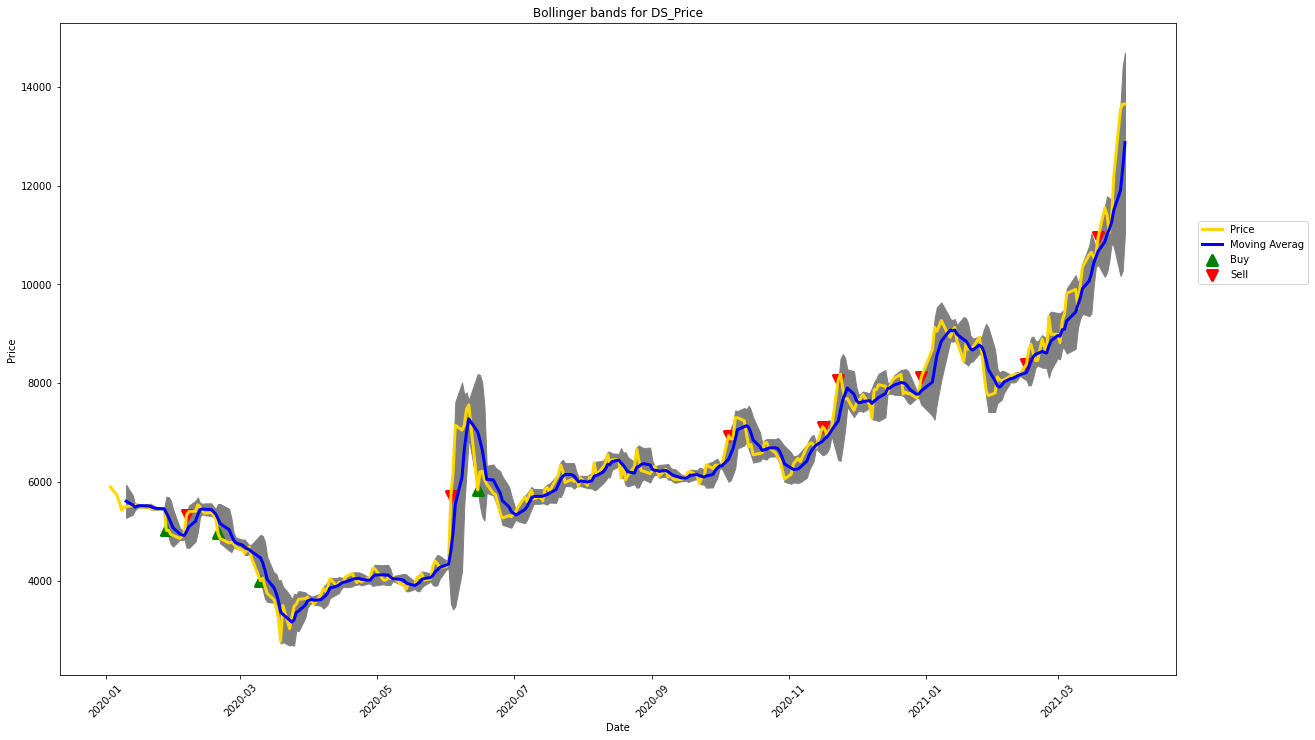

In [159]:
# Bollinger bands for the actual data daily

bollinger_bands(df = stock_prices_daily, col = 'DS_Price', p = 5, std = 1.7)

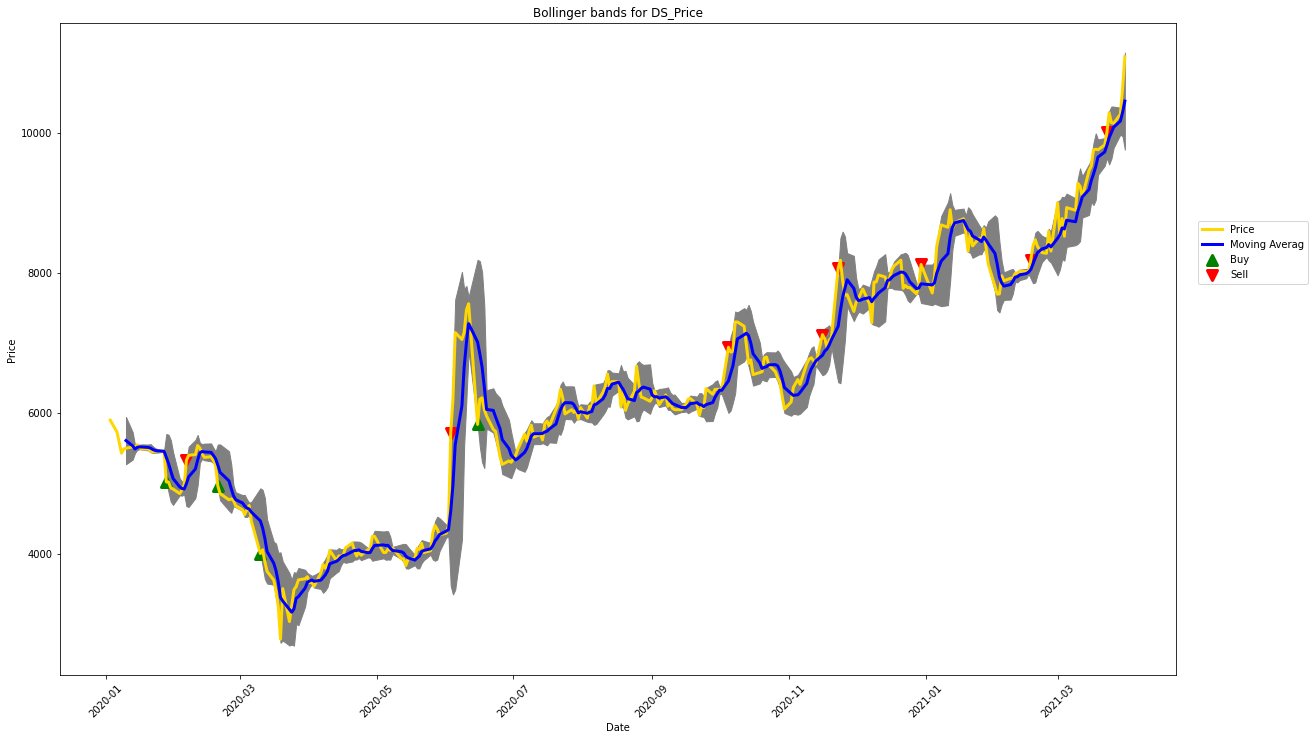

In [160]:
# Bollinger bands for the actual data daily

bollinger_bands(df = predicted_df, col = 'DS_Price', p = 5, std = 1.7)

In [161]:
# Check the actual vs the predicted returns

capital_gain_predicted_prices(df1 = test['DS_Price'], df2 = predictions_df['DS_Price'])

The actual returns had a value of 57.26% and the predicted returns had a value 43.63%


### ARIMA

In [162]:
# Get a data frame that stores the train and predicted data frame for the bollinger bands

predicted_df_arima = merge_df(df1 = S_predicted_arima, df2 = KCHOL_predicted_arima, df3 = M_predicted_arima, 
                        df4 = BEEF_predicted_arima, df5 = P_predicted_arima, df6 = C_predicted_arima, 
                        df7 = IP_predicted_arima, df8 = DS_predicted_arima)

#### S Stock

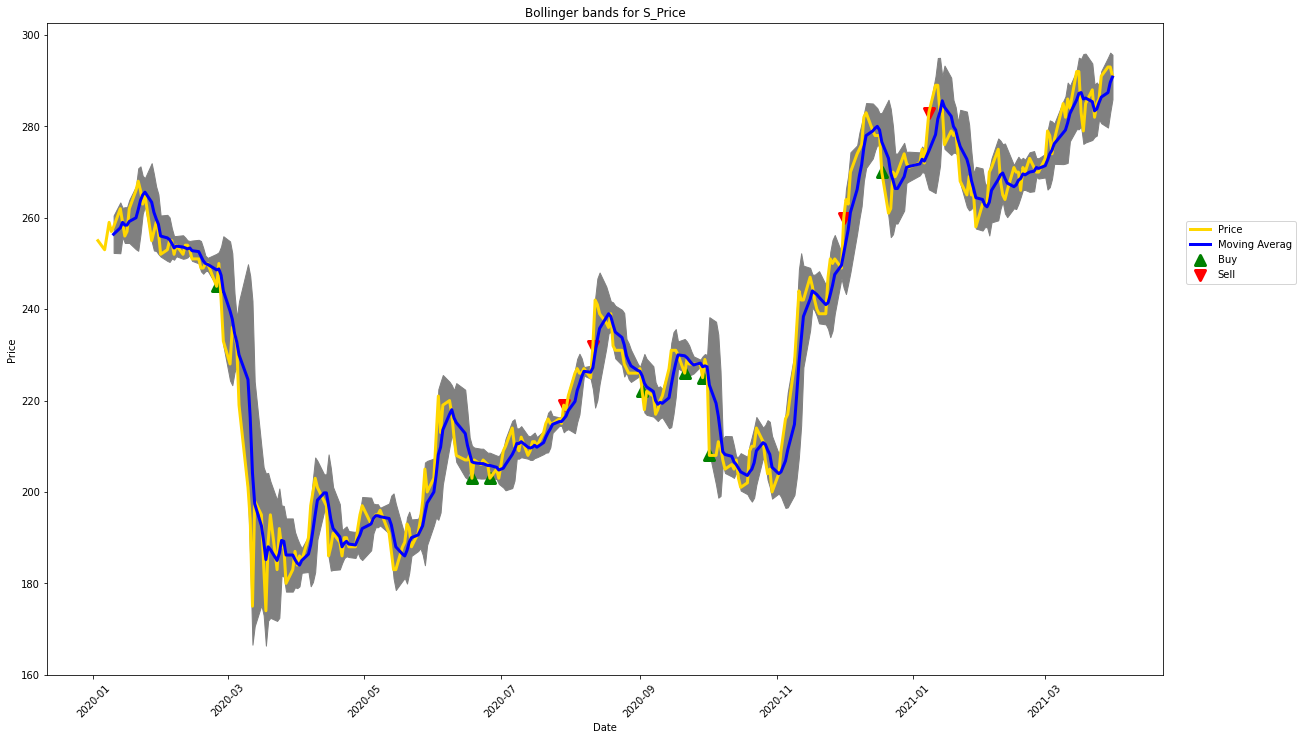

In [163]:
# Bollinger bands for the actual data daily

bollinger_bands(df = stock_prices_daily, col = 'S_Price', p = 5, std = 1.7)

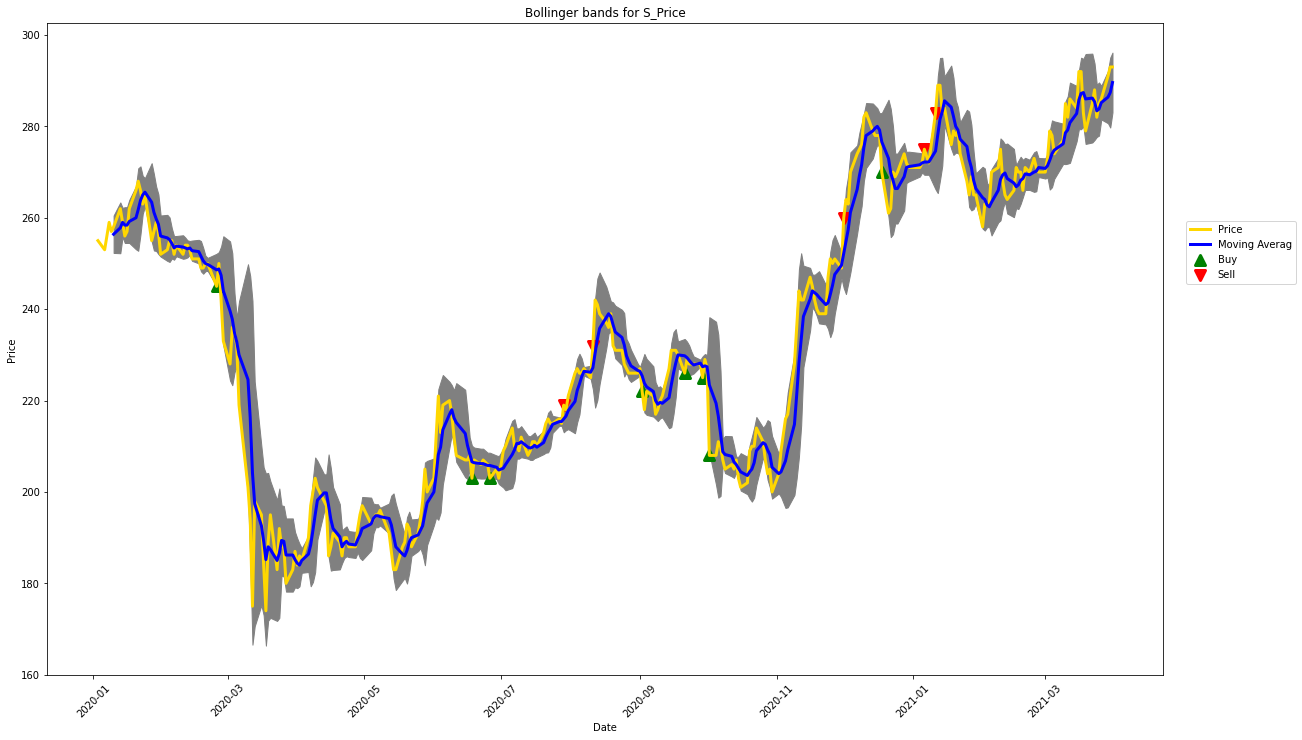

In [164]:
# Bollinger bands for the actual data daily

bollinger_bands(df = predicted_df_arima, col = 'S_Price', p = 5, std = 1.7)

In [165]:
# Check the actual vs the predicted returns

capital_gain_predicted_prices(df1 = test['S_Price'], df2 = pred_arima['S_Price'])

The actual returns had a value of 6.99% and the predicted returns had a value 7.95%


#### KCHOL Stock

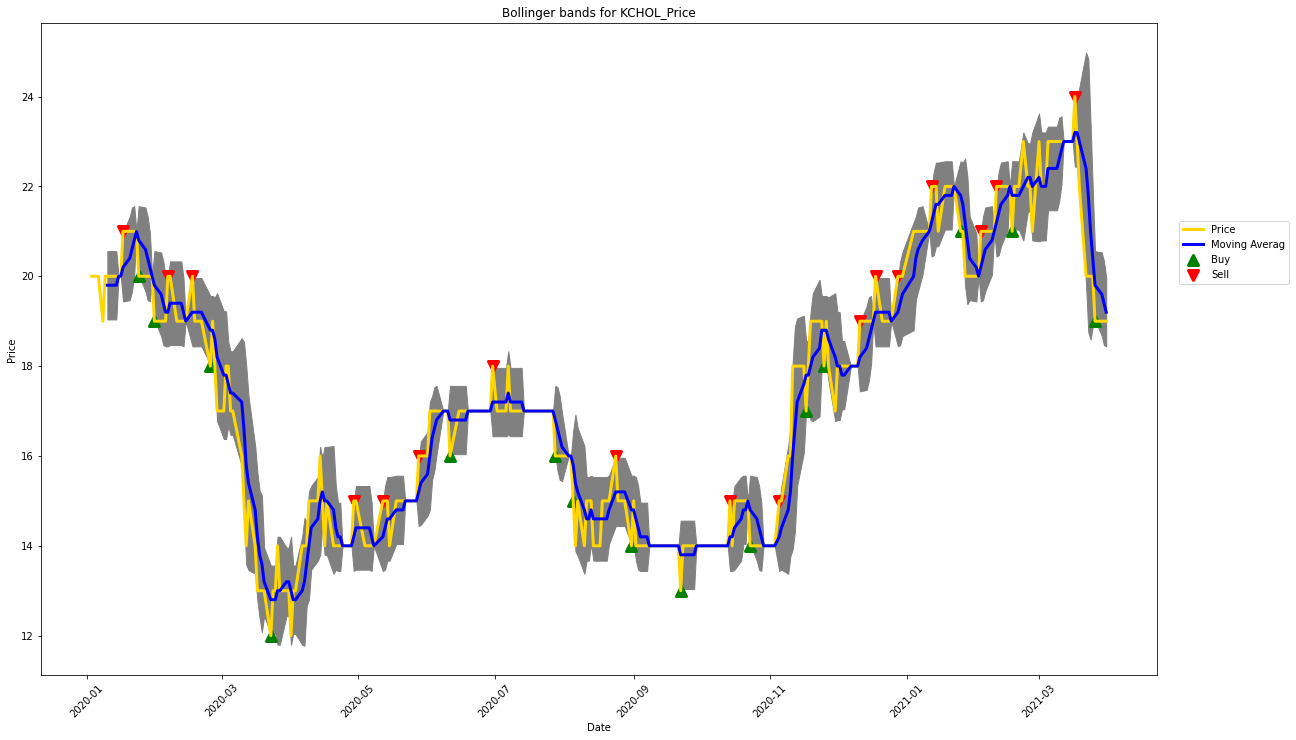

In [166]:
# Bollinger bands for the actual data daily

bollinger_bands(df = stock_prices_daily, col = 'KCHOL_Price', p = 5, std = 1.7)

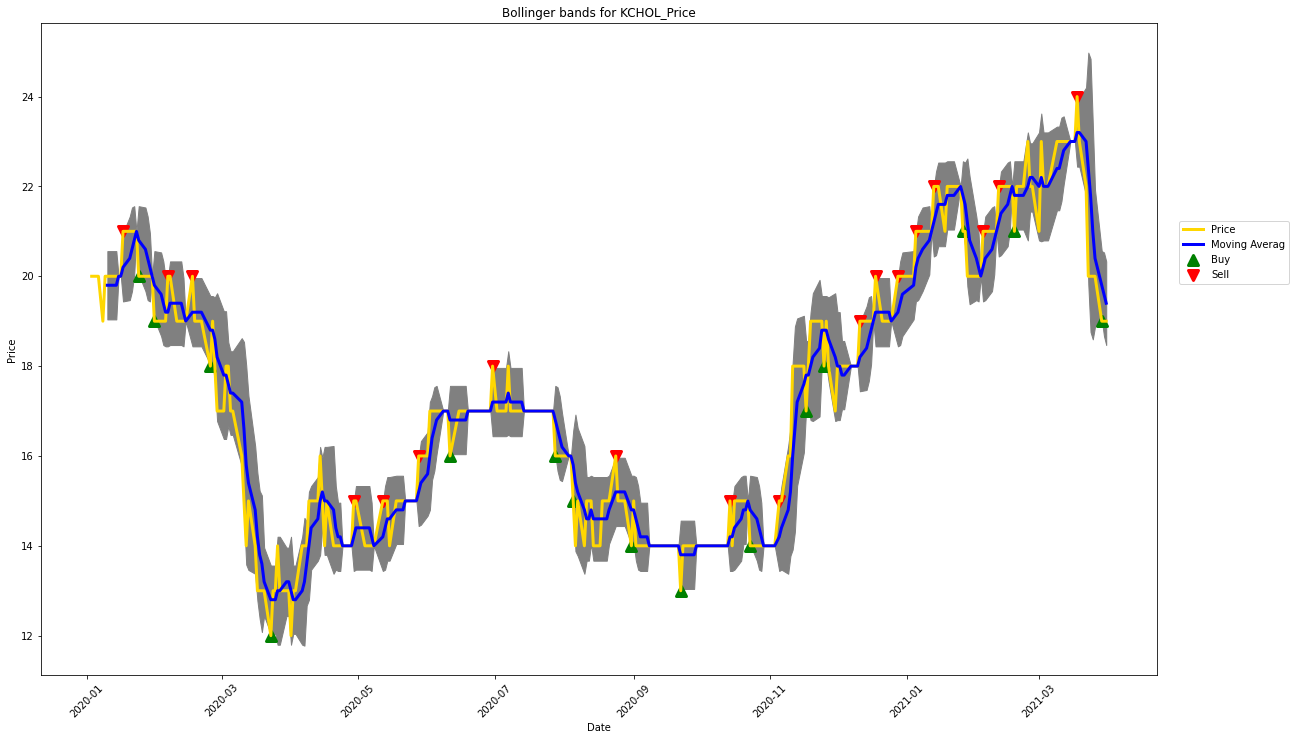

In [167]:
# Bollinger bands for the actual data daily

bollinger_bands(df = predicted_df_arima, col = 'KCHOL_Price', p = 5, std = 1.7)

In [168]:
# Check the actual vs the predicted returns

capital_gain_predicted_prices(df1 = test['KCHOL_Price'], df2 = pred_arima['KCHOL_Price'])

The actual returns had a value of -8.44% and the predicted returns had a value -6.88%


#### M Stock

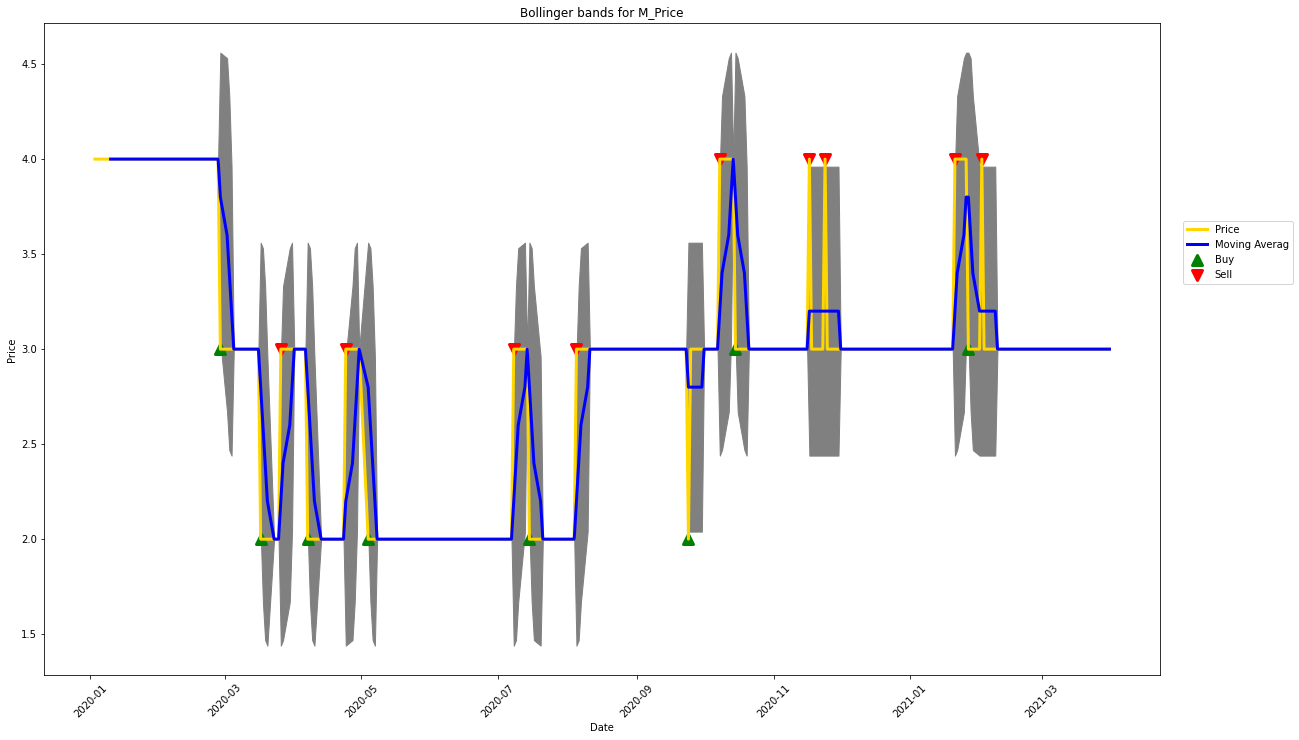

In [169]:
# Bollinger bands for the actual data daily

bollinger_bands(df = stock_prices_daily, col = 'M_Price', p = 5, std = 1.7)

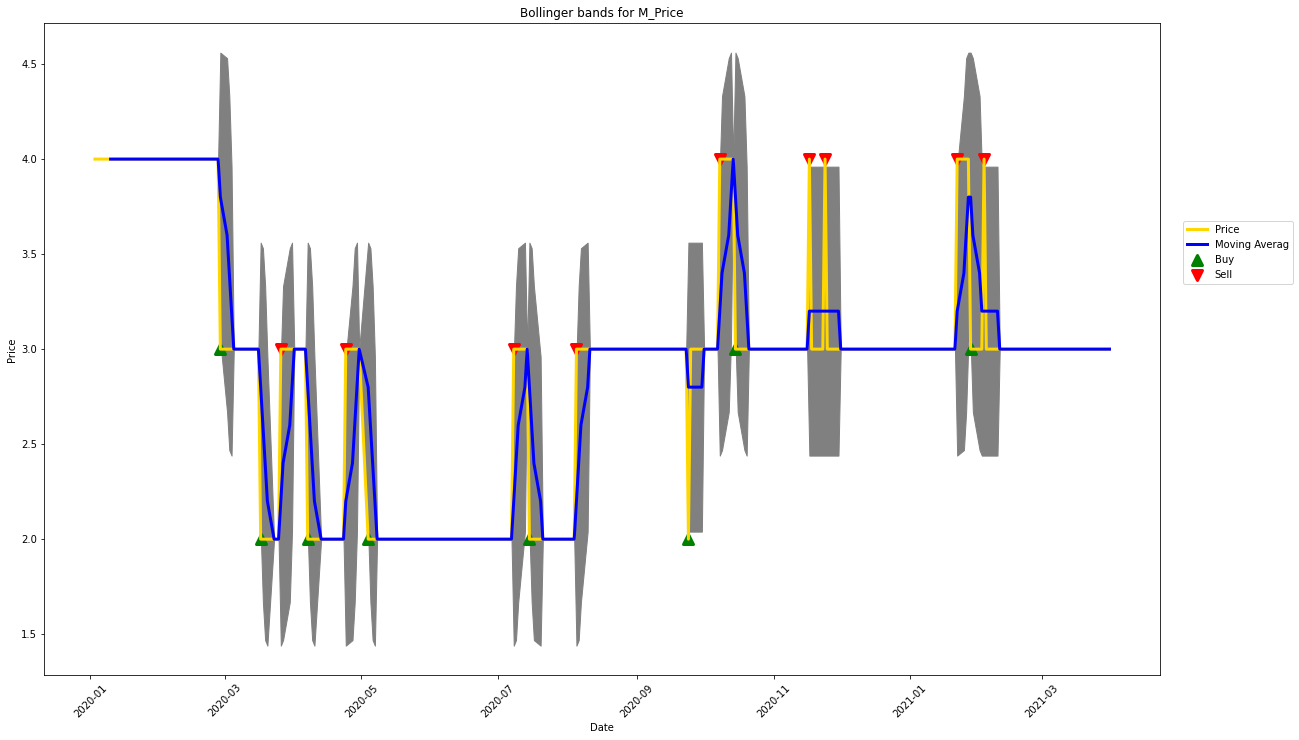

In [170]:
# Bollinger bands for the actual data daily

bollinger_bands(df = predicted_df_arima, col = 'M_Price', p = 5, std = 1.7)

In [171]:
# Check the actual vs the predicted returns

capital_gain_predicted_prices(df1 = test['M_Price'], df2 = pred_arima['M_Price'])

The actual returns had a value of -4.58% and the predicted returns had a value -2.51%


#### BEEF Stock

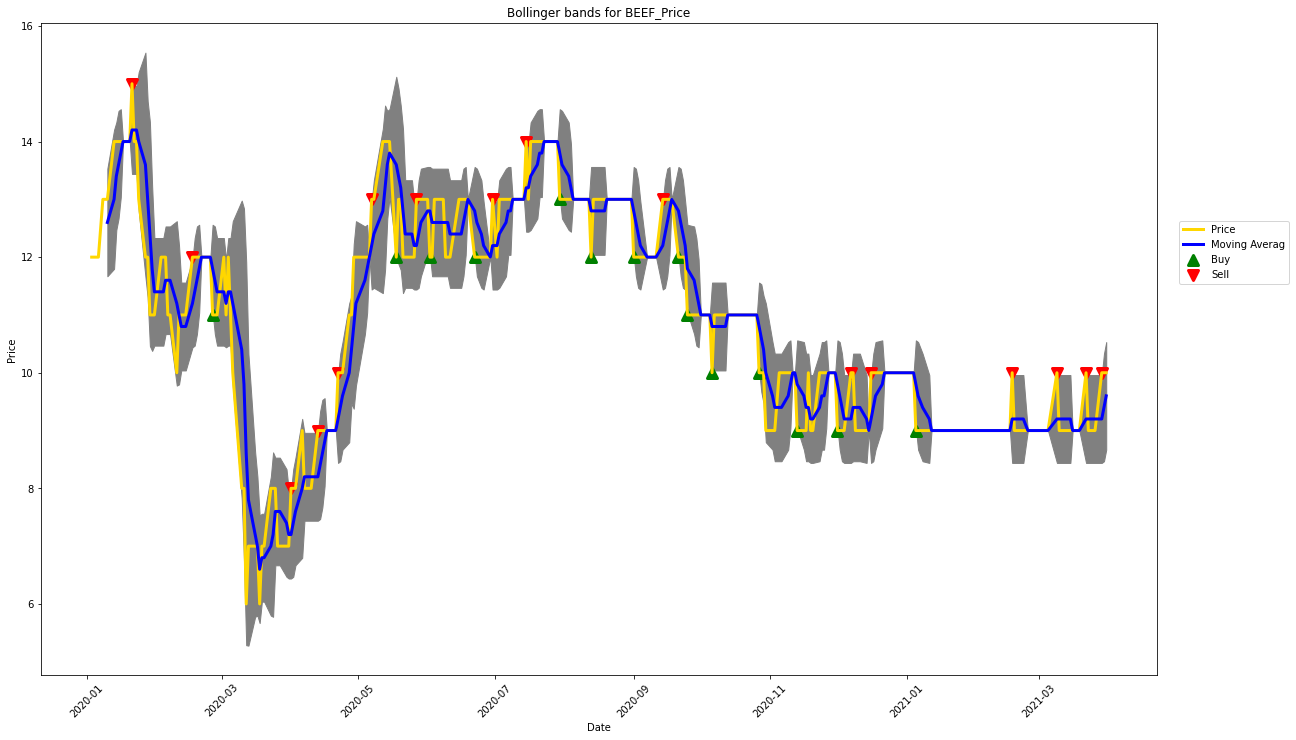

In [172]:
# Bollinger bands for the actual data daily

bollinger_bands(df = stock_prices_daily, col = 'BEEF_Price', p = 5, std = 1.7)

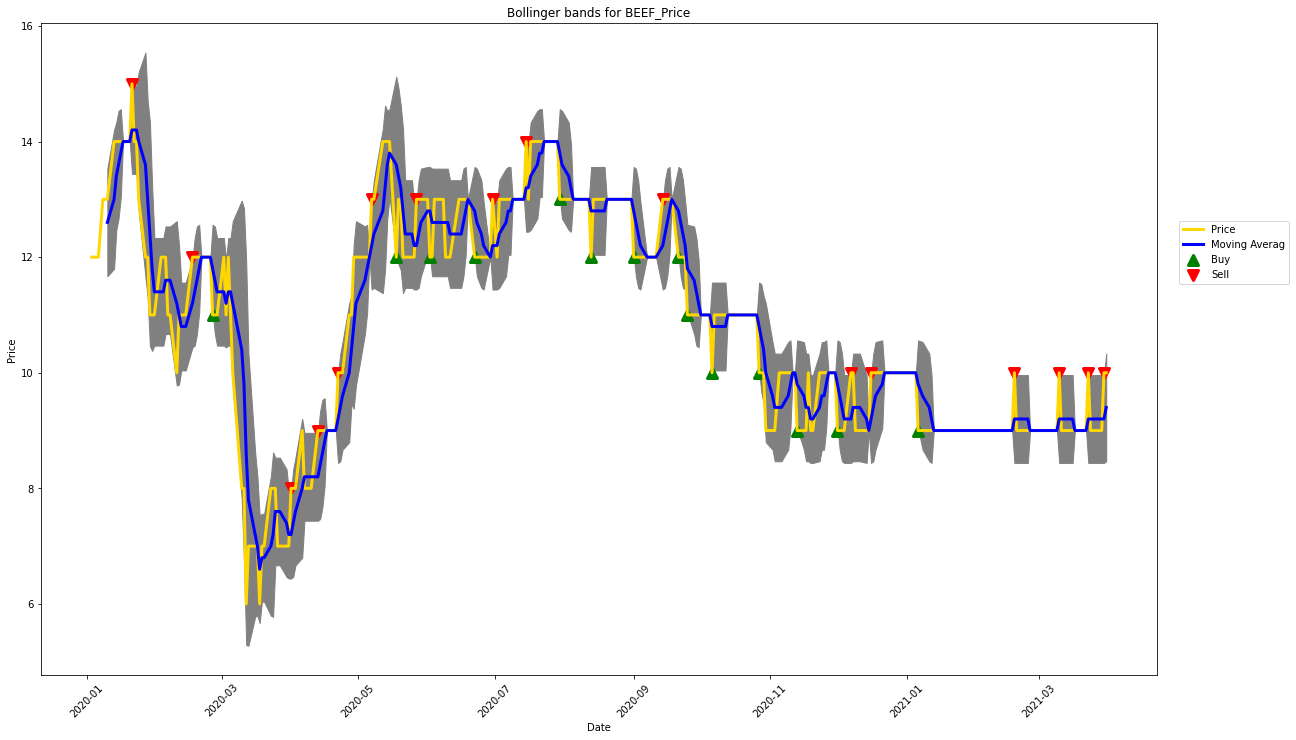

In [173]:
# Bollinger bands for the actual data daily

bollinger_bands(df = predicted_df_arima, col = 'BEEF_Price', p = 5, std = 1.7)

In [174]:
# Check the actual vs the predicted returns

capital_gain_predicted_prices(df1 = test['BEEF_Price'], df2 = pred_arima['BEEF_Price'])

The actual returns had a value of 1.59% and the predicted returns had a value 1.77%


#### P Stock

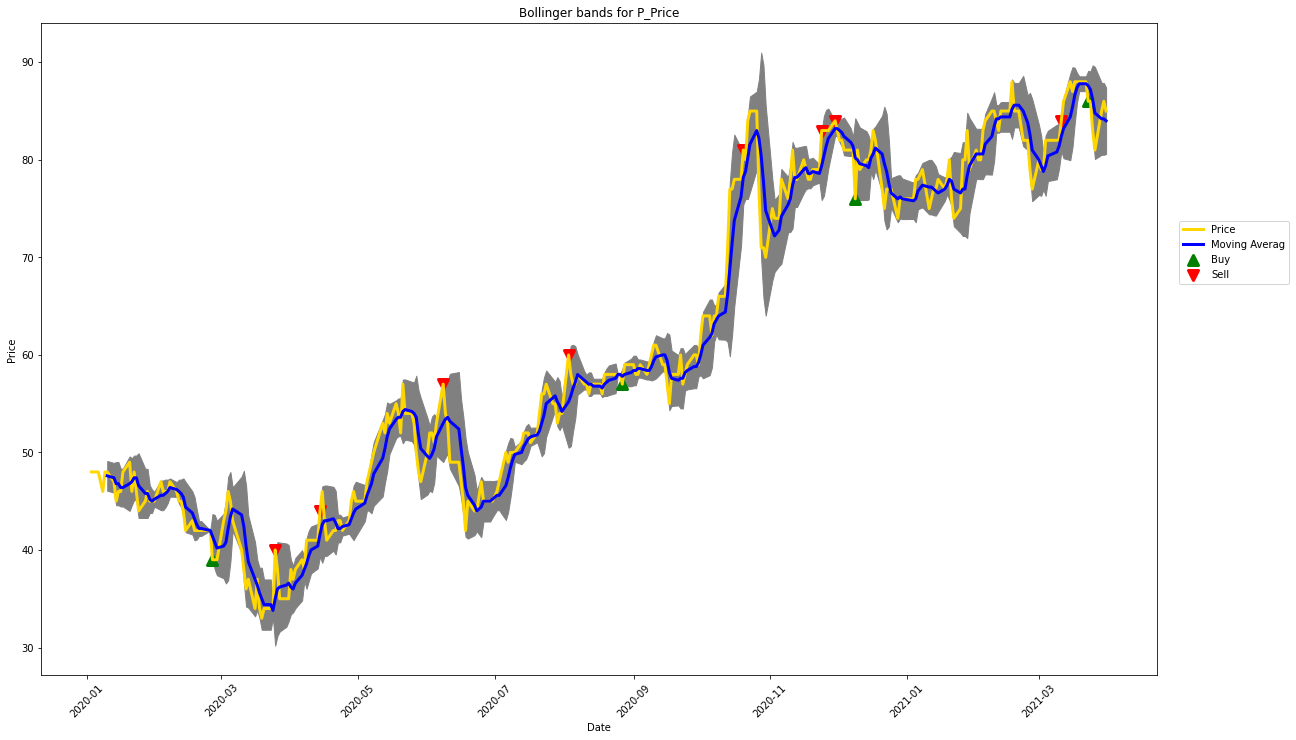

In [175]:
# Bollinger bands for the actual data daily

bollinger_bands(df = stock_prices_daily, col = 'P_Price', p = 5, std = 1.7)

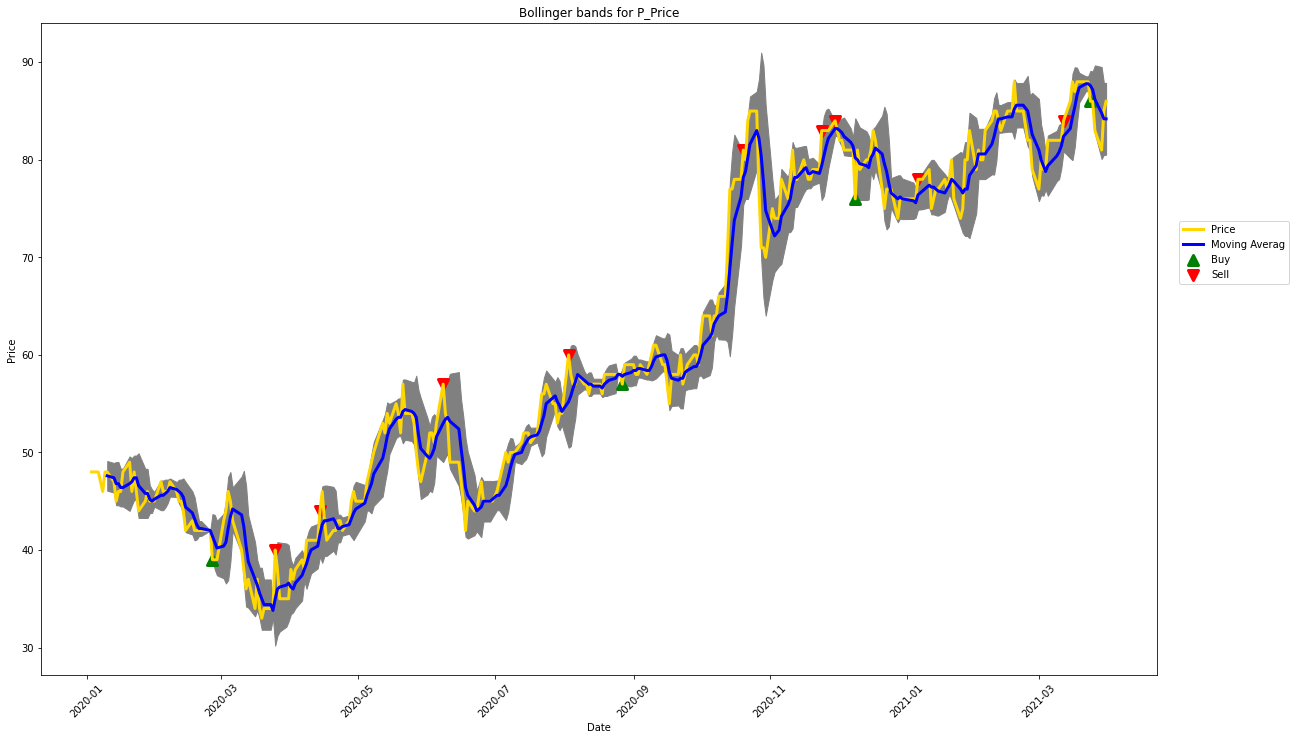

In [176]:
# Bollinger bands for the actual data daily

bollinger_bands(df = predicted_df_arima, col = 'P_Price', p = 5, std = 1.7)

In [177]:
# Check the actual vs the predicted returns

capital_gain_predicted_prices(df1 = test['P_Price'], df2 = pred_arima['P_Price'])

The actual returns had a value of 11.02% and the predicted returns had a value 11.96%


#### C Stock

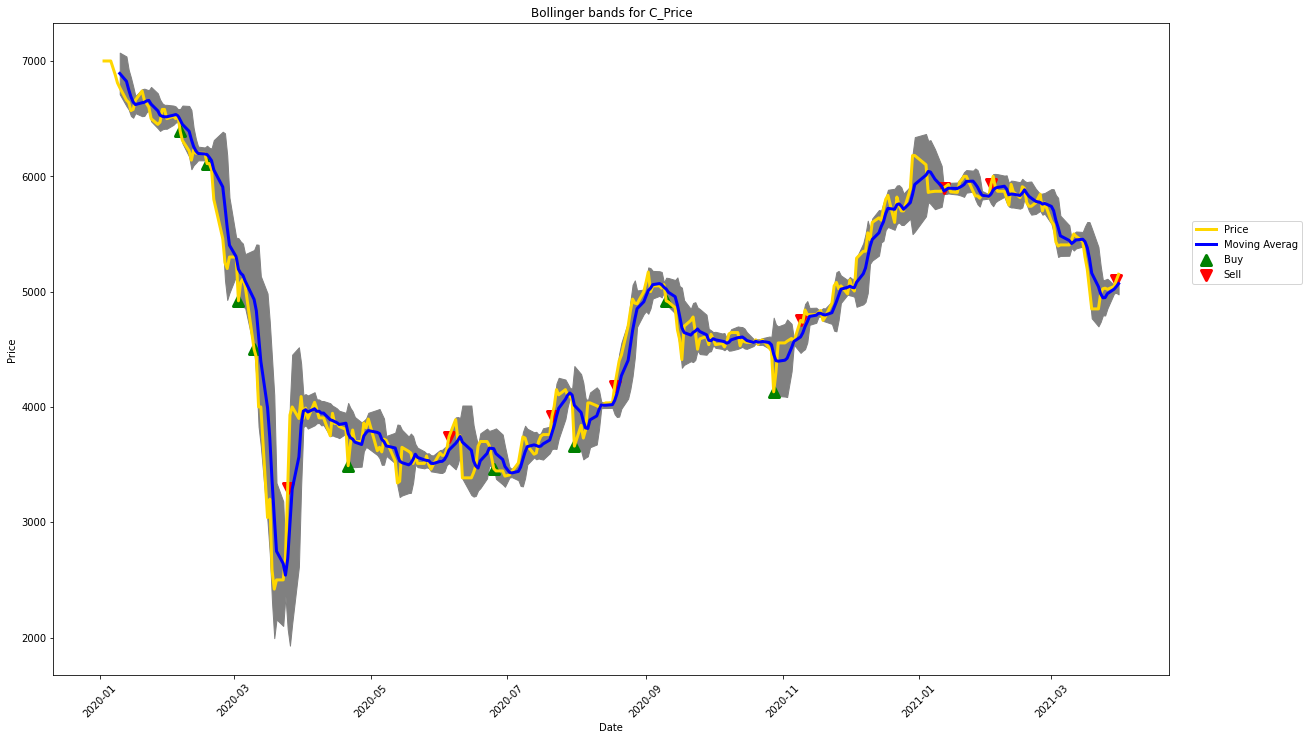

In [178]:
# Bollinger bands for the actual data daily

bollinger_bands(df = stock_prices_daily, col = 'C_Price', p = 5, std = 1.7)

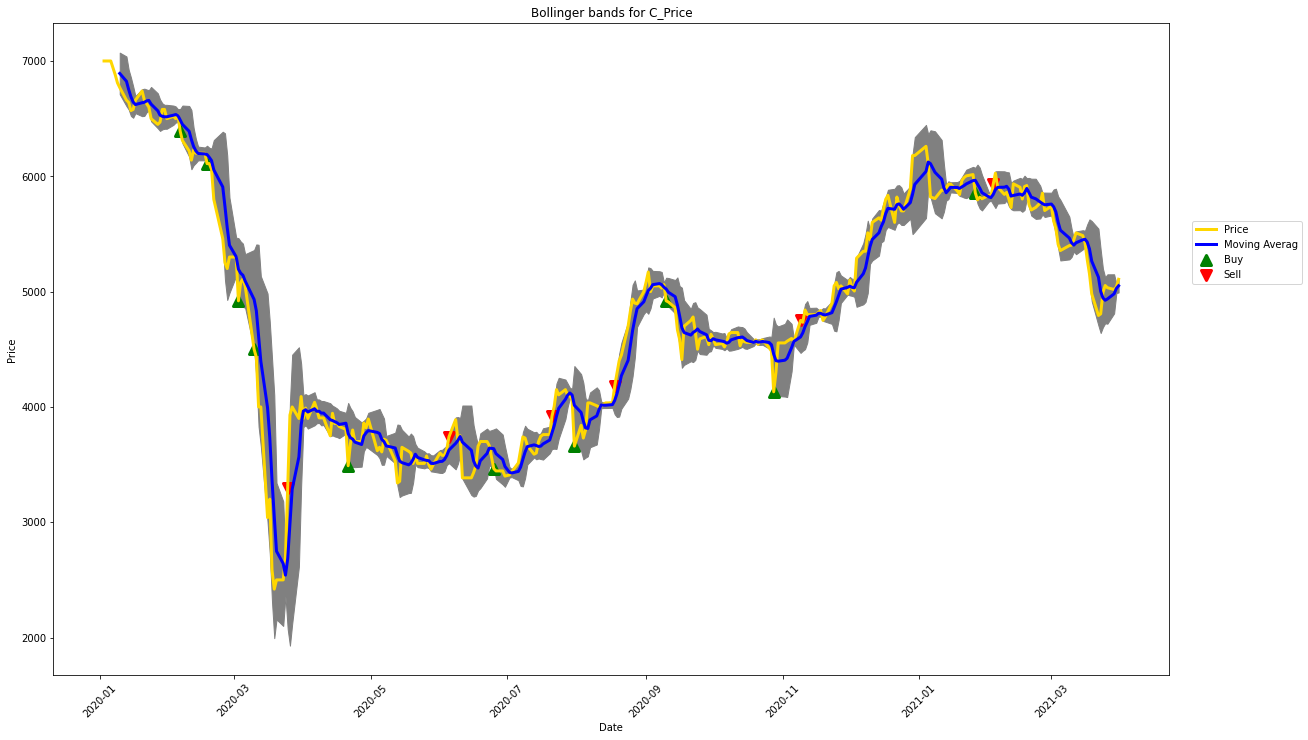

In [179]:
# Bollinger bands for the actual data daily

bollinger_bands(df = predicted_df_arima, col = 'C_Price', p = 5, std = 1.7)

In [180]:
# Check the actual vs the predicted returns

capital_gain_predicted_prices(df1 = test['C_Price'], df2 = pred_arima['C_Price'])

The actual returns had a value of -15.57% and the predicted returns had a value -18.42%


#### IP Stock

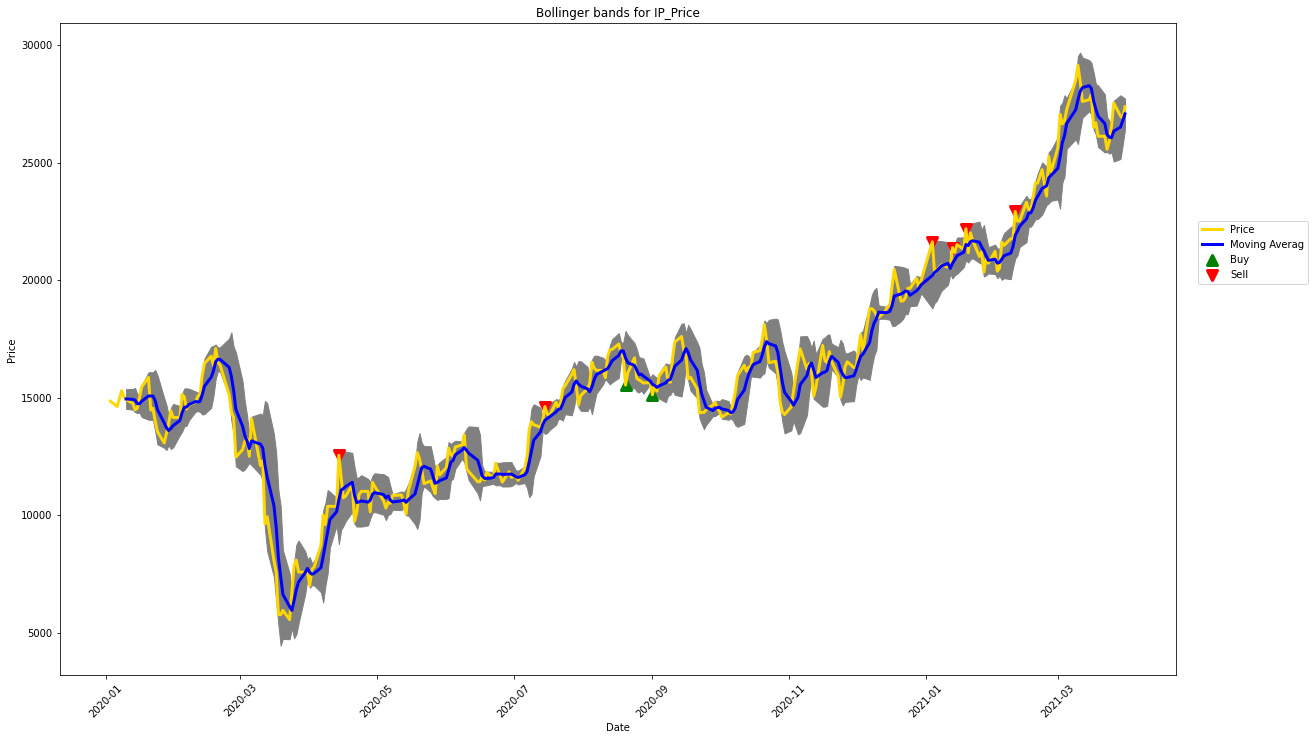

In [181]:
# Bollinger bands for the actual data daily

bollinger_bands(df = stock_prices_daily, col = 'IP_Price', p = 5, std = 1.7)

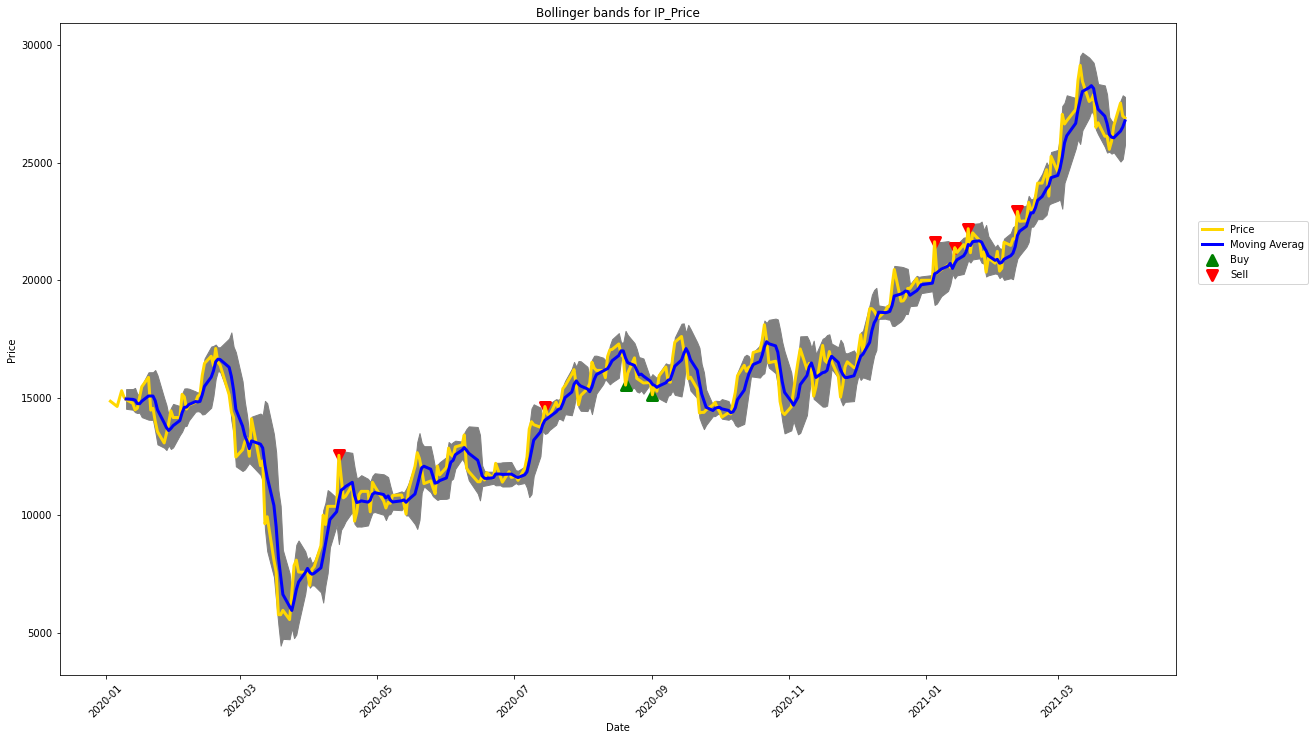

In [182]:
# Bollinger bands for the actual data daily

bollinger_bands(df = predicted_df_arima, col = 'IP_Price', p = 5, std = 1.7)

In [183]:
# Check the actual vs the predicted returns

capital_gain_predicted_prices(df1 = test['IP_Price'], df2 = pred_arima['IP_Price'])

The actual returns had a value of 26.56% and the predicted returns had a value 34.56%


#### DS Stock

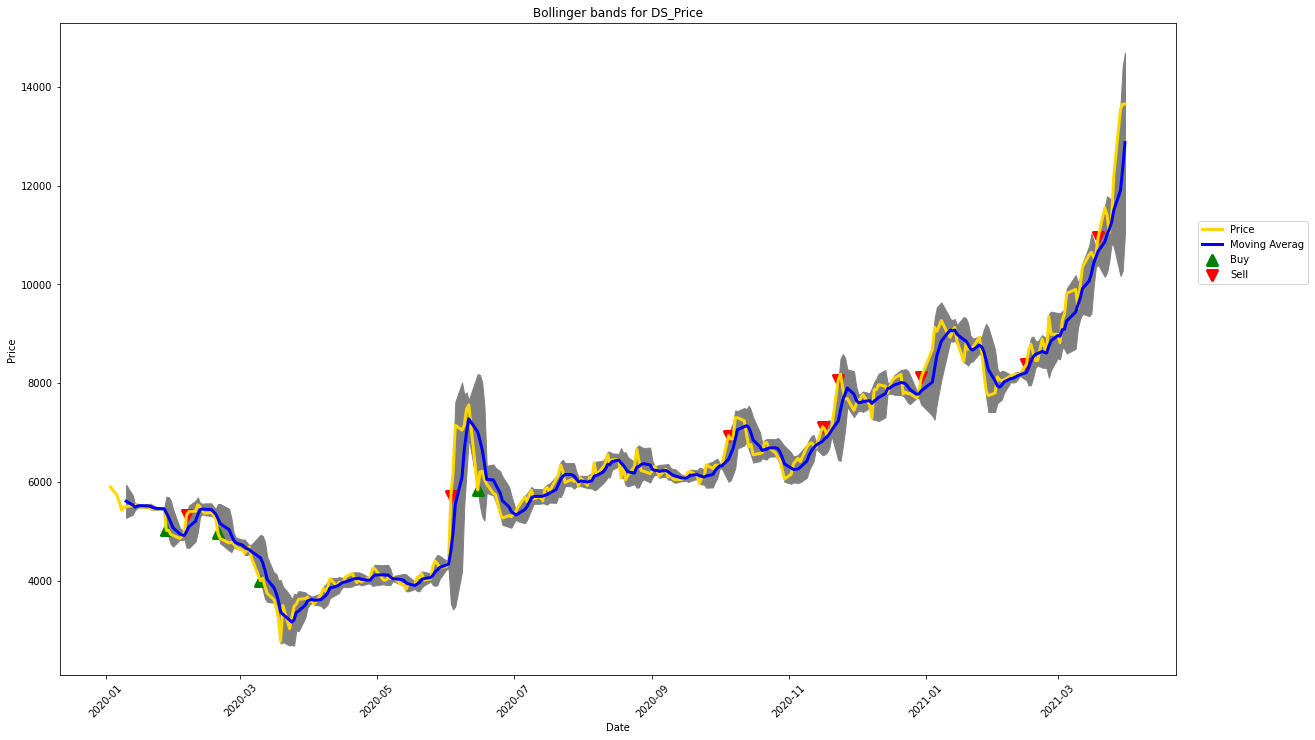

In [184]:
# Bollinger bands for the actual data daily

bollinger_bands(df = stock_prices_daily, col = 'DS_Price', p = 5, std = 1.7)

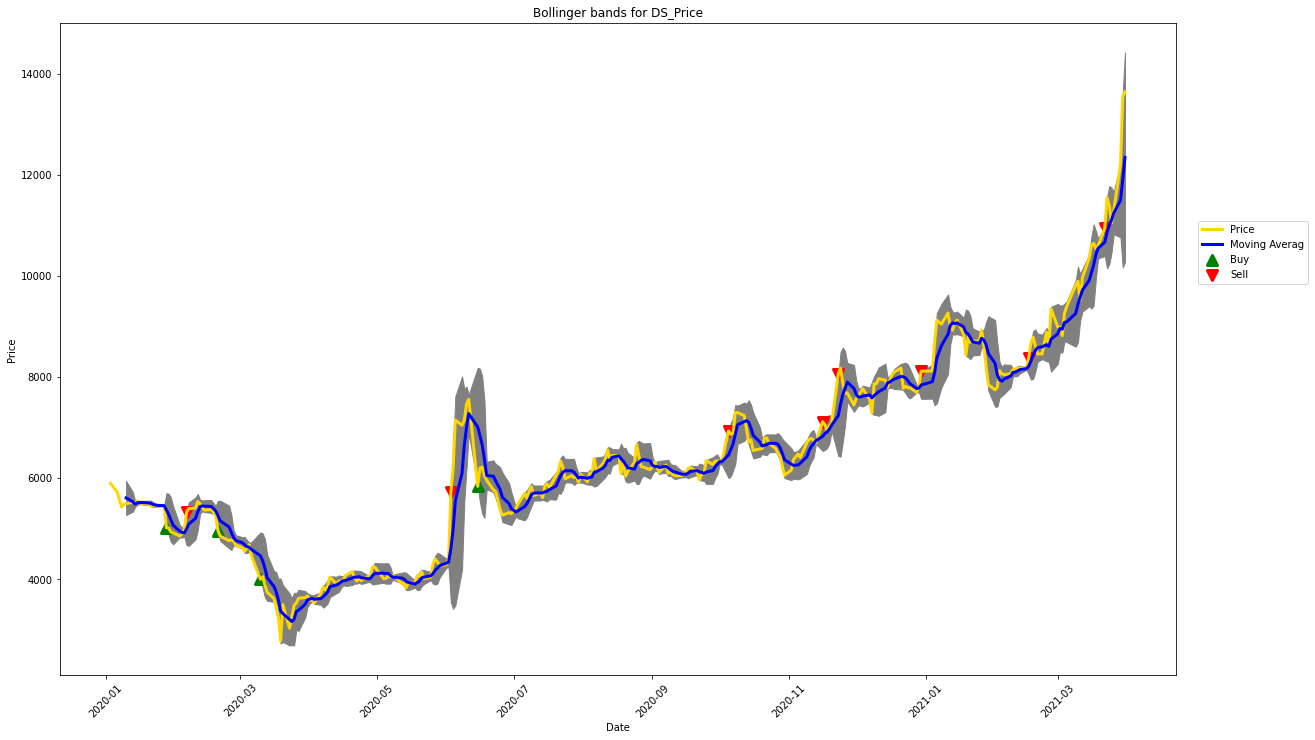

In [185]:
# Bollinger bands for the actual data daily

bollinger_bands(df = predicted_df_arima, col = 'DS_Price', p = 5, std = 1.7)

In [186]:
# Check the actual vs the predicted returns

capital_gain_predicted_prices(df1 = test['DS_Price'], df2 = pred_arima['DS_Price'])

The actual returns had a value of 57.26% and the predicted returns had a value 68.1%


### Combining two models

In [187]:
from sklearn.metrics import mean_squared_error

In [188]:
def model_weight(col):
    x = np.arange(0,1.1, 0.1)
    y = np.arange(0,1.1, 0.1)
    squared_error = []
    weights_lstm = []
    weights_arima = []
    for i in x:
        for j in y:
            if (i+j) ==1:
                p = (i*predictions_df[col])+(j*pred_arima[col])
                e = mean_squared_error(test[col], p)
                squared_error.append(e)
                weights_lstm.append(i)
                weights_arima.append(j)
                
            else:
                pass
    return squared_error, weights_lstm, weights_arima

In [189]:
def pred_df(col):
    pred = pd.concat([train[col], weighted_predictions[col]])
    return pred

In [190]:
# The combination of the two models by weigthing the results per 0.5. 
# Didn't take approach of mean squared error because it would show to use only ARIMA

weighted_predictions = (0.5 * predictions_df) + (0.5 * pred_arima)

#### D Stock

In [191]:
# New predictions

S_predictions = pred_df(col = 'S_Price')

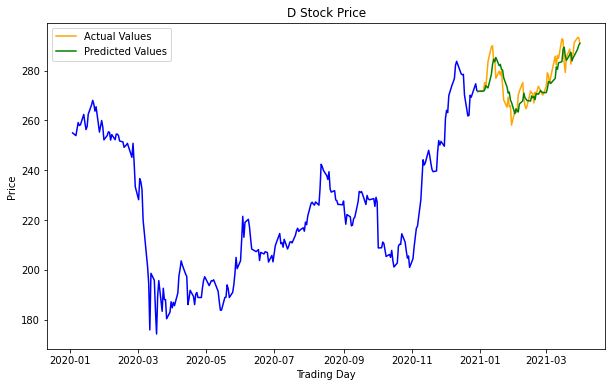

In [192]:
# Plot the Stock Price comparison

plot_comparison(actual = S_actual, predicted = S_predictions, string = 'D Stock Price')

#### KCHOL Stock

In [193]:
# New predictions

KCHOL_predictions = pred_df(col = 'KCHOL_Price')

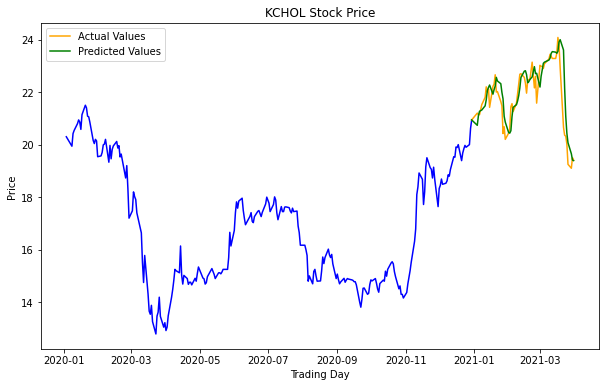

In [194]:
# Plot the Stock Price comparison

plot_comparison(actual = KCHOL_actual, predicted = KCHOL_predictions, string = 'KCHOL Stock Price')

#### M Stock

In [195]:
# New predictions

M_predictions = pred_df(col = 'M_Price')

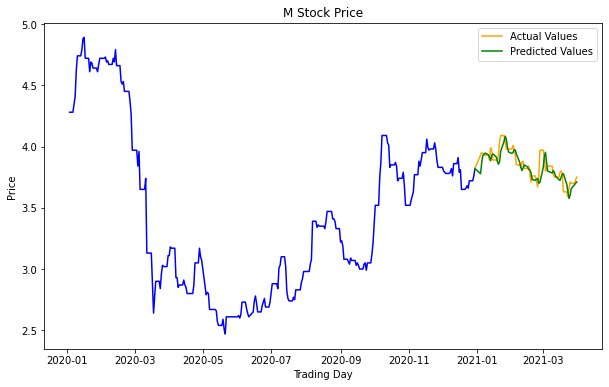

In [196]:
# Plot the Stock Price comparison

plot_comparison(actual = M_actual, predicted = M_predictions, string = 'M Stock Price')

#### BEEF Stock

In [197]:
# New predictions

BEEF_predictions = pred_df(col = 'BEEF_Price')

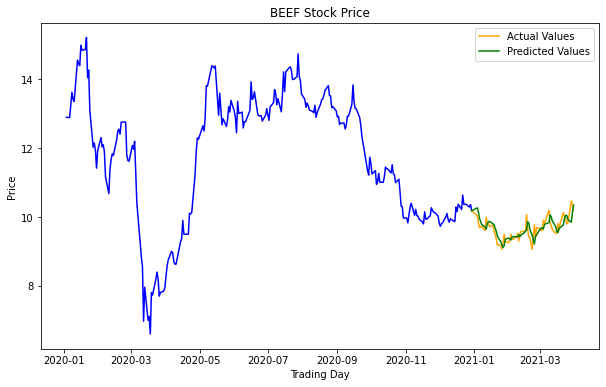

In [198]:
# Plot the Stock Price comparison

plot_comparison(actual = BEEF_actual, predicted = BEEF_predictions, string = 'BEEF Stock Price')

#### P Stock

In [199]:
# New predictions

P_predictions = pred_df(col = 'P_Price')

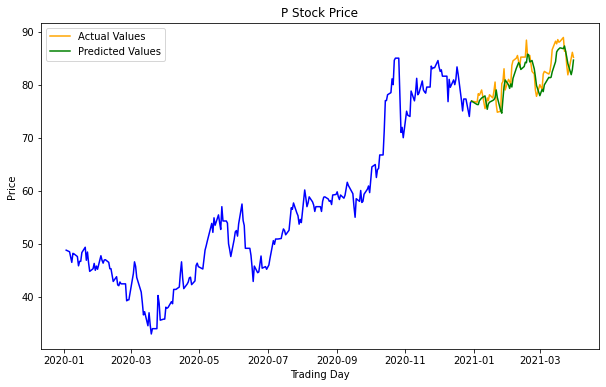

In [200]:
# Plot the Stock Price comparison

plot_comparison(actual = P_actual, predicted = P_predictions, string = 'P Stock Price')

#### C Stock

In [201]:
# New predictions

C_predictions = pred_df(col = 'C_Price')

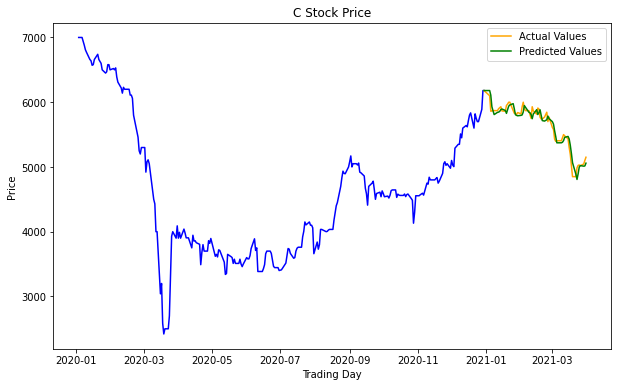

In [202]:
# Plot the Stock Price comparison

plot_comparison(actual = C_actual, predicted = C_predictions, string = 'C Stock Price')

#### IP Stock

In [203]:
# New predictions

IP_predictions = pred_df(col = 'IP_Price')

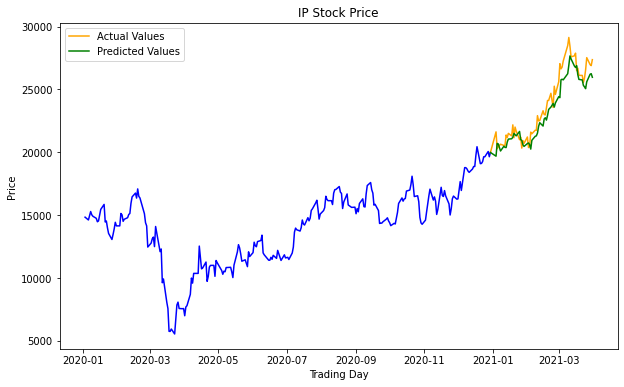

In [204]:
# Plot the Stock Price comparison

plot_comparison(actual = IP_actual, predicted = IP_predictions, string = 'IP Stock Price')

#### DS Stock

In [205]:
# New predictions

DS_predictions = pred_df(col = 'DS_Price')

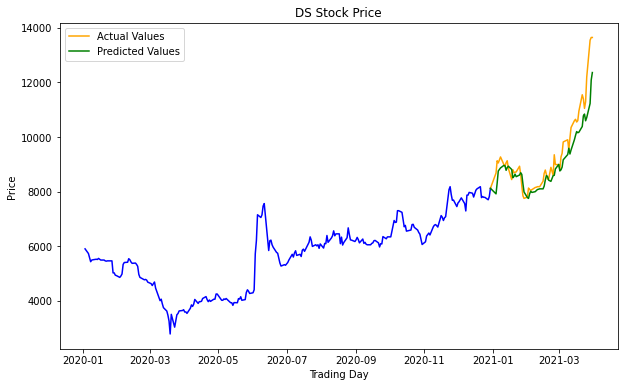

In [206]:
# Plot the Stock Price comparison

plot_comparison(actual = DS_actual, predicted = DS_predictions, string = 'DS Stock Price')

In [207]:
class model_reinforcement:
    
    def __init__(self, state_size, window_size, trend, skip, batch_size):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.action_size = 3
        self.batch_size = batch_size
        self.memory = deque(maxlen = 1000)
        self.inventory = []
        self.gamma = 0.95
        self.epsilon = 0.5
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999
        tf.reset_default_graph()
        self.sess = tf.InteractiveSession()
        self.X = tf.placeholder(tf.float32, [None, self.state_size])
        self.Y = tf.placeholder(tf.float32, [None, self.action_size])
        feed = tf.layers.dense(self.X, 256, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed, self.action_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.GradientDescentOptimizer(1e-5).minimize(
            self.cost
        )
        self.sess.run(tf.global_variables_initializer())
        
    def act(self, state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        return np.argmax(
            self.sess.run(self.logits, feed_dict = {self.X: state})[0]
        )
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])
    def replay(self, batch_size):
        mini_batch = []
        l = len(self.memory)
        for i in range(l - batch_size, l):
            mini_batch.append(self.memory[i])
        replay_size = len(mini_batch)
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.action_size))
        states = np.array([a[0][0] for a in mini_batch])
        new_states = np.array([a[3][0] for a in mini_batch])
        Q = self.sess.run(self.logits, feed_dict = {self.X: states})
        Q_new = self.sess.run(self.logits, feed_dict = {self.X: new_states})
        for i in range(len(mini_batch)):
            state, action, reward, next_state, done = mini_batch[i]
            target = Q[i]
            target[action] = reward
            if not done:
                target[action] += self.gamma * np.amax(Q_new[i])
            X[i] = state
            Y[i] = target
        cost, _ = self.sess.run(
            [self.cost, self.optimizer], feed_dict = {self.X: X, self.Y: Y}
        )
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return cost
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)
            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.act(state)
                next_state = self.get_state(t + 1)
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                invest = ((starting_money - initial_money) / initial_money)
                self.memory.append((state, action, invest, 
                                    next_state, starting_money < initial_money))
                state = next_state
                batch_size = min(self.batch_size, len(self.memory))
                cost = self.replay(batch_size)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [208]:
def plot_signals(values):
    fig = plt.figure(figsize = (15,5))
    plt.plot(values, color='r', lw=2.)
    plt.plot(values, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
    plt.plot(values, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
    plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
    plt.legend()
    plt.show()

In [209]:
initial_money = 1000
window_size = 5
skip = 1
batch_size = 32

#### S Stock

##### Actual Values

In [210]:
# Define the values for the S Stock

close = S_actual.values.tolist()

agent = model_reinforcement(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)

# Use the train function
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
epoch: 10, total rewards: -4.320000.3, cost: 0.137258, total money: 995.680000
epoch: 20, total rewards: 12.350000.3, cost: 0.063827, total money: 1012.350000
epoch: 30, total rewards: 12.420000.3, cost: 0.055535, total money: 1012.420000
epoch: 40, total rewards: 12.420000.3, cost: 0.075557, total money: 1012.420000
epoch: 50, total rewards: 6.000000.3, cost: 0.044746, total money: 1006.000000
epoch: 60, total rewards: 7.730000.3, cost: 0.040981, total money: 1007.730000
epoch: 70, total rewards: 6.660000.3, cost: 0.037818, total money: 1006.660000
epoch: 80, total rewards: 9.650000.3, cost: 0.035185, total money: 1009.650000
epoch: 90, total rewards: 1.460000.3, cost: 0.031012, total money: 1001.460000
epoch: 100, total rewards: 5.080000.3, cost: 0.027361, total money: 1005.080000


In [211]:
# Get the buy and sell signals

states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 0: buy 1 unit at price 255.000000, total balance 745.000000
day 2, sell 1 unit at price 259.150000, investment 1.627451 %, total balance 1004.150000,
day 44: buy 1 unit at price 201.200000, total balance 802.950000
day 48, sell 1 unit at price 195.850000, investment -2.659046 %, total balance 998.800000,
day 104: buy 1 unit at price 213.100000, total balance 785.700000
day 106, sell 1 unit at price 220.300000, investment 3.378695 %, total balance 1006.000000,
day 118: buy 1 unit at price 203.150000, total balance 802.850000
day 119, sell 1 unit at price 205.800000, investment 1.304455 %, total balance 1008.650000,
day 178: buy 1 unit at price 226.250000, total balance 782.400000
day 179, sell 1 unit at price 229.880000, investment 1.604420 %, total balance 1012.280000,


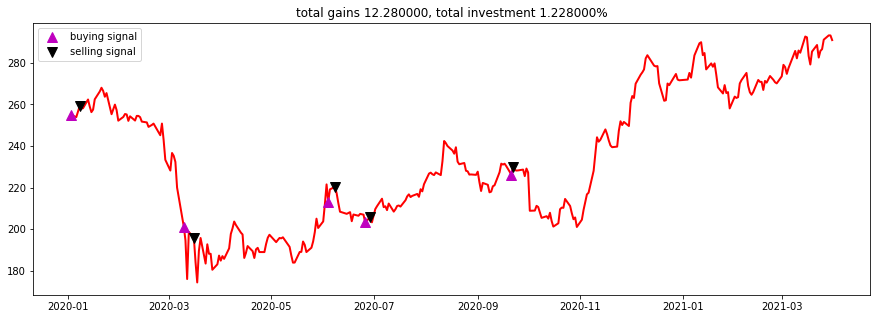

In [212]:
# Plot the results

plot_signals(values = S_actual)

##### Predicted Values

In [213]:
# Define the values for the S Stock

close = S_predictions.values.tolist()

agent = model_reinforcement(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)

# Use the train function
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

epoch: 10, total rewards: 96.708098.3, cost: 0.197661, total money: 526.661011
epoch: 20, total rewards: 77.132326.3, cost: 0.096502, total money: 516.148287
epoch: 30, total rewards: -5.863126.3, cost: 0.100667, total money: 424.089787
epoch: 40, total rewards: -31.118693.3, cost: 0.036782, total money: 682.954979
epoch: 50, total rewards: 5.261006.3, cost: 0.042205, total money: 435.213920
epoch: 60, total rewards: -45.683083.3, cost: 0.030028, total money: 668.390588
epoch: 70, total rewards: -44.234591.3, cost: 0.044943, total money: 955.765409
epoch: 80, total rewards: -38.609680.3, cost: 0.017395, total money: 961.390320
epoch: 90, total rewards: -26.626066.3, cost: 0.017308, total money: 973.373934
epoch: 100, total rewards: -32.853102.3, cost: 0.006810, total money: 967.146898


In [214]:
# Get the buy and sell signals

states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 13: buy 1 unit at price 263.730000, total balance 736.270000
day 15, sell 1 unit at price 255.320000, investment -3.188867 %, total balance 991.590000,
day 24: buy 1 unit at price 254.300000, total balance 737.290000
day 25, sell 1 unit at price 252.260000, investment -0.802202 %, total balance 989.550000,
day 41: buy 1 unit at price 235.270000, total balance 754.280000
day 43, sell 1 unit at price 219.990000, investment -6.494666 %, total balance 974.270000,
day 55: buy 1 unit at price 188.080000, total balance 786.190000
day 57, sell 1 unit at price 180.380000, investment -4.094003 %, total balance 966.570000,
day 62: buy 1 unit at price 185.640000, total balance 780.930000
day 64, sell 1 unit at price 197.630000, investment 6.458737 %, total balance 978.560000,
day 67: buy 1 unit at price 201.990000, total balance 776.570000
day 68: buy 1 unit at price 198.260000, total balance 578.310000
day 70, sell 1 unit at price 186.070000, investment -7.881578 %, total balance 764.380000,


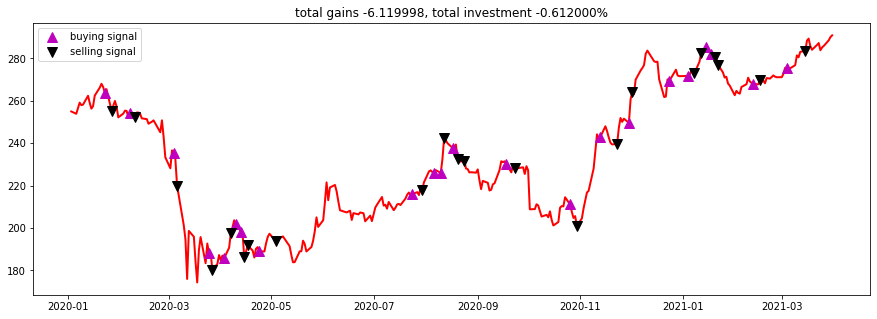

In [215]:
# Plot the results

plot_signals(values = S_predictions)

#### KCHOL Stock

##### Actual Values

In [216]:
# Define the values for the S Stock

close = KCHOL_actual.values.tolist()

agent = model_reinforcement(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)

# Use the train function
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

epoch: 10, total rewards: 8.760000.3, cost: 0.004101, total money: 924.820000
epoch: 20, total rewards: 1.520000.3, cost: 0.004129, total money: 917.580000
epoch: 30, total rewards: 13.650000.3, cost: 0.003677, total money: 929.710000
epoch: 40, total rewards: 14.140000.3, cost: 0.003552, total money: 930.200000
epoch: 50, total rewards: 13.380000.3, cost: 0.003471, total money: 929.440000
epoch: 60, total rewards: -0.470000.3, cost: 0.003716, total money: 915.590000
epoch: 70, total rewards: 17.810000.3, cost: 0.002919, total money: 933.870000
epoch: 80, total rewards: 13.780000.3, cost: 0.003169, total money: 929.840000
epoch: 90, total rewards: 6.260000.3, cost: 0.003305, total money: 922.320000
epoch: 100, total rewards: 6.260000.3, cost: 0.003212, total money: 922.320000


In [217]:
# Get the buy and sell signals

states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 1: buy 1 unit at price 20.080000, total balance 979.920000
day 2: buy 1 unit at price 19.940000, total balance 959.980000
day 4, sell 1 unit at price 20.540000, investment 2.290837 %, total balance 980.520000,
day 5, sell 1 unit at price 20.800000, investment 4.312939 %, total balance 1001.320000,
day 8: buy 1 unit at price 20.580000, total balance 980.740000
day 10, sell 1 unit at price 21.500000, investment 4.470360 %, total balance 1002.240000,
day 14: buy 1 unit at price 20.860000, total balance 981.380000
day 15: buy 1 unit at price 20.160000, total balance 961.220000
day 18: buy 1 unit at price 20.140000, total balance 941.080000
day 21: buy 1 unit at price 19.700000, total balance 921.380000
day 24, sell 1 unit at price 20.200000, investment -3.163950 %, total balance 941.580000,
day 25: buy 1 unit at price 19.330000, total balance 922.250000
day 27: buy 1 unit at price 19.460000, total balance 902.790000
day 30: buy 1 unit at price 20.120000, total balance 882.670000
day 32

day 193, sell 1 unit at price 14.840000, investment -0.134590 %, total balance 838.690000,
day 194, sell 1 unit at price 14.800000, investment 0.680272 %, total balance 853.490000,
day 195, sell 1 unit at price 15.180000, investment 1.810865 %, total balance 868.670000,
day 196: buy 1 unit at price 14.990000, total balance 853.680000
day 197, sell 1 unit at price 15.250000, investment 2.486559 %, total balance 868.930000,
day 198, sell 1 unit at price 15.490000, investment 4.803789 %, total balance 884.420000,
day 199, sell 1 unit at price 15.540000, investment 6.002729 %, total balance 899.960000,
day 200, sell 1 unit at price 15.460000, investment 10.428571 %, total balance 915.420000,
day 201: buy 1 unit at price 15.160000, total balance 900.260000
day 202: buy 1 unit at price 14.970000, total balance 885.290000
day 203: buy 1 unit at price 14.510000, total balance 870.780000
day 205: buy 1 unit at price 14.300000, total balance 856.480000
day 210, sell 1 unit at price 15.200000, in

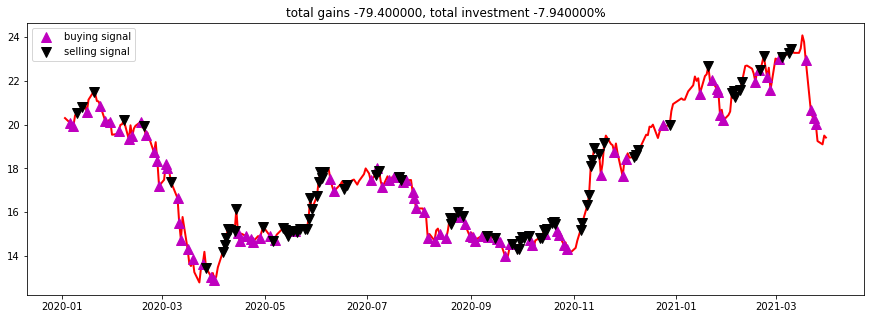

In [218]:
# Plot the results

plot_signals(values = KCHOL_actual)

##### Predicted Values

In [219]:
# Define the values for the S Stock

close = KCHOL_predictions.values.tolist()

agent = model_reinforcement(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)

# Use the train function
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

epoch: 10, total rewards: 112.358110.3, cost: 0.293614, total money: 56.211537
epoch: 20, total rewards: 113.898268.3, cost: 0.244292, total money: 123.580909
epoch: 30, total rewards: 99.953361.3, cost: 0.116724, total money: 424.666311
epoch: 40, total rewards: 57.795558.3, cost: 0.081288, total money: 503.273764
epoch: 50, total rewards: 60.071063.3, cost: 0.090603, total money: 486.065601
epoch: 60, total rewards: 45.535164.3, cost: 0.054731, total money: 600.225601
epoch: 70, total rewards: 44.074427.3, cost: 0.048607, total money: 620.685601
epoch: 80, total rewards: 61.000376.3, cost: 0.046081, total money: 613.949726
epoch: 90, total rewards: 16.217504.3, cost: 0.027998, total money: 700.789287
epoch: 100, total rewards: 47.669937.3, cost: 0.045205, total money: 623.336387


In [220]:
# Get the buy and sell signals

states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 5: buy 1 unit at price 20.800000, total balance 979.200000
day 6: buy 1 unit at price 20.940000, total balance 958.260000
day 8: buy 1 unit at price 20.580000, total balance 937.680000
day 10, sell 1 unit at price 21.500000, investment 3.365385 %, total balance 959.180000,
day 11: buy 1 unit at price 21.400000, total balance 937.780000
day 12: buy 1 unit at price 21.080000, total balance 916.700000
day 13, sell 1 unit at price 21.060000, investment 0.573066 %, total balance 937.760000,
day 14, sell 1 unit at price 20.860000, investment 1.360544 %, total balance 958.620000,
day 15: buy 1 unit at price 20.160000, total balance 938.460000
day 16, sell 1 unit at price 20.040000, investment -6.355140 %, total balance 958.500000,
day 17: buy 1 unit at price 20.200000, total balance 938.300000
day 18: buy 1 unit at price 20.140000, total balance 918.160000
day 19: buy 1 unit at price 19.540000, total balance 898.620000
day 20, sell 1 unit at price 19.570000, investment -7.163188 %, total 

day 168, sell 1 unit at price 14.910000, investment -0.600000 %, total balance 839.340000,
day 169: buy 1 unit at price 14.760000, total balance 824.580000
day 170: buy 1 unit at price 14.840000, total balance 809.740000
day 173: buy 1 unit at price 14.850000, total balance 794.890000
day 178: buy 1 unit at price 14.000000, total balance 780.890000
day 179, sell 1 unit at price 13.810000, investment -6.689189 %, total balance 794.700000,
day 180: buy 1 unit at price 14.120000, total balance 780.580000
day 181, sell 1 unit at price 14.530000, investment -6.076277 %, total balance 795.110000,
day 182: buy 1 unit at price 14.540000, total balance 780.570000
day 183: buy 1 unit at price 14.300000, total balance 766.270000
day 184, sell 1 unit at price 14.340000, investment -8.662420 %, total balance 780.610000,
day 185, sell 1 unit at price 14.670000, investment -7.151899 %, total balance 795.280000,
day 186, sell 1 unit at price 14.850000, investment -5.414013 %, total balance 810.130000,

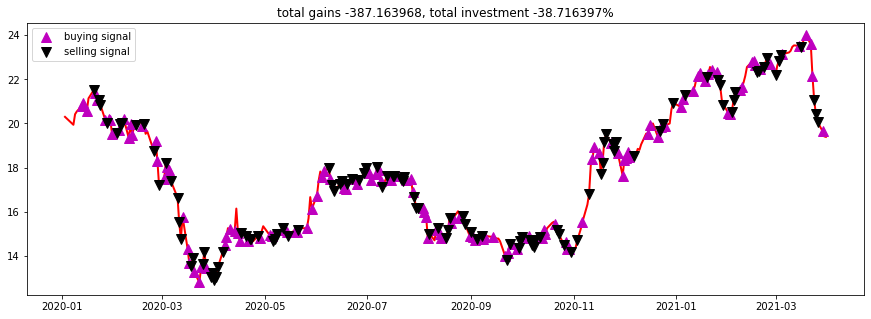

In [221]:
# Plot the results

plot_signals(values = KCHOL_predictions)

#### M Stock

##### Actual Values

In [222]:
# Define the values for the S Stock

close = M_actual.values.tolist()

agent = model_reinforcement(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)

# Use the train function
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

epoch: 10, total rewards: -0.030000.3, cost: 0.000149, total money: 999.970000
epoch: 20, total rewards: -0.170000.3, cost: 0.000188, total money: 999.830000
epoch: 30, total rewards: -1.000000.3, cost: 0.000203, total money: 999.000000
epoch: 40, total rewards: -0.640000.3, cost: 0.000188, total money: 999.360000
epoch: 50, total rewards: -0.030000.3, cost: 0.000141, total money: 999.970000
epoch: 60, total rewards: -0.450000.3, cost: 0.000179, total money: 999.550000
epoch: 70, total rewards: -0.170000.3, cost: 0.000173, total money: 999.830000
epoch: 80, total rewards: -0.150000.3, cost: 0.000170, total money: 999.850000
epoch: 90, total rewards: -0.530000.3, cost: 0.000172, total money: 999.470000
epoch: 100, total rewards: -0.310000.3, cost: 0.000166, total money: 999.690000


In [223]:
# Get the buy and sell signals

states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 14: buy 1 unit at price 4.640000, total balance 995.360000
day 15, sell 1 unit at price 4.640000, investment 0.000000 %, total balance 1000.000000,
day 19: buy 1 unit at price 4.720000, total balance 995.280000
day 20, sell 1 unit at price 4.720000, investment 0.000000 %, total balance 1000.000000,
day 34: buy 1 unit at price 4.450000, total balance 995.550000
day 35, sell 1 unit at price 4.450000, investment 0.000000 %, total balance 1000.000000,
day 41: buy 1 unit at price 3.840000, total balance 996.160000
day 42, sell 1 unit at price 3.960000, investment 3.125000 %, total balance 1000.120000,
day 49: buy 1 unit at price 2.890000, total balance 997.230000
day 51, sell 1 unit at price 2.780000, investment -3.806228 %, total balance 1000.010000,
day 53: buy 1 unit at price 2.900000, total balance 997.110000
day 55, sell 1 unit at price 2.960000, investment 2.068966 %, total balance 1000.070000,
day 57: buy 1 unit at price 3.020000, total balance 997.050000
day 58, sell 1 unit at p

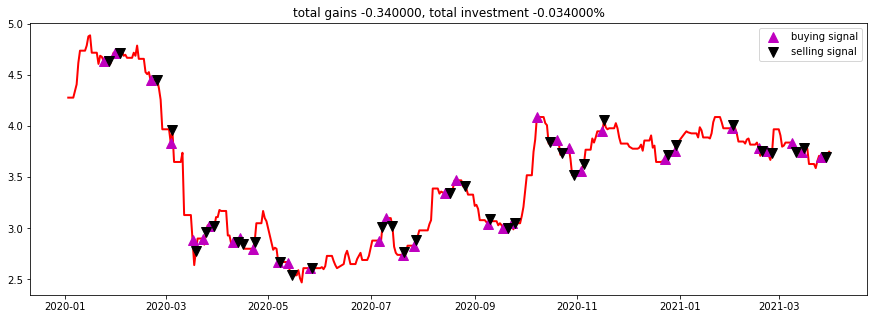

In [224]:
# Plot the results

plot_signals(values = M_actual)

##### Predicted Values

In [225]:
# Define the values for the S Stock

close = M_predictions.values.tolist()

agent = model_reinforcement(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)

# Use the train function
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

epoch: 10, total rewards: -30.193713.3, cost: 0.085774, total money: 478.041050
epoch: 20, total rewards: -9.282658.3, cost: 0.052135, total money: 594.057037
epoch: 30, total rewards: -0.778470.3, cost: 0.031344, total money: 681.322469
epoch: 40, total rewards: 9.562809.3, cost: 0.017446, total money: 763.061133
epoch: 50, total rewards: 12.275461.3, cost: 0.011184, total money: 808.520332
epoch: 60, total rewards: 10.505904.3, cost: 0.009554, total money: 828.204681
epoch: 70, total rewards: 11.585672.3, cost: 0.007981, total money: 843.434218
epoch: 80, total rewards: 7.465672.3, cost: 0.006114, total money: 862.448603
epoch: 90, total rewards: 9.142190.3, cost: 0.004948, total money: 875.575121
epoch: 100, total rewards: 10.505144.3, cost: 0.004359, total money: 884.617673


In [226]:
# Get the buy and sell signals

states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 2: buy 1 unit at price 4.410000, total balance 995.590000
day 3: buy 1 unit at price 4.620000, total balance 990.970000
day 4: buy 1 unit at price 4.740000, total balance 986.230000
day 5, sell 1 unit at price 4.740000, investment 7.482993 %, total balance 990.970000,
day 7: buy 1 unit at price 4.880000, total balance 986.090000
day 8: buy 1 unit at price 4.890000, total balance 981.200000
day 12: buy 1 unit at price 4.690000, total balance 976.510000
day 13: buy 1 unit at price 4.680000, total balance 971.830000
day 14, sell 1 unit at price 4.640000, investment 0.432900 %, total balance 976.470000,
day 17, sell 1 unit at price 4.670000, investment -1.476793 %, total balance 981.140000,
day 18: buy 1 unit at price 4.720000, total balance 976.420000
day 19, sell 1 unit at price 4.720000, investment -3.278689 %, total balance 981.140000,
day 23, sell 1 unit at price 4.700000, investment -3.885481 %, total balance 985.840000,
day 25, sell 1 unit at price 4.670000, investment -0.426439

day 220, sell 1 unit at price 3.970000, investment 28.064516 %, total balance 867.400000,
day 223: buy 1 unit at price 4.030000, total balance 863.370000
day 224, sell 1 unit at price 3.980000, investment 45.255474 %, total balance 867.350000,
day 225, sell 1 unit at price 3.890000, investment 41.970803 %, total balance 871.240000,
day 228: buy 1 unit at price 3.830000, total balance 867.410000
day 229, sell 1 unit at price 3.800000, investment 37.184116 %, total balance 871.210000,
day 230, sell 1 unit at price 3.790000, investment 33.922261 %, total balance 875.000000,
day 231, sell 1 unit at price 3.780000, investment 29.452055 %, total balance 878.780000,
day 232, sell 1 unit at price 3.780000, investment 26.845638 %, total balance 882.560000,
day 233, sell 1 unit at price 3.790000, investment 23.051948 %, total balance 886.350000,
day 234, sell 1 unit at price 3.820000, investment 12.684366 %, total balance 890.170000,
day 235, sell 1 unit at price 3.760000, investment 10.914454 %

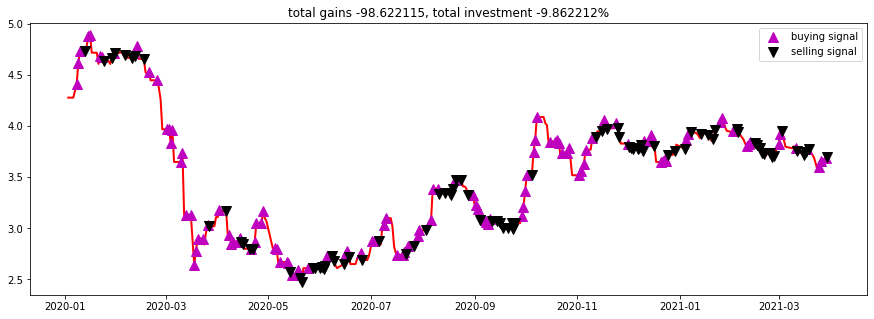

In [227]:
# Plot the results

plot_signals(values = M_predictions)

#### BEEF Stock

##### Actual Values

In [228]:
# Define the values for the S Stock

close = BEEF_actual.values.tolist()

agent = model_reinforcement(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)

# Use the train function
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

epoch: 10, total rewards: -23.520000.3, cost: 0.020575, total money: 795.560000
epoch: 20, total rewards: -26.540000.3, cost: 0.022908, total money: 782.720000
epoch: 30, total rewards: -12.660000.3, cost: 0.014544, total money: 834.870000
epoch: 40, total rewards: -23.310000.3, cost: 0.014718, total money: 833.900000
epoch: 50, total rewards: -21.640000.3, cost: 0.010775, total money: 863.660000
epoch: 60, total rewards: -9.370000.3, cost: 0.007973, total money: 904.270000
epoch: 70, total rewards: -24.590000.3, cost: 0.015314, total money: 842.530000
epoch: 80, total rewards: -24.930000.3, cost: 0.010347, total money: 879.520000
epoch: 90, total rewards: -25.570000.3, cost: 0.010293, total money: 878.770000
epoch: 100, total rewards: -28.520000.3, cost: 0.011592, total money: 866.560000


In [229]:
# Get the buy and sell signals

states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 12: buy 1 unit at price 14.050000, total balance 985.950000
day 13: buy 1 unit at price 14.270000, total balance 971.680000
day 15: buy 1 unit at price 12.030000, total balance 959.650000
day 20, sell 1 unit at price 12.310000, investment -12.384342 %, total balance 971.960000,
day 21, sell 1 unit at price 12.040000, investment -15.627190 %, total balance 984.000000,
day 22, sell 1 unit at price 12.100000, investment 0.581879 %, total balance 996.100000,
day 24: buy 1 unit at price 11.170000, total balance 984.930000
day 26: buy 1 unit at price 11.390000, total balance 973.540000
day 27, sell 1 unit at price 11.660000, investment 4.386750 %, total balance 985.200000,
day 28, sell 1 unit at price 11.840000, investment 3.950834 %, total balance 997.040000,
day 36: buy 1 unit at price 11.800000, total balance 985.240000
day 37: buy 1 unit at price 11.640000, total balance 973.600000
day 39, sell 1 unit at price 12.080000, investment 2.372881 %, total balance 985.680000,
day 41, sell 1

day 276: buy 1 unit at price 9.300000, total balance 808.510000
day 277, sell 1 unit at price 9.510000, investment -5.184447 %, total balance 818.020000,
day 279, sell 1 unit at price 9.580000, investment -2.543235 %, total balance 827.600000,
day 281, sell 1 unit at price 10.070000, investment 3.494347 %, total balance 837.670000,
day 282: buy 1 unit at price 9.630000, total balance 828.040000
day 283: buy 1 unit at price 9.410000, total balance 818.630000
day 285: buy 1 unit at price 9.060000, total balance 809.570000
day 286, sell 1 unit at price 9.780000, investment -0.710660 %, total balance 819.350000,
day 288, sell 1 unit at price 9.700000, investment -8.834586 %, total balance 829.050000,
day 290: buy 1 unit at price 9.610000, total balance 819.440000
day 292, sell 1 unit at price 9.910000, investment -4.435873 %, total balance 829.350000,
day 293, sell 1 unit at price 9.800000, investment -4.761905 %, total balance 839.150000,
day 294, sell 1 unit at price 10.200000, investmen

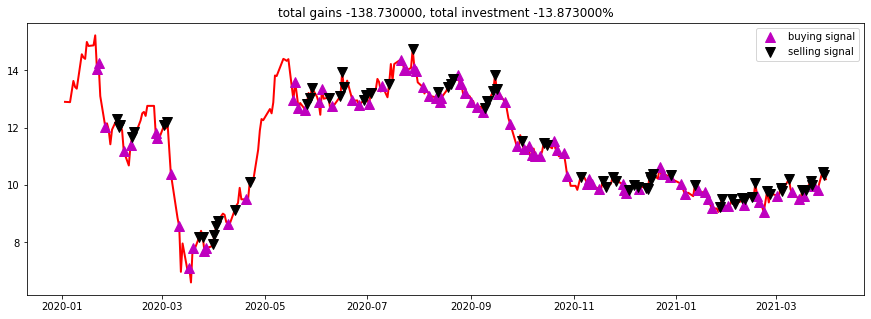

In [230]:
# Plot the results

plot_signals(values = BEEF_actual)

##### Predicted Values

In [231]:
# Define the values for the S Stock

close = BEEF_predictions.values.tolist()

agent = model_reinforcement(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)

# Use the train function
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

epoch: 10, total rewards: -6.010000.3, cost: 0.265835, total money: 35.610701
epoch: 20, total rewards: -8.910504.3, cost: 0.318880, total money: 4.322867
epoch: 30, total rewards: -25.224554.3, cost: 0.307043, total money: 5.247859
epoch: 40, total rewards: -14.355881.3, cost: 0.280584, total money: 3.291570
epoch: 50, total rewards: -17.197304.3, cost: 0.195397, total money: 123.781708
epoch: 60, total rewards: -33.338411.3, cost: 0.167228, total money: 191.157004
epoch: 70, total rewards: -54.785875.3, cost: 0.148520, total money: 224.781896
epoch: 80, total rewards: -73.948622.3, cost: 0.118195, total money: 306.091647
epoch: 90, total rewards: -86.646358.3, cost: 0.083284, total money: 395.042171
epoch: 100, total rewards: -98.302192.3, cost: 0.080813, total money: 408.076337


In [232]:
# Get the buy and sell signals

states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 3: buy 1 unit at price 13.420000, total balance 986.580000
day 4: buy 1 unit at price 13.360000, total balance 973.220000
day 7: buy 1 unit at price 14.400000, total balance 958.820000
day 10: buy 1 unit at price 14.870000, total balance 943.950000
day 21: buy 1 unit at price 12.040000, total balance 931.910000
day 22: buy 1 unit at price 12.100000, total balance 919.810000
day 28: buy 1 unit at price 11.840000, total balance 907.970000
day 29: buy 1 unit at price 11.790000, total balance 896.180000
day 31: buy 1 unit at price 12.500000, total balance 883.680000
day 32: buy 1 unit at price 12.550000, total balance 871.130000
day 33: buy 1 unit at price 12.410000, total balance 858.720000
day 35: buy 1 unit at price 12.760000, total balance 845.960000
day 36: buy 1 unit at price 11.800000, total balance 834.160000
day 41: buy 1 unit at price 12.200000, total balance 821.960000
day 42: buy 1 unit at price 11.300000, total balance 810.660000
day 53: buy 1 unit at price 8.200000, total

day 263, sell 1 unit at price 9.436703, investment -34.147225 %, total balance 378.650258,
day 264, sell 1 unit at price 9.279644, investment -28.891614 %, total balance 387.929903,
day 265, sell 1 unit at price 9.194947, investment -31.329749 %, total balance 397.124849,
day 266, sell 1 unit at price 9.112549, investment -29.250399 %, total balance 406.237398,
day 267, sell 1 unit at price 9.169742, investment -29.733776 %, total balance 415.407140,
day 269, sell 1 unit at price 9.388260, investment -30.042775 %, total balance 424.795400,
day 270, sell 1 unit at price 9.361441, investment -30.449915 %, total balance 434.156841,
day 271: buy 1 unit at price 9.331208, total balance 424.825633
day 272: buy 1 unit at price 9.413091, total balance 415.412542
day 273, sell 1 unit at price 9.430318, investment -28.558194 %, total balance 424.842860,
day 274, sell 1 unit at price 9.423970, investment -30.655114 %, total balance 434.266830,
day 275, sell 1 unit at price 9.424766, investment -2

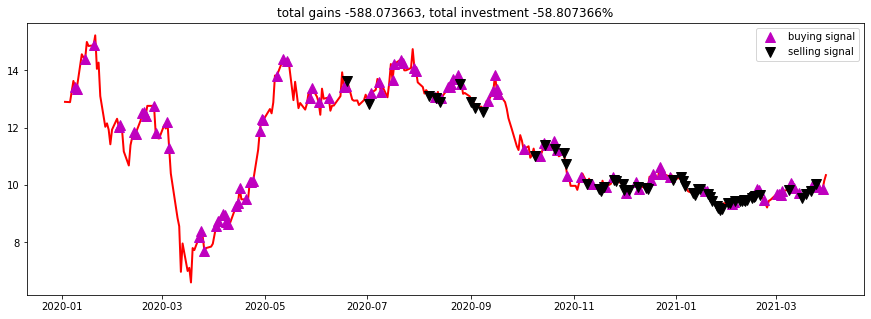

In [233]:
# Plot the results

plot_signals(values = BEEF_predictions)

#### P Stock

##### Actual Values

In [234]:
# Define the values for the S Stock

close = P_actual.values.tolist()

agent = model_reinforcement(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)

# Use the train function
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

epoch: 10, total rewards: 99.100000.3, cost: 0.022061, total money: 924.650000
epoch: 20, total rewards: 102.000000.3, cost: 0.019586, total money: 1015.700000
epoch: 30, total rewards: 98.700000.3, cost: 0.018237, total money: 1012.400000
epoch: 40, total rewards: 98.750000.3, cost: 0.022950, total money: 835.400000
epoch: 50, total rewards: 93.250000.3, cost: 0.016273, total money: 1006.950000
epoch: 60, total rewards: 99.450000.3, cost: 0.015542, total money: 1013.150000
epoch: 70, total rewards: 86.400000.3, cost: 0.014041, total money: 1000.100000
epoch: 80, total rewards: 70.350000.3, cost: 0.017918, total money: 895.900000
epoch: 90, total rewards: 56.750000.3, cost: 0.013019, total money: 970.450000
epoch: 100, total rewards: 64.550000.3, cost: 0.013637, total money: 1064.550000


In [235]:
# Get the buy and sell signals

states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 5: buy 1 unit at price 47.600000, total balance 952.400000
day 7: buy 1 unit at price 46.700000, total balance 905.700000
day 8, sell 1 unit at price 46.700000, investment -1.890756 %, total balance 952.400000,
day 9, sell 1 unit at price 48.350000, investment 3.533191 %, total balance 1000.750000,
day 11: buy 1 unit at price 46.900000, total balance 953.850000
day 12: buy 1 unit at price 48.450000, total balance 905.400000
day 14: buy 1 unit at price 44.800000, total balance 860.600000
day 15, sell 1 unit at price 45.300000, investment -3.411514 %, total balance 905.900000,
day 16, sell 1 unit at price 46.300000, investment -4.437564 %, total balance 952.200000,
day 18, sell 1 unit at price 45.800000, investment 2.232143 %, total balance 998.000000,
day 20: buy 1 unit at price 47.750000, total balance 950.250000
day 22: buy 1 unit at price 46.350000, total balance 903.900000
day 23: buy 1 unit at price 46.950000, total balance 856.950000
day 24: buy 1 unit at price 47.000000, tota

day 255: buy 1 unit at price 76.000000, total balance 898.650000
day 256, sell 1 unit at price 77.500000, investment -1.898734 %, total balance 976.150000,
day 257, sell 1 unit at price 77.000000, investment 1.315789 %, total balance 1053.150000,
day 260: buy 1 unit at price 78.800000, total balance 974.350000
day 261, sell 1 unit at price 80.500000, investment 2.157360 %, total balance 1054.850000,
day 262: buy 1 unit at price 76.300000, total balance 978.550000
day 263: buy 1 unit at price 74.800000, total balance 903.750000
day 264, sell 1 unit at price 75.000000, investment -1.703801 %, total balance 978.750000,
day 265, sell 1 unit at price 80.200000, investment 7.219251 %, total balance 1058.950000,
day 269: buy 1 unit at price 81.000000, total balance 977.950000
day 271: buy 1 unit at price 80.000000, total balance 897.950000
day 272, sell 1 unit at price 83.650000, investment 3.271605 %, total balance 981.600000,
day 273, sell 1 unit at price 84.500000, investment 5.625000 %, t

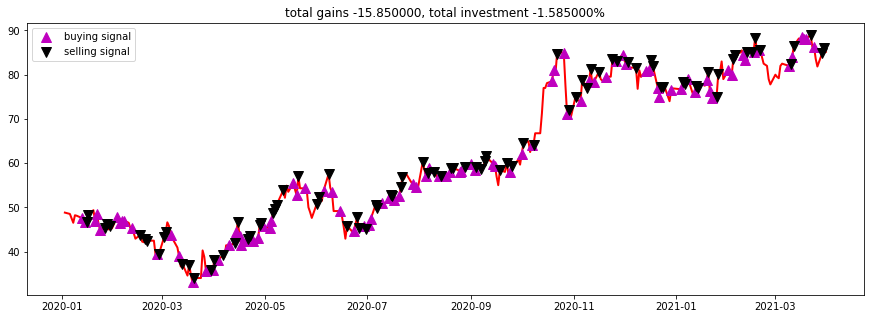

In [236]:
# Plot the results

plot_signals(values = P_actual)

##### Predicted Values

In [237]:
# Define the values for the S Stock

close = P_predictions.values.tolist()

agent = model_reinforcement(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)

# Use the train function
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

epoch: 10, total rewards: 16.686883.3, cost: 0.010794, total money: 1016.686883
epoch: 20, total rewards: 19.136883.3, cost: 0.010441, total money: 1019.136883
epoch: 30, total rewards: 23.936883.3, cost: 0.009972, total money: 1023.936883
epoch: 40, total rewards: 21.955427.3, cost: 0.009860, total money: 1021.955427
epoch: 50, total rewards: 9.305427.3, cost: 0.010343, total money: 1009.305427
epoch: 60, total rewards: 17.205427.3, cost: 0.009736, total money: 1017.205427
epoch: 70, total rewards: 15.279528.3, cost: 0.009666, total money: 1015.279528
epoch: 80, total rewards: 10.686028.3, cost: 0.009747, total money: 1010.686028
epoch: 90, total rewards: 10.284864.3, cost: 0.009608, total money: 1010.284864
epoch: 100, total rewards: 11.730918.3, cost: 0.004101, total money: 1011.730918


In [238]:
# Get the buy and sell signals

states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 4: buy 1 unit at price 48.100000, total balance 951.900000
day 7, sell 1 unit at price 46.700000, investment -2.910603 %, total balance 998.600000,
day 8: buy 1 unit at price 46.700000, total balance 951.900000
day 9, sell 1 unit at price 48.350000, investment 3.533191 %, total balance 1000.250000,
day 13: buy 1 unit at price 46.400000, total balance 953.850000
day 16, sell 1 unit at price 46.300000, investment -0.215517 %, total balance 1000.150000,
day 19: buy 1 unit at price 45.200000, total balance 954.950000
day 20, sell 1 unit at price 47.750000, investment 5.641593 %, total balance 1002.700000,
day 27: buy 1 unit at price 45.300000, total balance 957.400000
day 28, sell 1 unit at price 44.150000, investment -2.538631 %, total balance 1001.550000,
day 30: buy 1 unit at price 43.800000, total balance 957.750000
day 31, sell 1 unit at price 42.250000, investment -3.538813 %, total balance 1000.000000,
day 37: buy 1 unit at price 39.400000, total balance 960.600000
day 38: buy 1

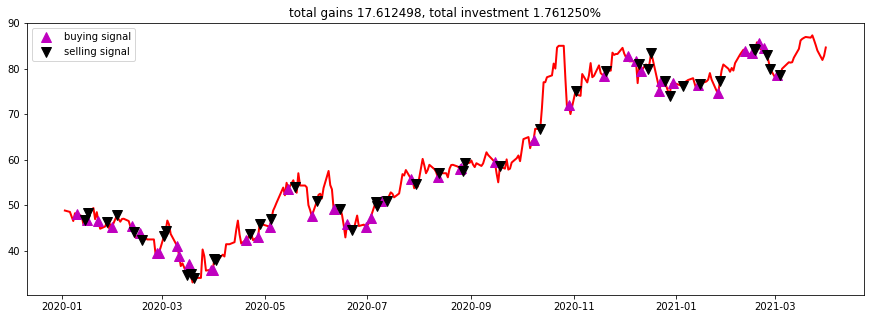

In [239]:
# Plot the results

plot_signals(values = P_predictions)

#### C Stock

##### Actual Values

In [240]:
# Different variables for this stock (May vary depending on the stock)
initial_money = 10000

# Define the values for the S Stock

close = C_actual.values.tolist()

agent = model_reinforcement(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)

# Use the train function
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

epoch: 10, total rewards: 1124.000000.3, cost: 0.323876, total money: 11124.000000
epoch: 20, total rewards: -2199.000000.3, cost: 0.091547, total money: 7801.000000
epoch: 30, total rewards: -659.000000.3, cost: 0.069703, total money: 9341.000000
epoch: 40, total rewards: -426.000000.3, cost: 0.088161, total money: 9574.000000
epoch: 50, total rewards: -285.000000.3, cost: 0.060534, total money: 4685.000000
epoch: 60, total rewards: -439.000000.3, cost: 0.025864, total money: 9561.000000
epoch: 70, total rewards: 610.000000.3, cost: 0.031641, total money: 10610.000000
epoch: 80, total rewards: 124.000000.3, cost: 0.021477, total money: 10124.000000
epoch: 90, total rewards: -401.000000.3, cost: 0.013417, total money: 9599.000000
epoch: 100, total rewards: 360.000000.3, cost: 0.088354, total money: 10360.000000


In [241]:
# Get the buy and sell signals

states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 6: buy 1 unit at price 6640.000000, total balance 3360.000000
day 8, sell 1 unit at price 6580.000000, investment -0.903614 %, total balance 9940.000000,
day 15: buy 1 unit at price 6450.000000, total balance 3490.000000
day 22, sell 1 unit at price 6530.000000, investment 1.240310 %, total balance 10020.000000,
day 23: buy 1 unit at price 6390.000000, total balance 3630.000000
day 25, sell 1 unit at price 6220.000000, investment -2.660407 %, total balance 9850.000000,
day 27: buy 1 unit at price 6230.000000, total balance 3620.000000
day 32, sell 1 unit at price 6110.000000, investment -1.926164 %, total balance 9730.000000,
day 37: buy 1 unit at price 5200.000000, total balance 4530.000000
day 38, sell 1 unit at price 5300.000000, investment 1.923077 %, total balance 9830.000000,
day 40: buy 1 unit at price 4920.000000, total balance 4910.000000
day 42, sell 1 unit at price 5110.000000, investment 3.861789 %, total balance 10020.000000,
day 48: buy 1 unit at price 3040.000000, to

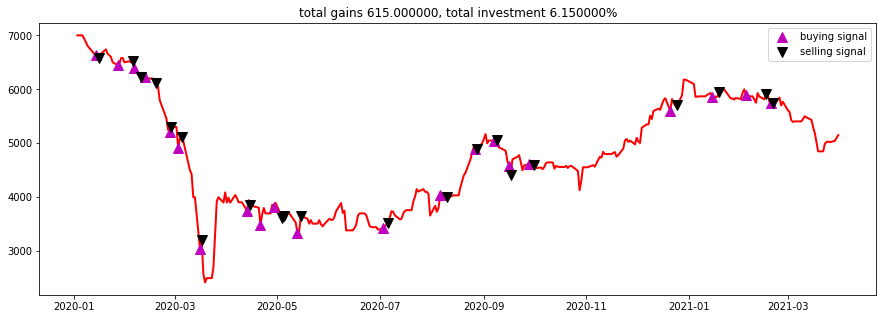

In [242]:
# Plot the results

plot_signals(values = C_actual)

##### Predicted Values

In [243]:
# Define the values for the S Stock

close = C_predictions.values.tolist()

agent = model_reinforcement(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)

# Use the train function
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

epoch: 10, total rewards: 902.903856.3, cost: 0.257009, total money: 10902.903856
epoch: 20, total rewards: 2252.559513.3, cost: 0.142293, total money: 12252.559513
epoch: 30, total rewards: 1514.481007.3, cost: 0.111716, total money: 11514.481007
epoch: 40, total rewards: 1107.873680.3, cost: 0.046817, total money: 11107.873680
epoch: 50, total rewards: 1336.695958.3, cost: 0.037042, total money: 11336.695958
epoch: 60, total rewards: 1067.375441.3, cost: 0.029926, total money: 11067.375441
epoch: 70, total rewards: 585.381273.3, cost: 0.033357, total money: 10585.381273
epoch: 80, total rewards: 549.258994.3, cost: 0.025891, total money: 10549.258994
epoch: 90, total rewards: 474.646412.3, cost: 0.028637, total money: 10474.646412
epoch: 100, total rewards: -679.381884.3, cost: 0.028157, total money: 9320.618116


In [244]:
# Get the buy and sell signals

states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 23: buy 1 unit at price 6390.000000, total balance 3610.000000
day 25, sell 1 unit at price 6220.000000, investment -2.660407 %, total balance 9830.000000,
day 32: buy 1 unit at price 6110.000000, total balance 3720.000000
day 36, sell 1 unit at price 5250.000000, investment -14.075286 %, total balance 8970.000000,
day 40: buy 1 unit at price 4920.000000, total balance 4050.000000
day 42, sell 1 unit at price 5110.000000, investment 3.861789 %, total balance 9160.000000,
day 44: buy 1 unit at price 4500.000000, total balance 4660.000000
day 47, sell 1 unit at price 4000.000000, investment -11.111111 %, total balance 8660.000000,
day 70: buy 1 unit at price 3855.000000, total balance 4805.000000
day 71, sell 1 unit at price 3860.000000, investment 0.129702 %, total balance 8665.000000,
day 98: buy 1 unit at price 3500.000000, total balance 5165.000000
day 99, sell 1 unit at price 3460.000000, investment -1.142857 %, total balance 8625.000000,
day 111: buy 1 unit at price 3430.000000

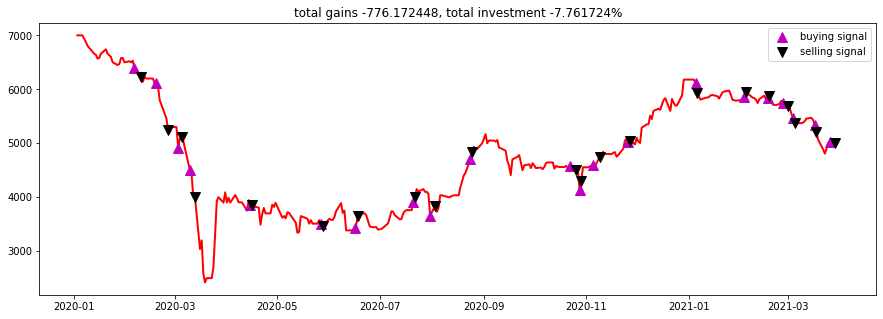

In [245]:
# Plot the results

plot_signals(values = C_predictions)

#### IP Stock

##### Actual Values

In [246]:
# Different variables for this stock (May vary depending on the stock)
initial_money = 100000

# Define the values for the S Stock

close = IP_actual.values.tolist()

agent = model_reinforcement(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)

# Use the train function
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

epoch: 10, total rewards: 3378.000000.3, cost: nan, total money: 103378.000000
epoch: 20, total rewards: 0.000000.3, cost: nan, total money: 63560.000000
epoch: 30, total rewards: 1716.000000.3, cost: nan, total money: 90116.000000
epoch: 40, total rewards: 0.000000.3, cost: nan, total money: 100000.000000
epoch: 50, total rewards: 1507.000000.3, cost: nan, total money: 84227.000000
epoch: 60, total rewards: 0.000000.3, cost: nan, total money: 100000.000000
epoch: 70, total rewards: 0.000000.3, cost: nan, total money: 73504.000000
epoch: 80, total rewards: 10624.000000.3, cost: nan, total money: 83782.000000
epoch: 90, total rewards: 0.000000.3, cost: nan, total money: 100000.000000
epoch: 100, total rewards: 0.000000.3, cost: nan, total money: 100000.000000


In [247]:
# Get the buy and sell signals

states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

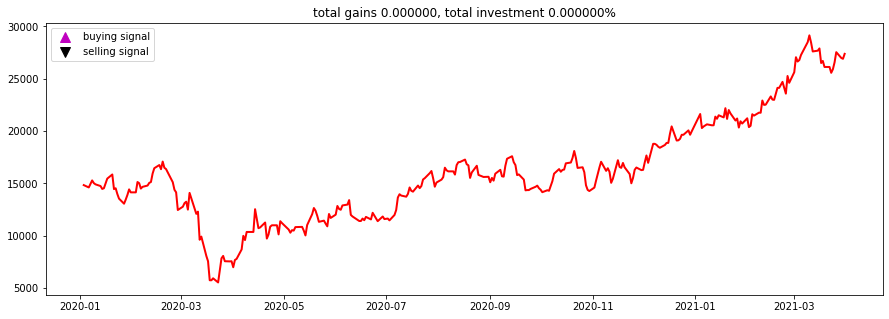

In [248]:
# Plot the results

plot_signals(values = IP_actual)

##### Predicted Values

In [249]:
# Define the values for the S Stock

close = IP_predictions.values.tolist()

agent = model_reinforcement(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)

# Use the train function
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

epoch: 10, total rewards: 13056.276367.3, cost: nan, total money: 92040.598633
epoch: 20, total rewards: 0.000000.3, cost: nan, total money: 100000.000000
epoch: 30, total rewards: 0.000000.3, cost: nan, total money: 100000.000000
epoch: 40, total rewards: 5368.000000.3, cost: nan, total money: 84758.424805
epoch: 50, total rewards: 0.000000.3, cost: nan, total money: 66071.946289
epoch: 60, total rewards: 0.000000.3, cost: nan, total money: 100000.000000
epoch: 70, total rewards: -626.000000.3, cost: nan, total money: 74043.968750
epoch: 80, total rewards: 0.000000.3, cost: nan, total money: 74235.110352
epoch: 90, total rewards: 0.000000.3, cost: nan, total money: 100000.000000
epoch: 100, total rewards: 1646.254883.3, cost: nan, total money: 101646.254883


In [250]:
# Get the buy and sell signals

states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 58: buy 1 unit at price 7559.000000, total balance 92441.000000
day 140, sell 1 unit at price 15497.000000, investment 105.013891 %, total balance 107938.000000,
day 273: buy 1 unit at price 20958.326172, total balance 86979.673828
day 295: buy 1 unit at price 26922.224609, total balance 60057.449219


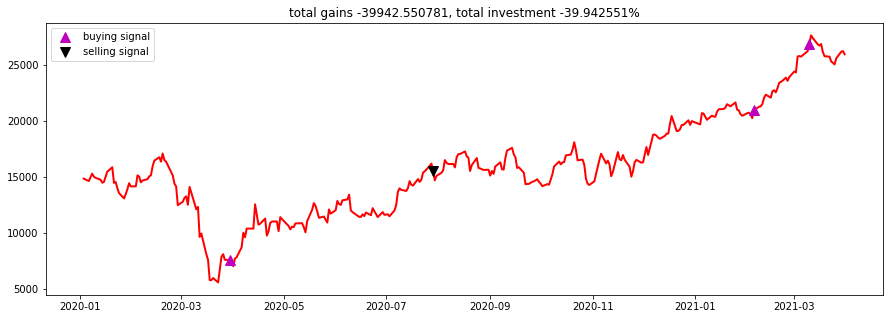

In [251]:
# Plot the results

plot_signals(values = IP_predictions)

#### DS Stock

##### Actual Values

In [252]:
# Define the values for the S Stock

close = DS_actual.values.tolist()

agent = model_reinforcement(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)

# Use the train function
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

epoch: 10, total rewards: 5680.000000.3, cost: 2.784439, total money: 105680.000000
epoch: 20, total rewards: 79560.000000.3, cost: 0.355762, total money: 21710.000000
epoch: 30, total rewards: 82425.000000.3, cost: 0.048625, total money: 17015.000000
epoch: 40, total rewards: 79475.000000.3, cost: 0.052047, total money: 31855.000000
epoch: 50, total rewards: 79185.000000.3, cost: 0.029877, total money: 43405.000000
epoch: 60, total rewards: 50240.000000.3, cost: 0.045722, total money: 39380.000000
epoch: 70, total rewards: 83200.000000.3, cost: 0.060387, total money: 46640.000000
epoch: 80, total rewards: 76175.000000.3, cost: 0.018406, total money: 41515.000000
epoch: 90, total rewards: 87990.000000.3, cost: 0.060608, total money: 57040.000000
epoch: 100, total rewards: 82330.000000.3, cost: 0.076414, total money: 80110.000000


In [253]:
# Get the buy and sell signals

states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 0: buy 1 unit at price 5900.000000, total balance 94100.000000
day 1: buy 1 unit at price 5730.000000, total balance 88370.000000
day 5, sell 1 unit at price 5520.000000, investment -6.440678 %, total balance 93890.000000,
day 6, sell 1 unit at price 5510.000000, investment -3.839442 %, total balance 99400.000000,
day 8: buy 1 unit at price 5520.000000, total balance 93880.000000
day 9, sell 1 unit at price 5490.000000, investment -0.543478 %, total balance 99370.000000,
day 10: buy 1 unit at price 5490.000000, total balance 93880.000000
day 12: buy 1 unit at price 5450.000000, total balance 88430.000000
day 14: buy 1 unit at price 5460.000000, total balance 82970.000000
day 15: buy 1 unit at price 5460.000000, total balance 77510.000000
day 16: buy 1 unit at price 5020.000000, total balance 72490.000000
day 17: buy 1 unit at price 5020.000000, total balance 67470.000000
day 20: buy 1 unit at price 4855.000000, total balance 62615.000000
day 21: buy 1 unit at price 4905.000000, tot

day 239, sell 1 unit at price 7930.000000, investment 14.265130 %, total balance 15075.000000,
day 241, sell 1 unit at price 8100.000000, investment 17.903930 %, total balance 23175.000000,
day 242: buy 1 unit at price 8180.000000, total balance 14995.000000
day 244: buy 1 unit at price 7820.000000, total balance 7175.000000
day 253, sell 1 unit at price 9270.000000, investment 40.881459 %, total balance 16445.000000,
day 254: buy 1 unit at price 8990.000000, total balance 7455.000000
day 255, sell 1 unit at price 8930.000000, investment 35.508346 %, total balance 16385.000000,
day 256, sell 1 unit at price 9060.000000, investment 35.426009 %, total balance 25445.000000,
day 257, sell 1 unit at price 9130.000000, investment 38.543247 %, total balance 34575.000000,
day 260, sell 1 unit at price 8800.000000, investment 35.802469 %, total balance 43375.000000,
day 261: buy 1 unit at price 8690.000000, total balance 34685.000000
day 263: buy 1 unit at price 8720.000000, total balance 25965

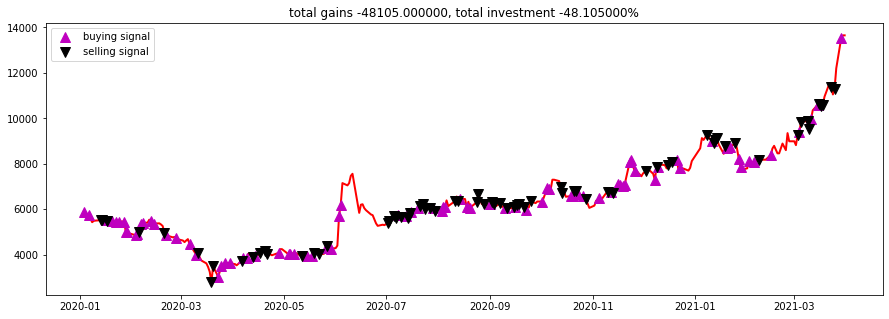

In [254]:
# Plot the results

plot_signals(values = DS_actual)

##### Predicted Values

In [255]:
# Define the values for the S Stock

close = DS_predictions.values.tolist()

agent = model_reinforcement(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)

# Use the train function
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

epoch: 10, total rewards: 40291.165039.3, cost: 0.401763, total money: 89403.712402
epoch: 20, total rewards: 44260.286621.3, cost: 0.183574, total money: 42887.889160
epoch: 30, total rewards: 38989.810059.3, cost: 0.054240, total money: 96201.964355
epoch: 40, total rewards: 13537.962891.3, cost: 0.271420, total money: 102942.544434
epoch: 50, total rewards: 29159.810059.3, cost: 0.016144, total money: 86371.964355
epoch: 60, total rewards: 24454.795898.3, cost: 0.036044, total money: 114866.384277
epoch: 70, total rewards: 35078.718750.3, cost: 0.050192, total money: 100875.628418
epoch: 80, total rewards: 46769.108887.3, cost: 0.045217, total money: 88412.432129
epoch: 90, total rewards: 47078.512939.3, cost: 0.020147, total money: 54439.541504
epoch: 100, total rewards: 37041.472168.3, cost: 0.032095, total money: 78812.729492


In [256]:
# Get the buy and sell signals

states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 1: buy 1 unit at price 5730.000000, total balance 94270.000000
day 2: buy 1 unit at price 5430.000000, total balance 88840.000000
day 3, sell 1 unit at price 5490.000000, investment -4.188482 %, total balance 94330.000000,
day 4, sell 1 unit at price 5500.000000, investment 1.289134 %, total balance 99830.000000,
day 10: buy 1 unit at price 5490.000000, total balance 94340.000000
day 11: buy 1 unit at price 5460.000000, total balance 88880.000000
day 12: buy 1 unit at price 5450.000000, total balance 83430.000000
day 13, sell 1 unit at price 5460.000000, investment -0.546448 %, total balance 88890.000000,
day 14, sell 1 unit at price 5460.000000, investment 0.000000 %, total balance 94350.000000,
day 15: buy 1 unit at price 5460.000000, total balance 88890.000000
day 16: buy 1 unit at price 5020.000000, total balance 83870.000000
day 17: buy 1 unit at price 5020.000000, total balance 78850.000000
day 18, sell 1 unit at price 4935.000000, investment -9.449541 %, total balance 83785.

day 215: buy 1 unit at price 6750.000000, total balance 39750.000000
day 216: buy 1 unit at price 6700.000000, total balance 33050.000000
day 217, sell 1 unit at price 7120.000000, investment 17.105263 %, total balance 40170.000000,
day 218: buy 1 unit at price 7060.000000, total balance 33110.000000
day 222: buy 1 unit at price 8070.000000, total balance 25040.000000
day 226: buy 1 unit at price 7690.000000, total balance 17350.000000
day 227: buy 1 unit at price 7450.000000, total balance 9900.000000
day 228, sell 1 unit at price 7580.000000, investment 20.893142 %, total balance 17480.000000,
day 229, sell 1 unit at price 7630.000000, investment 20.347003 %, total balance 25110.000000,
day 231, sell 1 unit at price 7770.000000, investment 6.438356 %, total balance 32880.000000,
day 232, sell 1 unit at price 7560.000000, investment 15.419847 %, total balance 40440.000000,
day 233: buy 1 unit at price 7290.000000, total balance 33150.000000
day 234, sell 1 unit at price 7870.000000, i

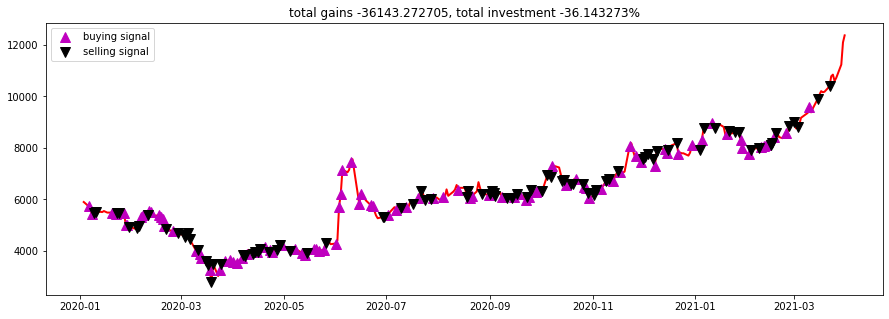

In [257]:
# Plot the results

plot_signals(values = DS_predictions)

## Approach

1. Get the historical data of the stock prices
2. Preprocess the data. Apply MinMax Scaler, re arrange the data and use the 5 days prior as independant variables and the day ahead as the dependant variable and make sure to use the correct dimensions for the data, and after applying the MinMax Scaler, prevent data leakeage by just fitting the train data
3. To foreast values, we are going to to use LSTM to see the general trend. As a note, depending on the days of data and the number of days used as independant features, we may be able to forecast prices with a longer period.
4. To calculate the next day forecast, we are using arima model (This won't work for long forecasting periods as it would capture the general trend).
5. To calculate the overal performance of both, we are using the bollinger bands and each indicator would give buy-sell signals.
6. We are calculating the weighted average between the arima model and the LSTM model.
7. We are using reinforcement learnings to check the overal buy and sell recommendations based on the forecast made with the LSTM and compare the results with the actual results. For the reinforcement learning you should input a sufficient initial investment to cover one stock price

## Other Stocks

### BRF SA

In [258]:
# Create a function that reads the data from yahoo finance
def stock_data(ticker, data_source, start, end):
    df = DataReader(ticker, data_source, start, end)['Adj Close']
    df = df.to_frame(ticker) 
    return df

In [265]:
def feature_engineering(train_array, test_array, time_steps):
    scaler = MinMaxScaler(feature_range = (0,1))
    a = train_array.reshape(-1,1)
    b = test_array.reshape(-1,1)
    scaler = scaler.fit(a)
    X = scaler.transform(a)
    y = scaler.transform(b)
    
    data = np.append(X, y).reshape(-1,1)
    
    dataX, dataY = [], []
    
    for i in range(len(data)-time_steps-1):
        c = data[i:(i+time_steps), 0]   
        dataX.append(c)
        dataY.append(data[i + time_steps, 0])
        
    # Divide one again into train and test data

    X_train = np.array(dataX[:len(train_array)- time_steps - 1])
    y_train = np.array(dataY[:len(train_array)- time_steps - 1])

    X_test = np.array(dataX[len(train_array)- time_steps - 1:])
    y_test = np.array(dataY[len(train_array)- time_steps -1:])
    
    X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
    X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
        
    return X_train, y_train, X_test, y_test

In [260]:
def weighted_predictions(stock, lstm_predictions, arima_predictions):
    outcome = (lstm_predictions*0.5) + (arima_predictions*0.5)
    df = pd.DataFrame()
    df['Date'] = stock['2021'].index
    df.set_index('Date', inplace = True)
    df['Price'] = outcome
    df.columns = stock.columns
    return df
    

In [261]:
#Define variables of data source, start and end date

start = datetime.date(2020,1,1)
end = datetime.date(2021,3,31)
source = 'yahoo'

In [262]:
# Get BRFS stock data

brfs_stock = stock_data('BRFS3.SA', source, start, end)

In [263]:
# Train and test data set

brfs_train = brfs_stock['2020'].values

brfs_test = brfs_stock['2021'].values

In [266]:
# Apply feature engineering

brfs_xtrain, brfs_ytrain, brfs_xtest, brfs_ytest = feature_engineering(train_array = brfs_train, 
                                                                       test_array = brfs_test, time_steps = 5)

In [267]:
# Define the neural network model

model = neural_network()

In [268]:
# Use the function to predict

brfs_pred = model_fit(Xtr = brfs_xtrain, ytr = brfs_ytrain, Xte = brfs_xtest)

Train on 241 samples
Epoch 1/100
241/241 [==============================] - 0s 381us/sample - loss: 0.1433
Epoch 2/100
241/241 [==============================] - 0s 501us/sample - loss: 0.0469
Epoch 3/100
241/241 [==============================] - 0s 457us/sample - loss: 0.0278
Epoch 4/100
241/241 [==============================] - 0s 364us/sample - loss: 0.0161
Epoch 5/100
241/241 [==============================] - 0s 349us/sample - loss: 0.0135
Epoch 6/100
241/241 [==============================] - 0s 357us/sample - loss: 0.0094
Epoch 7/100
241/241 [==============================] - 0s 464us/sample - loss: 0.0063
Epoch 8/100
241/241 [==============================] - 0s 357us/sample - loss: 0.0069
Epoch 9/100
241/241 [==============================] - 0s 344us/sample - loss: 0.0062
Epoch 10/100
241/241 [==============================] - 0s 429us/sample - loss: 0.0063
Epoch 11/100
241/241 [==============================] - 0s 350us/sample - loss: 0.0050
Epoch 12/100
241/241 [=========

241/241 [==============================] - 0s 609us/sample - loss: 0.0046
Epoch 96/100
241/241 [==============================] - 0s 636us/sample - loss: 0.0050
Epoch 97/100
241/241 [==============================] - 0s 716us/sample - loss: 0.0043
Epoch 98/100
241/241 [==============================] - 0s 827us/sample - loss: 0.0051
Epoch 99/100
241/241 [==============================] - 0s 629us/sample - loss: 0.0050
Epoch 100/100
241/241 [==============================] - 0s 650us/sample - loss: 0.0039


In [269]:
# Use the inverse transform function

brfs_pred = scaler_inverse(train_array = brfs_stock.values, predictions = brfs_pred)

brfs_pred = brfs_pred.reshape(brfs_pred.shape[0])


In [270]:
# Run the arima function

arima_selection(values = brfs_stock)

(ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(0, 0, 0, 5),
       suppress_warnings=True, with_intercept=False),
 <class 'statsmodels.iolib.summary.Summary'>
 """
                                SARIMAX Results                                
 Dep. Variable:                      y   No. Observations:                  306
 Model:               SARIMAX(0, 1, 0)   Log Likelihood                -343.059
 Date:                Mon, 14 Jun 2021   AIC                            688.118
 Time:                        20:19:36   BIC                            691.839
 Sample:                             0   HQIC                           689.606
                                 - 306                                         
 Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
 ------------------------------------------------------------------------------
 sigma2         0.5553    

In [271]:
# Get the best order for the stock

brfs_pred_arima = model_fit_arima(df = brfs_stock, col = 'BRFS3.SA', order = (0,1,0))

In [272]:
# Weighted average to do the predictions

brfs_pred = weighted_predictions(stock = brfs_stock, lstm_predictions = brfs_pred, 
                                 arima_predictions = brfs_pred_arima)

In [273]:
# Append data frames

brfs_stock_pred = brfs_stock['2020'].append(brfs_pred)

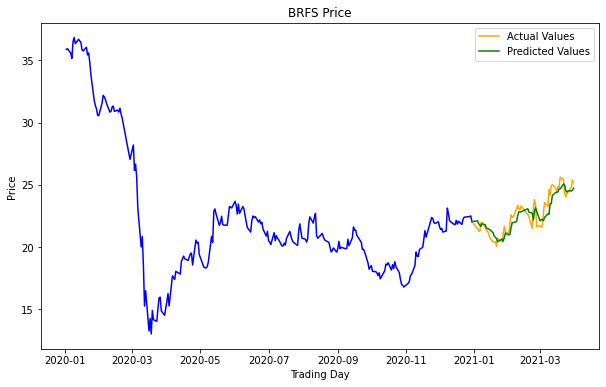

In [274]:
# Plot the graphic

plot_comparison(actual = brfs_stock, predicted = brfs_stock_pred, string = 'BRFS Price')

In [275]:
# Save the predictions and the train in the same data frame

df_brfs_pred = brfs_stock['2020'].append(brfs_pred)

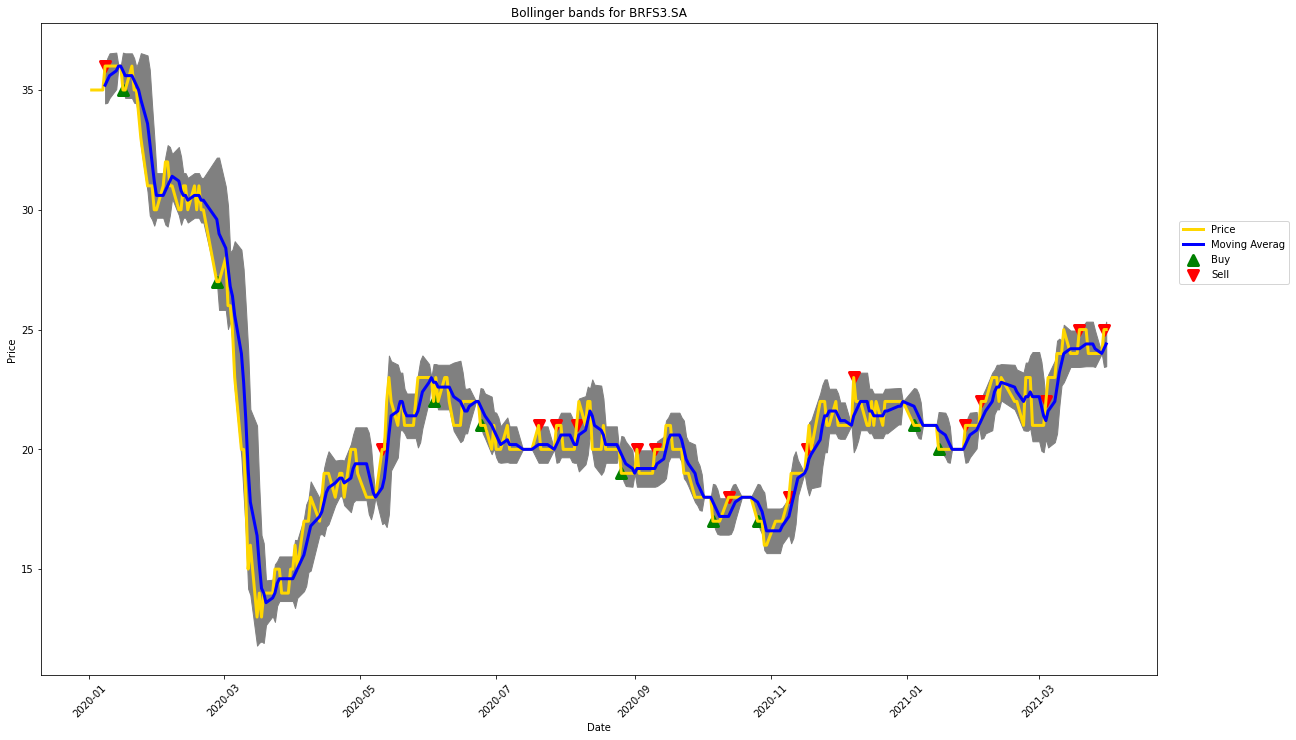

In [276]:
# Bollinger bands for the actual data daily

bollinger_bands(df = brfs_stock, col = 'BRFS3.SA' , p = 5, std = 1.7)

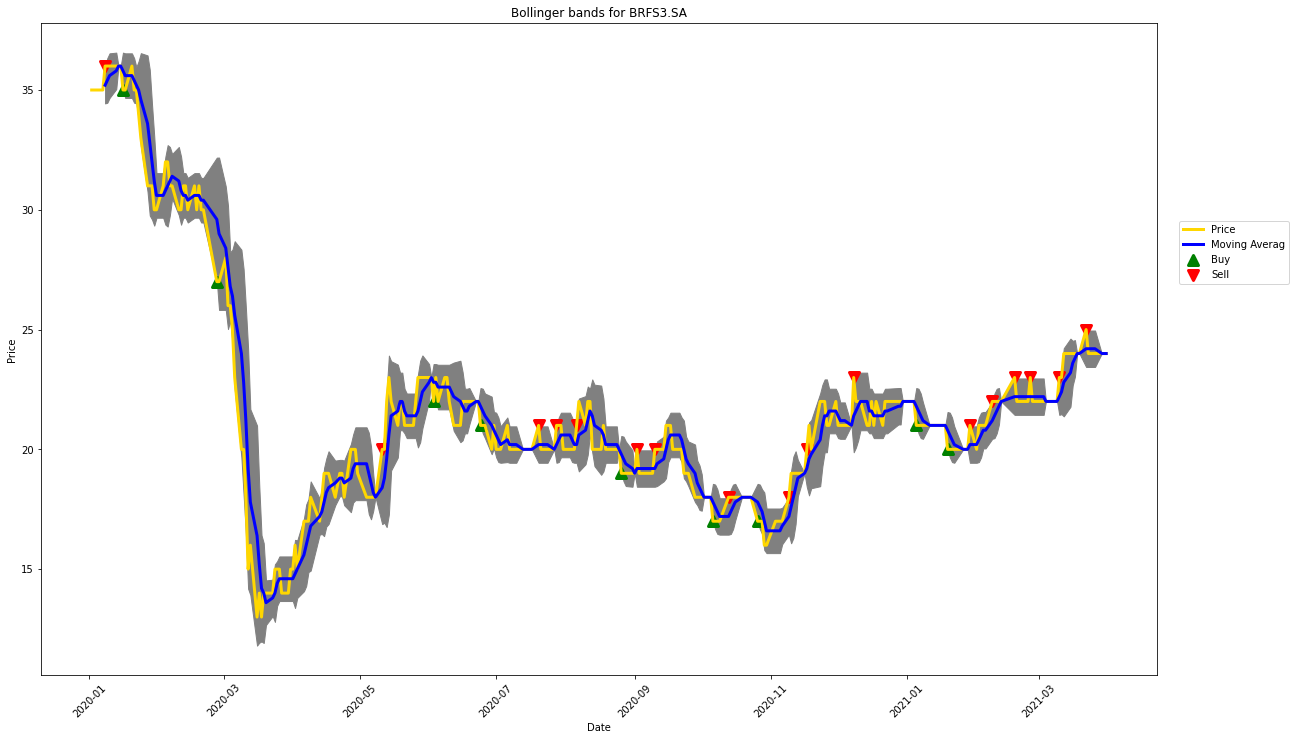

In [277]:
# Bollinger bands for the predicted data daily

bollinger_bands(df = df_brfs_pred, col = 'BRFS3.SA' , p = 5, std = 1.7)

In [278]:
# Define the values for the S Stock

initial_money = 1000

close = df_brfs_pred['BRFS3.SA'].tolist()

agent = model_reinforcement(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)



In [279]:
# Use the train function
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

epoch: 10, total rewards: -15.910069.3, cost: 0.002669, total money: 984.089931
epoch: 20, total rewards: -37.080070.3, cost: 0.003753, total money: 962.919930
epoch: 30, total rewards: -35.052860.3, cost: 0.003498, total money: 964.947140
epoch: 40, total rewards: -27.312276.3, cost: 0.002633, total money: 972.687724
epoch: 50, total rewards: -48.286538.3, cost: 0.003744, total money: 951.713462
epoch: 60, total rewards: -86.475754.3, cost: 0.006316, total money: 913.524246
epoch: 70, total rewards: -43.056433.3, cost: 0.003114, total money: 956.943567
epoch: 80, total rewards: -48.426538.3, cost: 0.003239, total money: 951.573462
epoch: 90, total rewards: -45.596538.3, cost: 0.002826, total money: 954.403462
epoch: 100, total rewards: -47.204018.3, cost: 0.002871, total money: 952.795982


In [280]:
# Get the buy and sell signals

states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 0: buy 1 unit at price 35.880001, total balance 964.119999
day 1: buy 1 unit at price 35.939999, total balance 928.180000
day 2: buy 1 unit at price 35.570000, total balance 892.610001
day 3: buy 1 unit at price 35.160000, total balance 857.450001
day 6, sell 1 unit at price 36.340000, investment 1.282049 %, total balance 893.790001,
day 9: buy 1 unit at price 36.470001, total balance 857.320000
day 10, sell 1 unit at price 35.869999, investment -0.194768 %, total balance 893.189999,
day 11: buy 1 unit at price 35.750000, total balance 857.439999
day 13, sell 1 unit at price 35.430000, investment -0.393588 %, total balance 892.869999,
day 14, sell 1 unit at price 35.599998, investment 1.251418 %, total balance 928.469997,
day 16: buy 1 unit at price 33.830002, total balance 894.639996
day 17: buy 1 unit at price 31.780001, total balance 862.859995
day 18: buy 1 unit at price 31.360001, total balance 831.499994
day 19, sell 1 unit at price 31.100000, investment -14.724433 %, total b

day 244, sell 1 unit at price 22.450001, investment 1.035110 %, total balance 951.879992,
day 246: buy 1 unit at price 22.040001, total balance 929.839991
day 247: buy 1 unit at price 22.103515, total balance 907.736476
day 249: buy 1 unit at price 21.771017, total balance 885.965459
day 250, sell 1 unit at price 21.654515, investment -1.749027 %, total balance 907.619974,
day 252, sell 1 unit at price 21.784141, investment -1.444902 %, total balance 929.404115,
day 253, sell 1 unit at price 21.525383, investment -1.128262 %, total balance 950.929498,
day 255: buy 1 unit at price 21.448659, total balance 929.480839
day 256, sell 1 unit at price 21.395380, investment -0.248402 %, total balance 950.876219,
day 258: buy 1 unit at price 20.856237, total balance 930.019981
day 259: buy 1 unit at price 20.779469, total balance 909.240512
day 260: buy 1 unit at price 20.687669, total balance 888.552843
day 261, sell 1 unit at price 20.416967, investment -2.106181 %, total balance 908.969810,


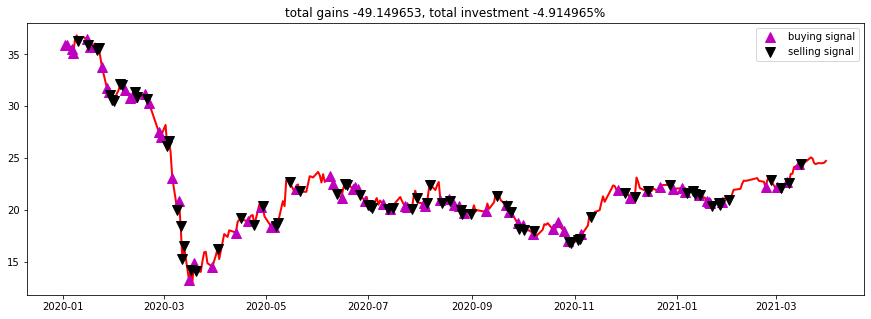

In [281]:
# Plot the results

plot_signals(values = df_brfs_pred['BRFS3.SA'])

### Anglo American Platinum Limited

In [282]:
# Get BRFS stock data

angpy_stock = stock_data('ANGPY', source, start, end)

In [283]:
# Train and test data set

angpy_train = angpy_stock['2020'].values

angpy_test = angpy_stock['2021'].values

In [284]:
# Apply feature engineering

angpy_xtrain, angpy_ytrain, angpy_xtest, angpy_ytest = feature_engineering(train_array = angpy_train, 
                                                                       test_array = angpy_test, time_steps = 5)

In [285]:
# Define the neural network model

model = neural_network()

In [286]:
# Use the function to predict

angpy_pred = model_fit(Xtr = angpy_xtrain, ytr = angpy_ytrain, Xte = angpy_xtest)

Train on 247 samples
Epoch 1/100
247/247 [==============================] - 0s 430us/sample - loss: 0.3226
Epoch 2/100
247/247 [==============================] - 0s 473us/sample - loss: 0.0967
Epoch 3/100
247/247 [==============================] - 0s 424us/sample - loss: 0.0410
Epoch 4/100
247/247 [==============================] - 0s 504us/sample - loss: 0.0203
Epoch 5/100
247/247 [==============================] - 0s 469us/sample - loss: 0.0221
Epoch 6/100
247/247 [==============================] - 0s 500us/sample - loss: 0.0189
Epoch 7/100
247/247 [==============================] - 0s 396us/sample - loss: 0.0158
Epoch 8/100
247/247 [==============================] - 0s 355us/sample - loss: 0.0158
Epoch 9/100
247/247 [==============================] - 0s 469us/sample - loss: 0.0154
Epoch 10/100
247/247 [==============================] - 0s 683us/sample - loss: 0.0135
Epoch 11/100
247/247 [==============================] - 0s 634us/sample - loss: 0.0125
Epoch 12/100
247/247 [=========

247/247 [==============================] - 0s 351us/sample - loss: 0.0084
Epoch 96/100
247/247 [==============================] - 0s 318us/sample - loss: 0.0085
Epoch 97/100
247/247 [==============================] - 0s 439us/sample - loss: 0.0091
Epoch 98/100
247/247 [==============================] - 0s 316us/sample - loss: 0.0086
Epoch 99/100
247/247 [==============================] - 0s 393us/sample - loss: 0.0079
Epoch 100/100
247/247 [==============================] - 0s 435us/sample - loss: 0.0093


In [287]:
# Use the inverse transform function

angpy_pred = scaler_inverse(train_array = angpy_stock.values, predictions = angpy_pred)

angpy_pred = angpy_pred.reshape(angpy_pred.shape[0])


In [288]:
# Run the arima function

arima_selection(values = angpy_stock)

(ARIMA(order=(1, 2, 1), scoring_args={}, seasonal_order=(0, 0, 0, 5),
       suppress_warnings=True, with_intercept=False),
 <class 'statsmodels.iolib.summary.Summary'>
 """
                                SARIMAX Results                                
 Dep. Variable:                      y   No. Observations:                  314
 Model:               SARIMAX(1, 2, 1)   Log Likelihood                -244.031
 Date:                Mon, 14 Jun 2021   AIC                            494.062
 Time:                        20:21:22   BIC                            505.291
 Sample:                             0   HQIC                           498.550
                                 - 314                                         
 Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
 ------------------------------------------------------------------------------
 ar.L1         -0.0969    

In [289]:
# Get the best order for the stock

angpy_pred_arima = model_fit_arima(df = angpy_stock, col = 'ANGPY', order = (1,2,1))

In [290]:
# Weighted average to do the predictions

angpy_pred = weighted_predictions(stock = angpy_stock, lstm_predictions = angpy_pred, 
                                  arima_predictions = angpy_pred_arima)

In [291]:
# Append data frames

angpy_stock_pred = angpy_stock['2020'].append(angpy_pred)

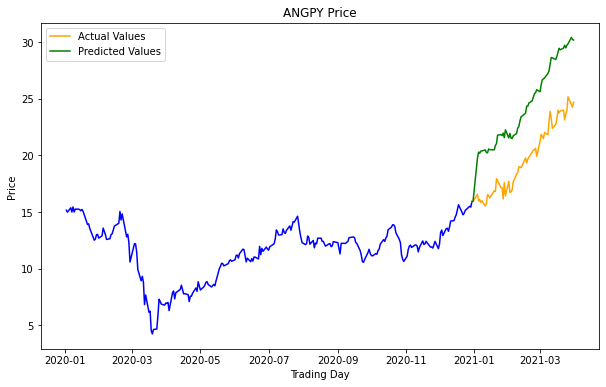

In [292]:
# Plot the graphic

plot_comparison(actual = angpy_stock, predicted = angpy_stock_pred, string = 'ANGPY Price')

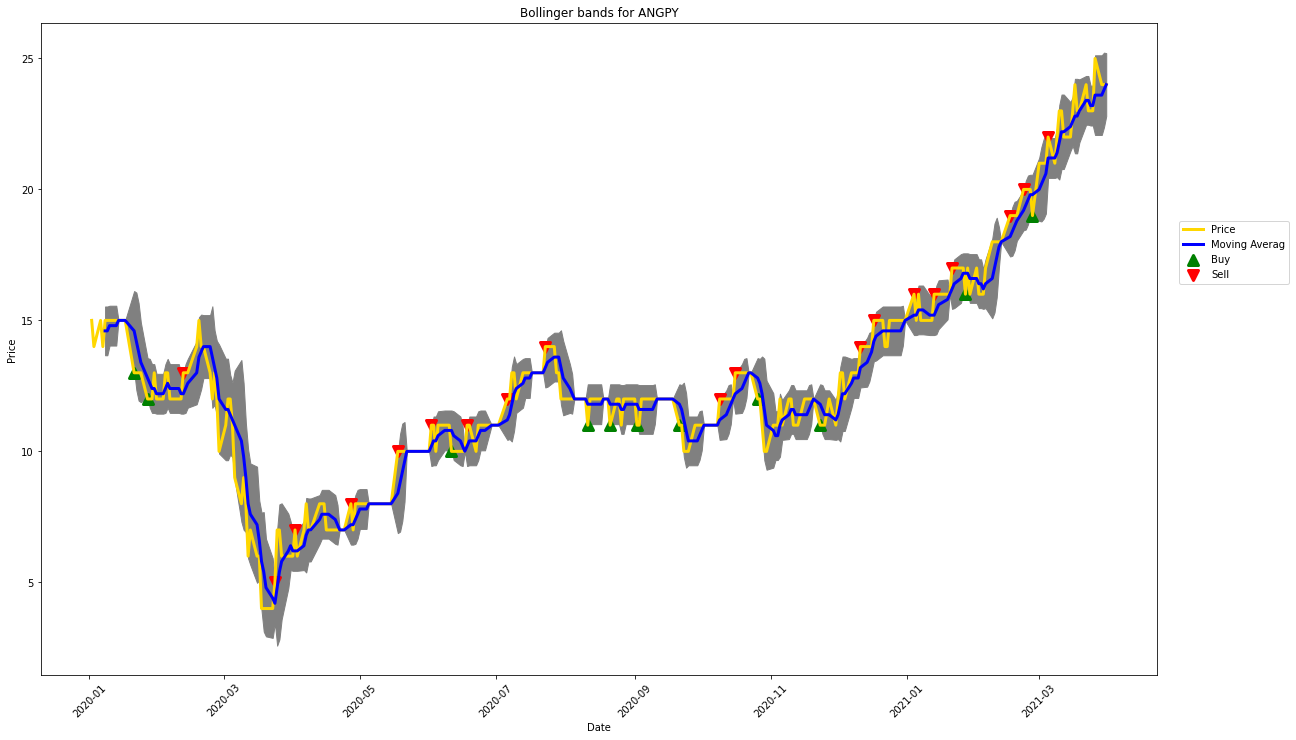

In [293]:
# Bollinger bands for the actual data daily

bollinger_bands(df = angpy_stock, col = 'ANGPY' , p = 5, std = 1.7)

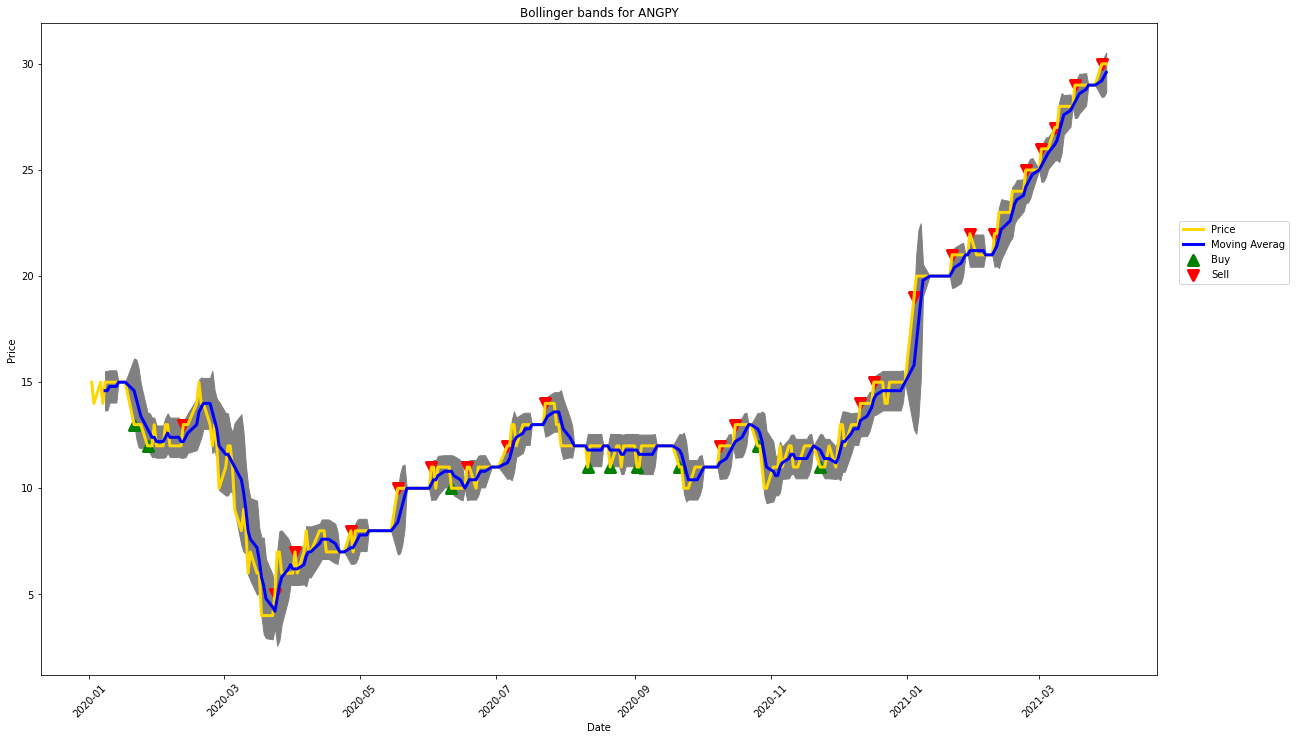

In [294]:
# Bollinger bands for the predicted data daily

bollinger_bands(df = angpy_stock_pred, col = 'ANGPY' , p = 5, std = 1.7)

In [295]:
# Define the values for the S Stock

initial_money = 1000

close = angpy_stock['ANGPY'].tolist()

agent = model_reinforcement(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)



In [296]:
# Use the train function
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

epoch: 10, total rewards: 4.209988.3, cost: 0.002026, total money: 1004.209988
epoch: 20, total rewards: 9.452863.3, cost: 0.001852, total money: 1009.452863
epoch: 30, total rewards: 7.190460.3, cost: 0.001874, total money: 1007.190460
epoch: 40, total rewards: 6.678960.3, cost: 0.001868, total money: 1006.678960
epoch: 50, total rewards: 7.858076.3, cost: 0.001835, total money: 1007.858076
epoch: 60, total rewards: 6.654241.3, cost: 0.001841, total money: 1006.654241
epoch: 70, total rewards: 4.032929.3, cost: 0.001873, total money: 1004.032929
epoch: 80, total rewards: 7.048599.3, cost: 0.001807, total money: 1007.048599
epoch: 90, total rewards: 5.154294.3, cost: 0.001827, total money: 1005.154294
epoch: 100, total rewards: 3.791924.3, cost: 0.001837, total money: 1003.791924


In [297]:
# Get the buy and sell signals

states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 0: buy 1 unit at price 15.159060, total balance 984.840940
day 1: buy 1 unit at price 14.985813, total balance 969.855127
day 2: buy 1 unit at price 15.370804, total balance 954.484324
day 3: buy 1 unit at price 14.995438, total balance 939.488886
day 4, sell 1 unit at price 15.447803, investment 1.904762 %, total balance 954.936689,
day 6, sell 1 unit at price 15.252419, investment 1.779058 %, total balance 970.189109,
day 8, sell 1 unit at price 15.207183, investment -1.064492 %, total balance 985.396292,
day 10, sell 1 unit at price 15.226433, investment 1.540436 %, total balance 1000.622725,
day 11: buy 1 unit at price 15.062812, total balance 985.559913
day 12: buy 1 unit at price 13.888586, total balance 971.671327
day 13, sell 1 unit at price 13.955959, investment -7.348246 %, total balance 985.627286,
day 14: buy 1 unit at price 13.542092, total balance 972.085194
day 15, sell 1 unit at price 13.291848, investment -4.296606 %, total balance 985.377042,
day 17, sell 1 unit a

day 292, sell 1 unit at price 21.846966, investment 9.679005 %, total balance 1003.630944,
day 293: buy 1 unit at price 21.689581, total balance 981.941363
day 295, sell 1 unit at price 22.004353, investment 1.451257 %, total balance 1003.945716,
day 297: buy 1 unit at price 22.988007, total balance 980.957709
day 298, sell 1 unit at price 23.891001, investment 3.928110 %, total balance 1004.848710,
day 299: buy 1 unit at price 23.230000, total balance 981.618711
day 301, sell 1 unit at price 22.728001, investment -2.160994 %, total balance 1004.346711,


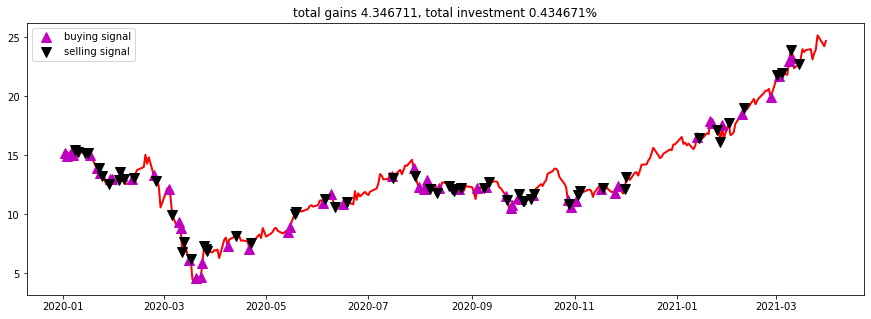

In [298]:
# Plot the results

plot_signals(values = angpy_stock['ANGPY'])

In [299]:
# Define the values for the S Stock

initial_money = 1000

close = angpy_stock_pred['ANGPY'].tolist()

agent = model_reinforcement(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)



In [300]:
# Use the train function
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

epoch: 10, total rewards: 58.674060.3, cost: 0.009213, total money: 1029.217104
epoch: 20, total rewards: 49.661916.3, cost: 0.014722, total money: 962.471504
epoch: 30, total rewards: 44.937834.3, cost: 0.010831, total money: 1015.480878
epoch: 40, total rewards: 49.509211.3, cost: 0.014274, total money: 962.318799
epoch: 50, total rewards: 46.990818.3, cost: 0.011553, total money: 988.444739
epoch: 60, total rewards: 49.351471.3, cost: 0.013842, total money: 962.161059
epoch: 70, total rewards: 49.346631.3, cost: 0.013631, total money: 962.156220
epoch: 80, total rewards: 49.425323.3, cost: 0.013414, total money: 962.234911
epoch: 90, total rewards: 40.895172.3, cost: 0.014100, total money: 925.632778
epoch: 100, total rewards: 50.088433.3, cost: 0.014001, total money: 878.043152


In [301]:
# Get the buy and sell signals

states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 7: buy 1 unit at price 15.255307, total balance 984.744693
day 9: buy 1 unit at price 15.110934, total balance 969.633759
day 10, sell 1 unit at price 15.226433, investment -0.189274 %, total balance 984.860191,
day 12, sell 1 unit at price 13.888586, investment -8.089164 %, total balance 998.748777,
day 21: buy 1 unit at price 12.897231, total balance 985.851546
day 22, sell 1 unit at price 13.580592, investment 5.298510 %, total balance 999.432138,
day 29: buy 1 unit at price 13.397720, total balance 986.034418
day 30: buy 1 unit at price 13.753838, total balance 972.280581
day 32: buy 1 unit at price 15.048373, total balance 957.232207
day 34, sell 1 unit at price 14.831816, investment 10.704025 %, total balance 972.064023,
day 35, sell 1 unit at price 13.306285, investment -3.254020 %, total balance 985.370308,
day 36, sell 1 unit at price 12.800983, investment -14.934437 %, total balance 998.171291,
day 41: buy 1 unit at price 12.204246, total balance 985.967046
day 42, sell 1

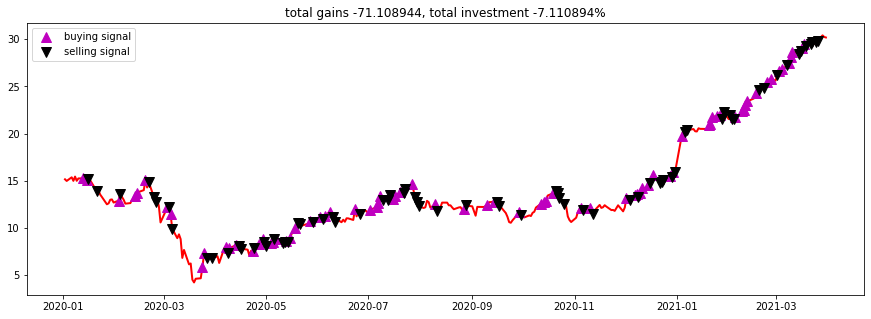

In [302]:
# Plot the results

plot_signals(values = angpy_stock_pred['ANGPY'])